# The News of Our Times

### Jump to Section
[Introduction](#introduction),
[Project Objective](#project_objective), 
[Data Sources](#data_sources), 
[Assumptions](#assumptions), 
[Database Building](#database_building),
[Data Loading & Cleaning](#data_loading_cleaning),
[Exploratory Data Analysis (EDA)](#eda), 
[EDA Results](#eda_results),
[Figure 1](#figure_1),
[Figure 2](#figure_2), 
[Figure 3](#figure_3), 
[Figure 4](#figure_4), 
[Figure 5](#figure_5), 
[Figure 6](#figure_6), 
[Figure 7](#figure_7), 
[Figure 8](#figure_8), 
[Figure 9](#figure_9), 
[Figure 10](#figure_10), 
[Figure 11](#figure_11), 
[Figure 12](#figure_12), 
[Figure 13](#figure_13), 
[EDA Summary](#eda_summary), 
[Logistic Regression Model](#logistic_regression_model), 
[Monogram and Bigram Selection from Post Messages](#message_post_nlp),
[Model Building](#model_building), 
[Model Results and Evaluation](#model_evaluation), 
[Figure 14](#figure_14), 
[Figure 15](#figure_15), 
[Figure 16](#figure_16), 
[Figure 17](#figure_17),
[Conclusion](#conclusion)
[Future Work](#future_work)  

In [185]:
# Load all packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as tkr
import sqlite3
from IPython.display import display
import random
from collections import Counter
import string
from sklearn.preprocessing import StandardScaler, minmax_scale,label_binarize
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from spacy import en
import re
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc
import itertools
from scipy import interp,delete
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV 
import patsy
import urllib2
import json
import datetime
import csv
import time

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Designate color scheme used
colors=sns.color_palette("Set2", 40)

<a name="introduction"></a>
## Introduction

Fake news is a very hot topic these days after the 2016 U.S. Presidential election. Facebook and Google are responding with their own actions to reduce the spread of fake news, including down-ranking in search results and pulling advertisement funds[[1](http://www.reuters.com/article/us-alphabet-advertising-idUSKBN1392MM),[2](https://techcrunch.com/2016/12/15/facebook-now-flags-and-down-ranks-fake-news-with-help-from-outside-fact-checkers/)]. The technological challenge of automatically tagging fake news without thoroughly cross-checking statements-a task only a human can accomplish well at this time, is a serious obstacle to preventing the spread of fake news [[3](https://qz.com/843110/can-artificial-intelligence-solve-facebooks-fake-news-problem/)]. Excited by the opportunity to address this unique and challenging (real-world) problem, I found the inspiration to tackle the following project. 

<a name="project_objective"></a>
## Project Objective

My project analyzed posts from Facebook news pages between August 26th, 2016 to January 20th, 2017, to explore the effects the election had on posting and engagement by type of news. In addition, I had the following objectives:

- Identify some of the factors that could uniquely identify whether a shared Facebook news post is from a mainstream, fake, conspiracy, or satire source. I suspect that the differences between fake, conspiracy, and satire sources are subtle, and, therefore, the potential minute differences between them would need to be inspected more closely than merely an inspection between mainstream and fake news. For this reason, a multiclass inspection over a binary one (i.e. fake and not fake news) is preferred in this project.

- Leverage differences between types of news to build a multiclass logistic regression model that tags a shared Facebook news post by type using important one or two word series, a.k.a monograms and bigrams, from post messages (e.g. “#neverhillary”, “follow american”), patterns in engagement activities (e.g. the proportion of likes out of the total number of Facebook reactions, shares, and comments for a post), type of post attachment (e.g. image, video, none, etc.), and various factors of time (i.e. day of week, hour of day, and timing of election [i.e. before, same day, or after]). A regression model is appropriate for the purposes of this project to identify the most important model features by examining model coefficients. The value of an appropriately calibrated model could help Facebook identify what posts to flag for taking actions to disincentivize the dissemination of fake news or for use by computational journalists to track the issues related to fake news to meet future reporting responsibilities.

<a name="#data_sources"></a>
## Data Sources

<a href="http://www.merrimack.edu/live/profiles/586-melissa-mish-zimdars/"><img src="zimdars.png" style="width: 100px; float: left;"></a>

Dr. Melissa Zimdars of Merimack College

My dataset was assembled by taking the following steps:
1. A list of mainstream news sites was generated using a [Pew Research study published on October 21, 2014, Political Polarization & Media Habits: From Fox News to Facebook, How Liberals and Conservatives Keep Up with Politics](http://www.journalism.org/2014/10/21/political-polarization-media-habits/). Comprising the list were well-known sources more trusted than not by the general public as identified in Pew’s study.
2. Two sources were used to generate a list of fake, conspiracy, and satire news sites. A [list of fake, conspiracy, and satire news sources compiled by Dr. Melissa Zimdars of Merimack College](https://github.com/BigMcLargeHuge/opensources) was cross-checked against against a list of news sources by the corresponding target types and unknown types from a [fake news Kaggle dataset](https://www.kaggle.com/mrisdal/fake-news) compiled in October and November of 2016 using the [BS ("bullshit") Detector Chrome Extension from Daniel Sieradski](https://www.producthunt.com/posts/b-s-detector). All news sources listed as fake, conspiracy, and satire in Dr. Zimdars list were inspected for Facebook pages unless the news label explicitly conflicted with the news label of the sources in the Kaggle dataset. To focus on U.S. media, various known foreign pages were excluded, although all foreign pages were not entirely eliminated.
3. All news postings were retrieved from the Facebook pages of mainstream, fake, conspiracy, and satire sources via the [Facebook Graph API](https://developers.facebook.com/docs/graph-api).

<a name="assumptions"></a> 
## Assumptions

- The list compiled by Melissa Zimdars have Facebook posts consistent with the category assigned when examined as a whole. A mainstream news post contains accurate information with the intent of informing the reader about a current event. A fake news post contains inaccurate information with the intent of misleading the reader. Conspiracy does not contain information that can be verified with an unknown or unapparent intent. Satire may contain inaccurate information and/or perhaps unverified information with the intent of humoring or entertaining the reader.
- Proxies for thoroughly cross-checking and verifying the validity of statements/accounts, i.e. good journalism, and inferring intent can predict the type of news.
- A model built on a skewed sample can be used to accurately categorize the news in the real world when the ratios of exposure to the type of news is changing and dependent on previous user engagement with information on Facebook.
- Each Facebook news post can be adequately, appropriately assigned to a unique category.
- The logit of the probabilities of the types of news are linear with respect to the model parameters.

<a name="database_building"></a> 
### Database Building

<a href="https://www.sqlite.org/"><img src="SQLite.png" style="width: 300px; float: left;"></a> 

Post information was compiled to a local drive via Facebook's Graph API by making modifications to [Python code from a separate programmer](https://drive.google.com/file/d/0Bw1LIIbSl0xuRTNCZElUa3U1b1U/view). Posts were then uploaded to a SQLite database. Once the database was complied, posts were then pulled back into Python for analysis. Uploading to the SQLite database proved to be unnecessary after evaluating the size of the final compiled database.

In [14]:
# Establish a connection with an empty SQLite database created using the DB Browser for SQLite:http://sqlitebrowser.org/.
sqlite_db = './facebook_news.sqlite'
conn = sqlite3.connect(sqlite_db) 

In [ ]:
# Make a table within database with the following table columns and types. 
c = conn.cursor()
c.execute('CREATE TABLE fbook_news (p_key INTEGER PRIMARY KEY, status_id TEXT, status_message TEXT, \
          link_name TEXT, status_type TEXT, status_link TEXT, permalink_url TEXT, status_published TEXT, \
          num_reactions INTEGER, num_comments INTEGER, num_shares INTEGER, num_likes INTEGER, num_loves INTEGER, \
          num_wows INTEGER, num_hahas INTEGER, num_sads INTEGER, num_angrys INTEGER, type TEXT, fb_id TEXT);')

# Commit the changes
conn.commit()

In [ ]:
# Sample code used to upload all csv files into the database table fbook_news for all types of news sources.
mainstream=["nytimes", "wsj", "ABCNews", "CBSNews", "cnn","usatoday", "washingtonpost",
           "msnbc","newyorker","yahoonews","FoxNews", "NPR", "newshour"]
mainstream_files=[i+"_facebook_statuses.csv" for i in mainstream]
count_rows=0
for i,item in enumerate(mainstream_files):
    files='./mainstream/'+item
    data = pd.read_csv(files, low_memory=False, encoding='utf-8')  
    data['type']='mainstream'
    data['fb_id']=mainstream[i]

    data.to_sql('fbook_news',             
                con=conn,                   
                if_exists='append',        
                index=False)
    print "i:",i,"item:", item, " length:", len(data.iloc[:,1])
    count_rows=count_rows+len(data.iloc[:,1])
print count_rows

<a name="data_loading_cleaning"></a>
### Data Loading & Cleaning

The following steps were taken to download and clean the data before performing exploratory data analysis (EDA):
1. Post information was compiled to a local drive via Facebook’s Graph API by making modifications to a Python code provided by another [programmer](https://drive.google.com/file/d/0Bw1LIIbSl0xuRTNCZElUa3U1b1U/view). The data extracted from Facebook included post message, title of link, type of link, post date, and individual counts of comments, shares, likes, loves, wows, hahas, sads, and angrys.
2. Additional data columns were generated from the existing dataset or merged with known information to make a more detailed final dataset also showing Facebook page id, type of news page (i.e. mainstream, fake, conspiracy, or satire), day of week, hour, timing of election, and sum of all user engagement activities (i.e. sum of comments, shares, likes, loves, wows, hahas, sads, and angrys).
3. All text was converted from unicode to string format.
4. 99 of the posts were identified as redundant (0.04% of the total), so these were removed.
5. All urls were removed from post messages to avoid selecting when identifying important monograms and bigrams from post messages.

In [186]:
# Establish a connection with the compiled SQLite database.
sqlite_db = './facebook_news.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

# Read fbook_news table into Python.
fb_news_total=pd.read_sql('SELECT * FROM fbook_news', con=conn)

# Close database connection. 
conn.close()

In [187]:
# Convert object columns from unicode to string
def decoder(x):
    if not x:
        return ''
    else:
        x_ = ''.join([ch for ch in x if ch in string.printable])
        return str(x_.decode())
    
object_types=fb_news_total.columns[fb_news_total.dtypes=='object']
for i in object_types:
    fb_news_total[i] = fb_news_total[i].map(decoder)

In [105]:
# Show type of each entry of object series
object_types=fb_news_total.columns[fb_news_total.dtypes=='object']
for i in object_types:
    print i," ", type(fb_news_total.ix[1,i])

status_id   <type 'str'>
status_message   <type 'str'>
link_name   <type 'str'>
status_type   <type 'str'>
status_link   <type 'str'>
permalink_url   <type 'str'>
status_published   <type 'str'>
type   <type 'str'>
fb_id   <type 'str'>


In [188]:
# Convert time column from object to datetime format
fb_news_total.status_published=pd.to_datetime(fb_news_total.status_published)

# Add time element columns
fb_news_total['day_of_week']=fb_news_total.status_published.dt.weekday_name
fb_news_total['hour']=fb_news_total.status_published.dt.hour

In [189]:
# Remove any posts outside the project study period from August 26, 2016 [including] to January 19, 2017 [including ] 
mask=((fb_news_total['status_published'] >= '2016-08-26') & (fb_news_total['status_published'] < '2017-01-20')) 
fb_news_total=fb_news_total.loc[mask]
fb_news_total['election_day']='same'
fb_news_total.ix[fb_news_total['status_published']<'2016-11-07','election_day']='before'
fb_news_total.ix[fb_news_total['status_published']>='2016-11-08','election_day']='after'
fb_news_total.reset_index(inplace=True, drop=True)

In [190]:
# Remove any duplicate posts
mask=((fb_news_total.duplicated(['status_id'])) & (fb_news_total.duplicated(['status_message'])) & 
      (fb_news_total.duplicated(['link_name'])) & (fb_news_total.duplicated(['status_link'])) &
      (fb_news_total.duplicated(['permalink_url'])) & (fb_news_total.duplicated(['status_published']))
     & (fb_news_total.duplicated(['num_reactions'])))

print fb_news_total.shape
fb_news_total=fb_news_total[~mask]
print fb_news_total.shape
fb_news_total.reset_index(inplace=True, drop=True)

(274717, 22)
(274618, 22)


In [191]:
# Create a column summing all types of interactions, i.e. like count, wow count, share count, comment count, etc.
fb_news_total['all_interactions']=fb_news_total['num_reactions']+fb_news_total['num_shares']+fb_news_total['num_comments']

In [110]:
# Show columns, types, and non-null objects
# All columns should be self-explanatory except for p-key, type, fb_id, num_reactions
# p-key is a unique identifier associated with each row of the dataset
# type is our target variable: mainstream, fake, conspiracy, and satire
# fb_id is the name of the Facebook page analyzed
# num_reactions is the sum of likes, loves, wows, hahas, sads, angrys
fb_news_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274618 entries, 0 to 274617
Data columns (total 23 columns):
p_key               274618 non-null int64
status_id           274618 non-null object
status_message      274618 non-null object
link_name           274618 non-null object
status_type         274618 non-null object
status_link         274618 non-null object
permalink_url       274618 non-null object
status_published    274618 non-null datetime64[ns]
num_reactions       274618 non-null int64
num_comments        274618 non-null int64
num_shares          274618 non-null int64
num_likes           274618 non-null int64
num_loves           274618 non-null int64
num_wows            274618 non-null int64
num_hahas           274618 non-null int64
num_sads            274618 non-null int64
num_angrys          274618 non-null int64
type                274618 non-null object
fb_id               274618 non-null object
day_of_week         274618 non-null object
hour                274618 non-

<a name="eda"></a> 
## Exploratory Data Analysis (EDA)

<a name="eda_results"></a> 
### EDA Results

The following section explores characteristics of the dataset to better understand how the predictors perform in the final model.

The final dataset included over 274 thousand posts and over 900 million engagement activities from 129 Facebook pages. Though the number of mainstream sites in the dataset were few, mainstream posts were the second most common type of post ([Figure 1](#figure_1) and [Figure 2](#figure_2)).

In [10]:
# Show column count of project dataset
fb_news_total.shape[1]

26

In [11]:
# Report total counts of posts and engagement activities (engagements) analyzed
# An engagement activity is either a share, comment, like, love, wow, haha, sad, or angry count
num_format = lambda x: '{:,}'.format(x)
print "Total number of Facebook posts analyzed: ",num_format(fb_news_total.shape[0])
print "Total number of Facebook engagements analyzed: ",num_format(sum(fb_news_total['all_interactions']))

Total number of Facebook posts analyzed:  274,618
Total number of Facebook engagements analyzed:  900,663,340


Total number of Facebook pages with posts analyzed:  129


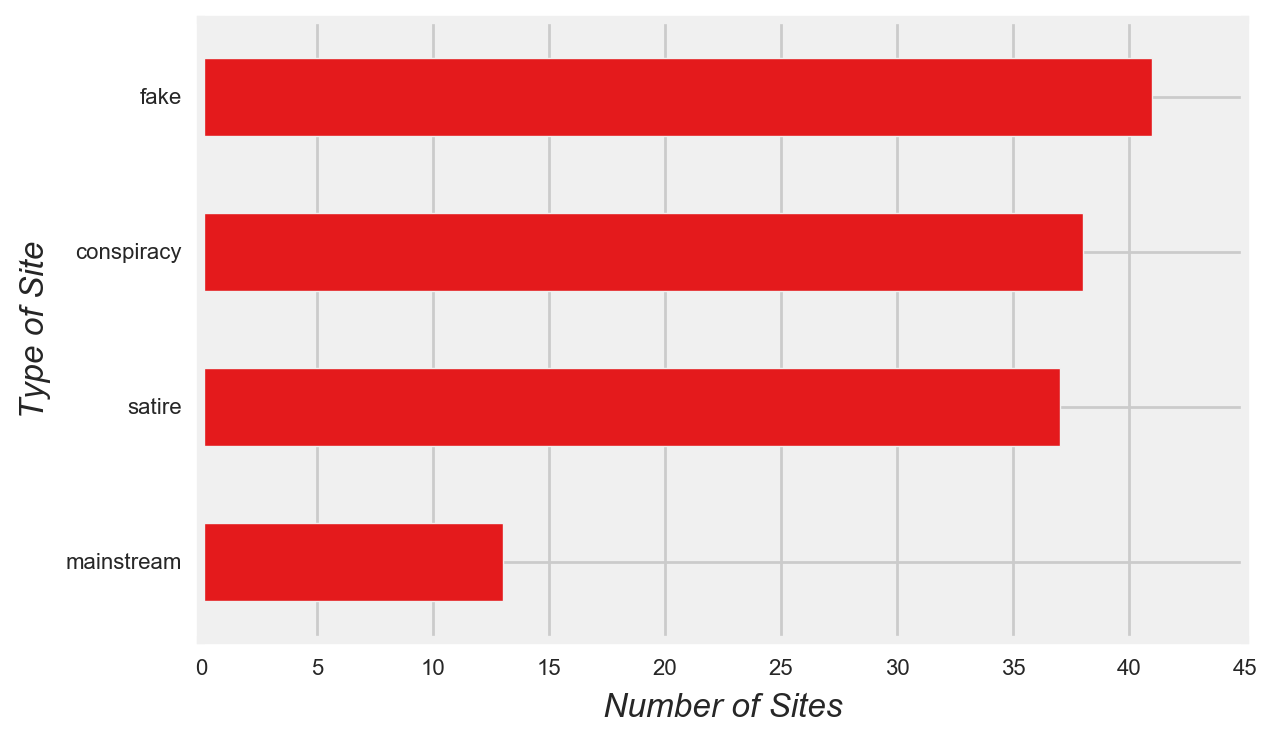

In [12]:
# Plot count of each type of page analyzed
print "Total number of Facebook pages with posts analyzed: ", len(fb_news_total['fb_id'].unique())
fb_news_total.groupby(['type'])['fb_id'].unique().map(lambda x: len(x)).sort_values().plot(kind='barh',color='#e41a1c')
plt.ylabel("Type of Site",style='italic')
plt.xlabel("Number of Sites",style='italic')
plt.tick_params(axis='both', which='major', labelsize=8)

<a name="figure_1"></a> 
#### Figure 1
[See EDA Summary for discussion.](#eda_summary)

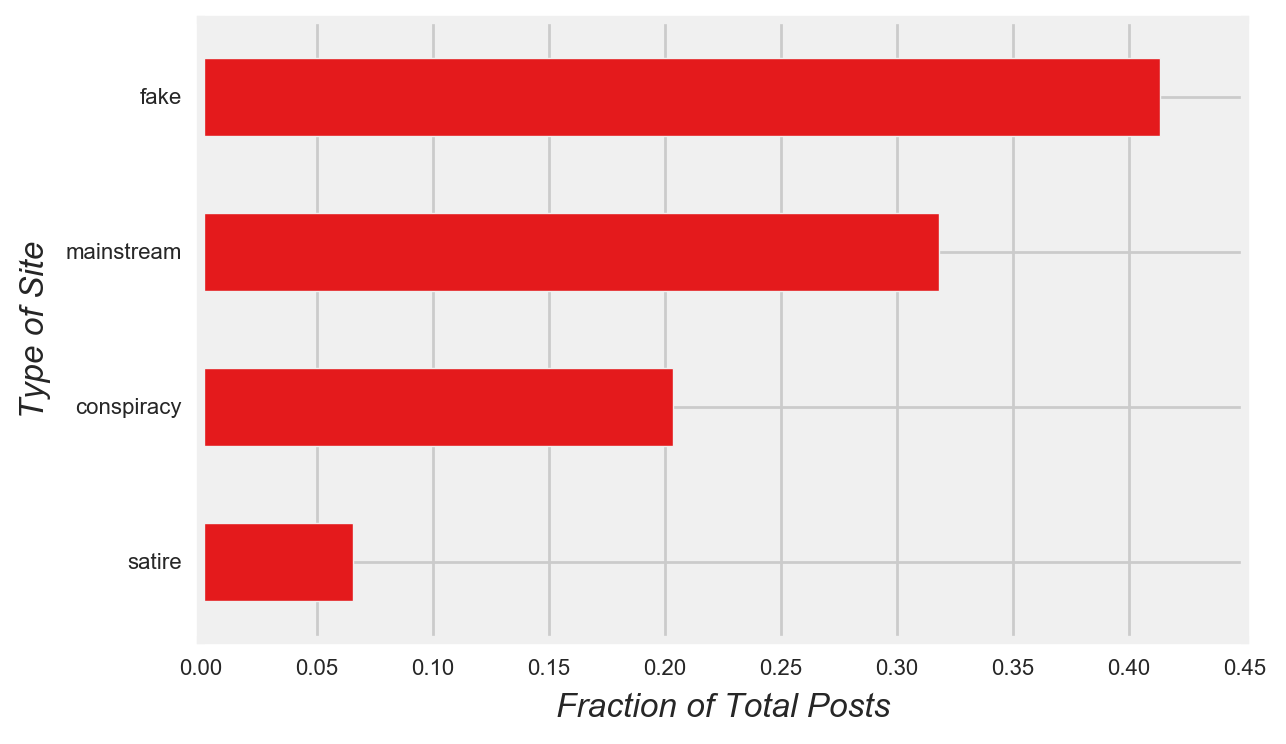

In [13]:
# Plot proportion of posts by type
((1.*fb_news_total.groupby(['type'])['p_key'].count())/len(fb_news_total['p_key'])).sort_values().plot(kind='barh',color='#e41a1c')
plt.ylabel("Type of Site",style='italic')
plt.xlabel("Fraction of Total Posts",style='italic')
plt.tick_params(axis='both', which='major', labelsize=8)

<a name="figure_2"></a> 
#### Figure 2
[See EDA Summary for discussion.](#eda_summary)

In [14]:
# List mainstream pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='mainstream','fb_id'].unique()
print "Number of mainstream sites: ",len(temp)
print temp

Number of mainstream sites:  13
['nytimes' 'wsj' 'ABCNews' 'CBSNews' 'cnn' 'usatoday' 'washingtonpost'
 'msnbc' 'newyorker' 'yahoonews' 'FoxNews' 'NPR' 'newshour']


In [15]:
# List fake pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='fake','fb_id'].unique()
print "Number of fake sites: ",len(temp)
print temp

Number of fake sites:  41
['worldrumor' 'FreshNews000' 'TheRightists' 'subjectpolitics'
 'weeklyworldnews' 'USPoliticsLive' 'DcGazette' 'FreedomDailyNews'
 'EmpireNewsNet' 'Newslo1' 'NewsWithViews' 'supremepatriot'
 'StormCloudsGathering' 'DHeadlines' 'newsexaminer.net' '24Newsflash'
 'LastGreatStand' 'eutopiabuzz' 'conservativeinfidel'
 'ThreePercenterNation' 'TheUndergroundWorldNews' 'RHobbusJD'
 'downtrendcom' 'intrendtoday' 'ClashDaily' 'worldstoriestoday'
 'TheAdoboChronicles' 'beforeitsnewscom' 'DonaldTrumpNews.Co' 'hmakow'
 'pakalertpress' 'usasupreme' 'rilenews' 'RickRWells' 'usanewsoftheday'
 'yesiamright' 'proudcons' 'conservativebyte' 'politicalsitenews' 'prntly'
 'OnlineConservativePress']


In [16]:
# List conspiracy pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='conspiracy','fb_id'].unique()
print "Number of conspiracy sites: ",len(temp)
print temp

Number of conspiracy sites:  38
['pamelageller' 'fprnradio' 'americanfreepress' 'LibertyTalkFM'
 'TheMindUnleashed' 'adeptoerperfectus' 'Gaia' 'conservativerefocusgroup'
 'CanadaFreePress' 'concisepolitics' 'ThePoliticalInsider'
 'DisclosureMedia' 'TheSilverDoctors' '21WIRE.TV' 'atsnews' 'activistpost'
 'EyeOpeningInfo' 'freedomoutpost' 'GlobalResearchCRG' 'govtslaves'
 'HumansAreFree' 'investmentresearchdynamics' 'intelligencehub'
 'NewsTargetOfficial' 'NowTheEndBegins' 'theprepperwebsite'
 'SECRETSofTheFED' 'thedailysheeple' 'theeventhandbook'
 'TruthBroadcastNetworkcom' 'truth.frequency.radio' 'ufoholics'
 'zerohedge1' 'SilverCoinInvestor' 'LibertyMovementRadio' 'BradleeDeanSOL'
 'TheLibertyBeaconProject' 'AwarenessAct']


In [17]:
# List satire pages analyzed in the project
temp=fb_news_total.ix[fb_news_total['type']=='satire','fb_id'].unique()
print "Number of satire sites: ",len(temp)
print temp

Number of satire sites:  37
['TheHolyObserver' 'NewsToad' 'associatedmediacoverage' 'dailycurrant'
 'theineptowl' 'betootaadvocate' 'clickhole' 'disclosetv' 'elmundotoday'
 'Gomerblog' 'NewsBiscuit' 'NewsThump' 'Reductress' 'TheOnion'
 'theunrealpage' 'WhispersNews' 'goingwunderground' 'FreeWoodPost'
 'worldnewsdailyreport' 'BeehiveBugle' 'thedandygoat' 'RockCityTimes'
 'CreamBmp' 'TheMadisonMisnomer' 'liberaldarkness' 'SportsPickle'
 'TheSkunkPage' 'stuppidcom' 'SatiraTribune' 'HumorTimes' 'blastingusa'
 'islamicanews' 'BurrardStreetJournal' 'thehardtimesnews' 'TheBeaverton'
 'FridayMash' 'TheCelebtricity']


Furthermore, regardless of the type of news, only a handful of pages posted and received the majority of the engagement ([Figure 3](#figure_3)). Based on this observation, I expected a model built on the existing skewed dataset to perform disproportionately better for the sites with the most posts and the highest levels of engagement.

Top 45 most prolific pages as a fraction of total posts:  0.8539
Top 45 pages with the most engagement counts as a fraction of total engagement:  0.9929


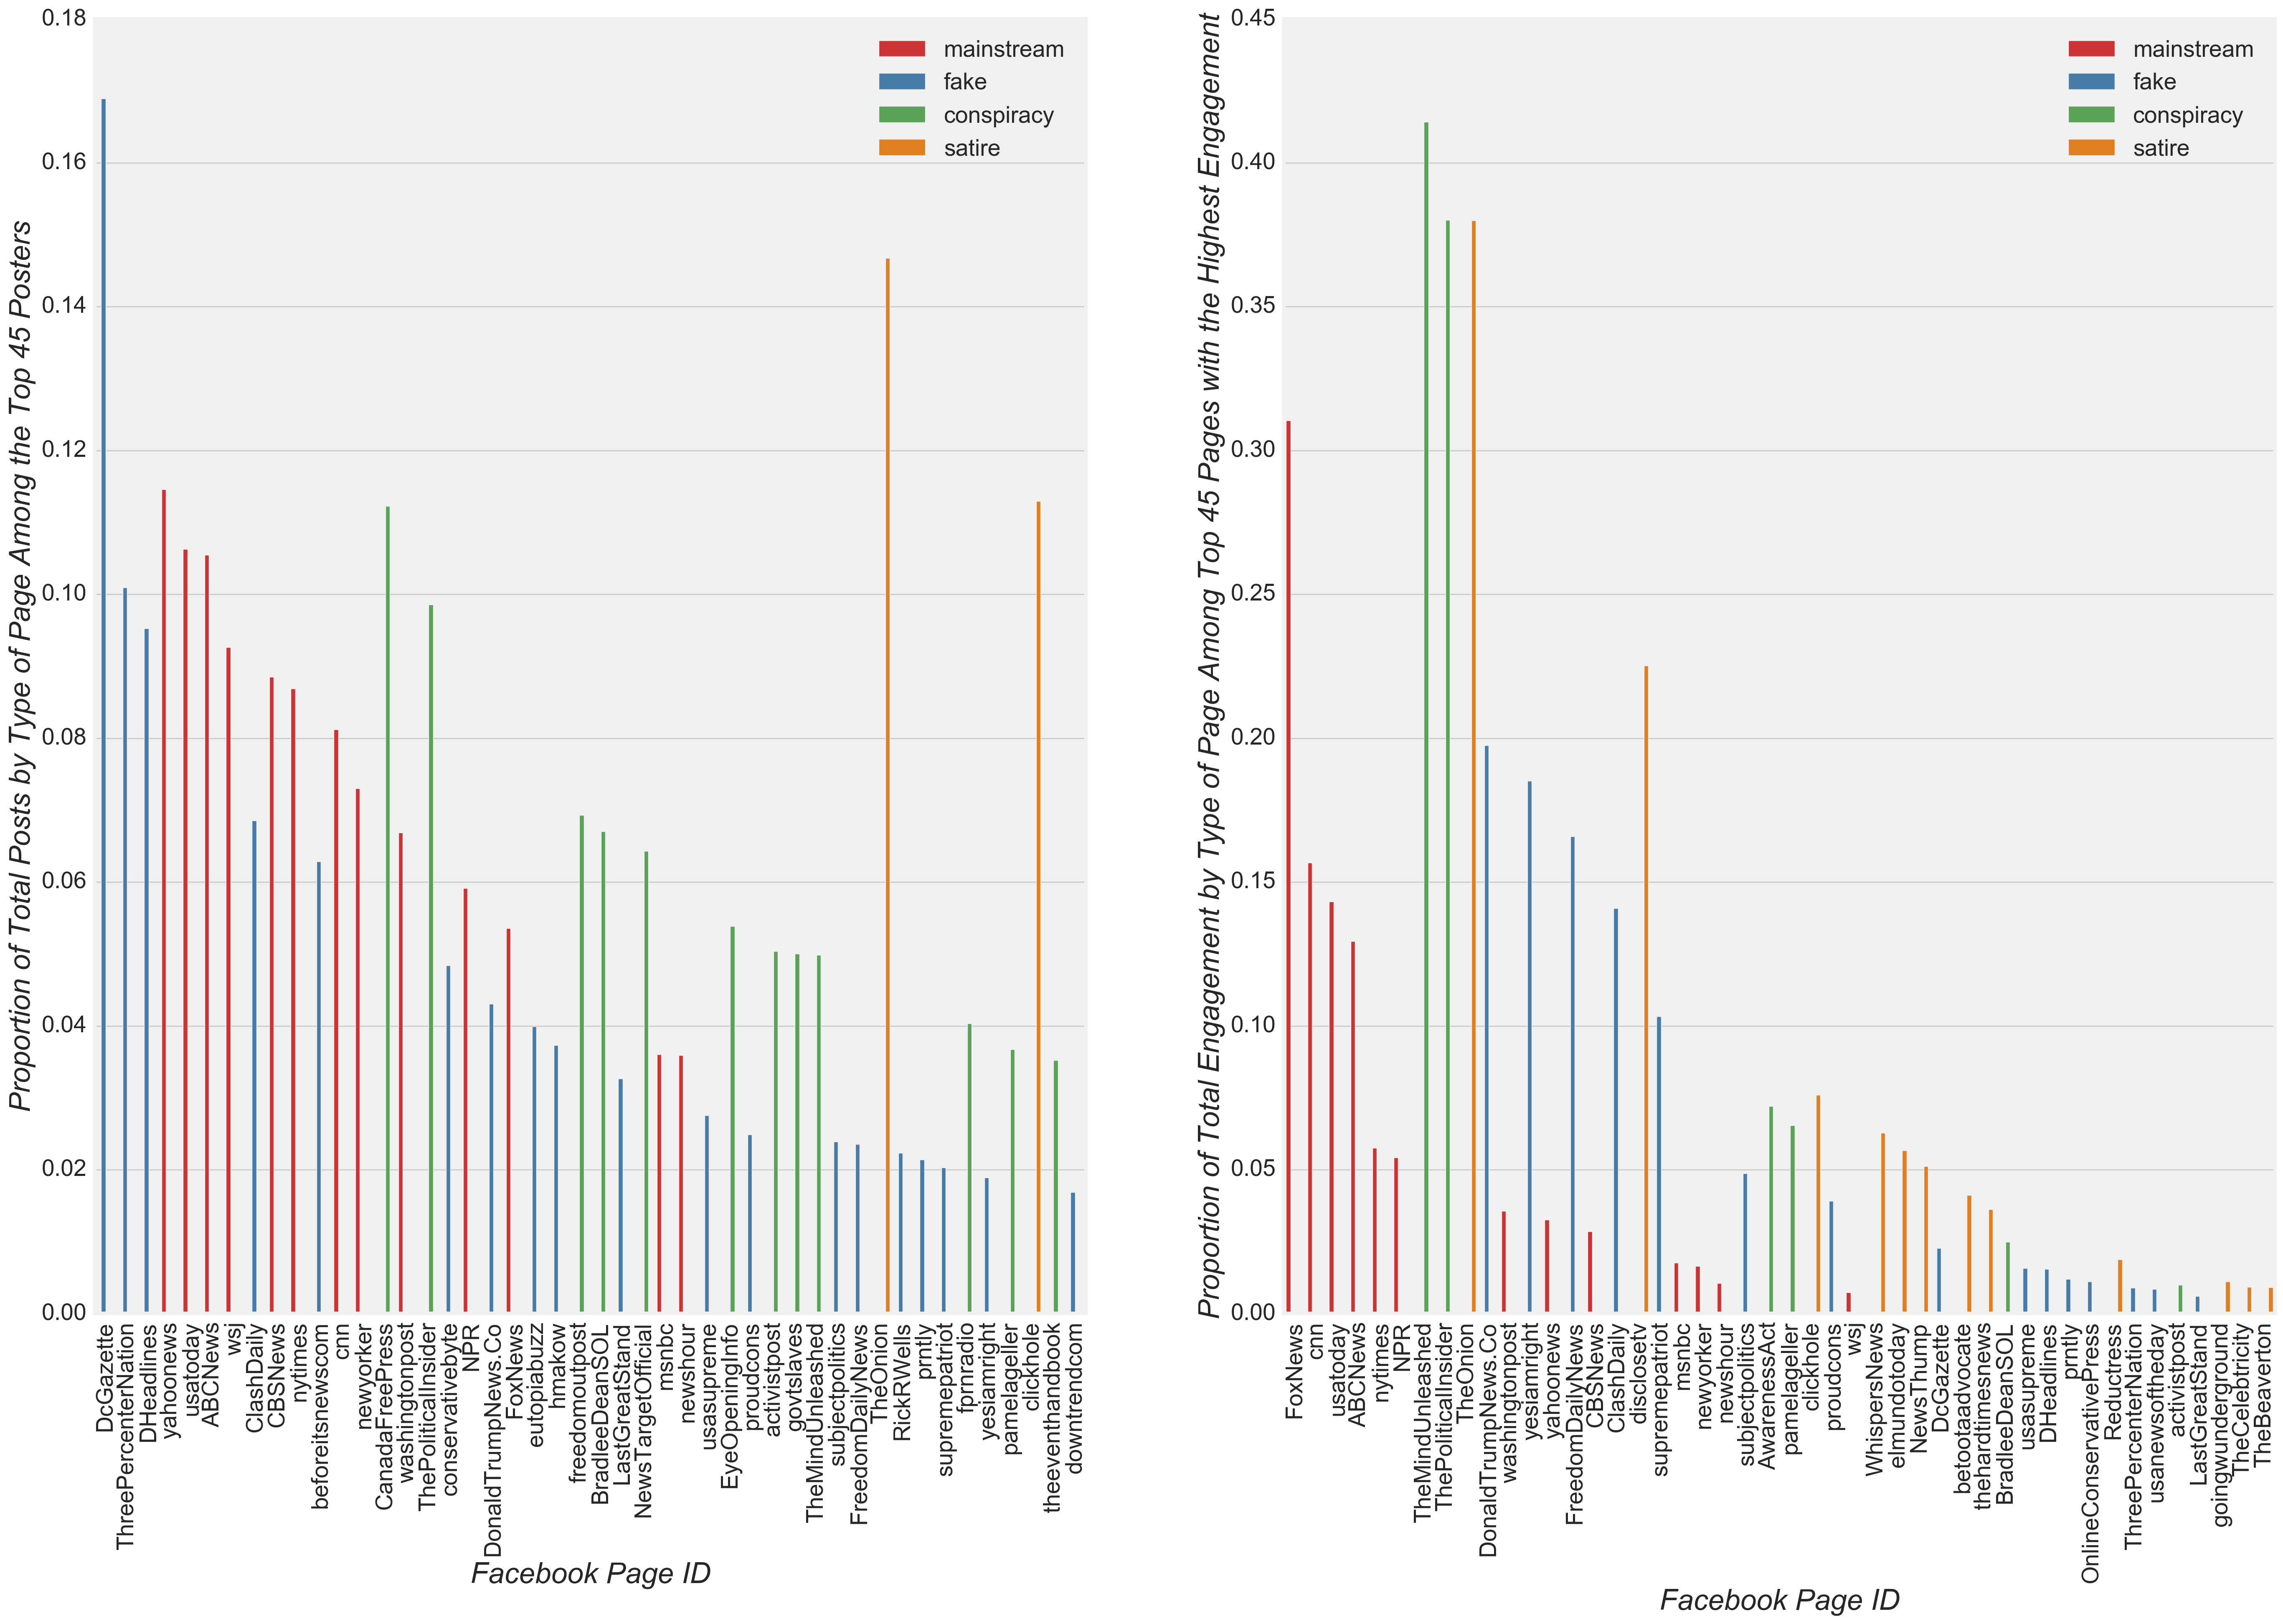

In [123]:
# Plot most prolific pages as a fraction of the total posts
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
summary=fb_news_total.groupby(['fb_id'])['p_key'].count().reset_index().sort_values(by='p_key',ascending=False).reset_index(drop=True)
top_posters=list(summary.ix[0:45,'fb_id'])

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='fb_id', y='fraction',hue="type",data=temp[temp['fb_id'].isin(top_posters)],ax=ax0,estimator=np.sum,order=top_posters,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page Among the Top 45 Posters",style='italic',fontsize=25)
ax0.set_xlabel("Facebook Page ID",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)
print "Top 45 most prolific pages as a fraction of total posts: ",round(((1.*sum(summary.ix[0:45,'p_key']))/temp.shape[0]),4)

# Plot pages with the most engagement as a fraction of total engagement
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))
summary=fb_news_total.groupby(['fb_id'])['all_interactions'].sum().reset_index().sort_values(by='all_interactions',ascending=False).reset_index(drop=True)
top_posters=list(summary.ix[0:45,'fb_id'])

sns.barplot(x='fb_id', y='fraction',hue="type",data=temp[temp['fb_id'].isin(top_posters)],ax=ax1,estimator=np.sum,order=top_posters,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Total Engagement by Type of Page Among Top 45 Pages with the Highest Engagement",style='italic',fontsize=25)
ax1.set_xlabel("Facebook Page ID",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)
print "Top 45 pages with the most engagement counts as a fraction of total engagement: ",round(((1.*sum(summary.ix[0:45,'all_interactions']))/sum(temp['all_interactions'])),4)

plt.show()

<a name="figure_3"></a>
#### Figure 3
[See EDA Summary for discussion.](#eda_summary)

Now specific characteristics of model predictors are explored with respect to posts and engagement activities. If I observed differences in the patterns of posts among different types of news with respect to the various model predictors, I expected them to be reflected in the final model as high positive or negative model coefficients relative to zero.

To begin my evaluation of model predictors, I investigated the frequency of different post attachments and engagement levels by the type of news. Upon inspection, all types of news included posts with links more frequently than any other type of attachment, and all but conspiracy also showed links receiving the highest percent of engagement compared to all other types of attachment ([Figure 4](#figure_4)). However, with respect to the second most frequent type of attachment, mainstream pages had videos attached more frequently to posts compared to all other types of news. Therefore, I expected the model to show a relatively high coefficient for mainstream videos relative to the coefficients for videos from all other types of news.

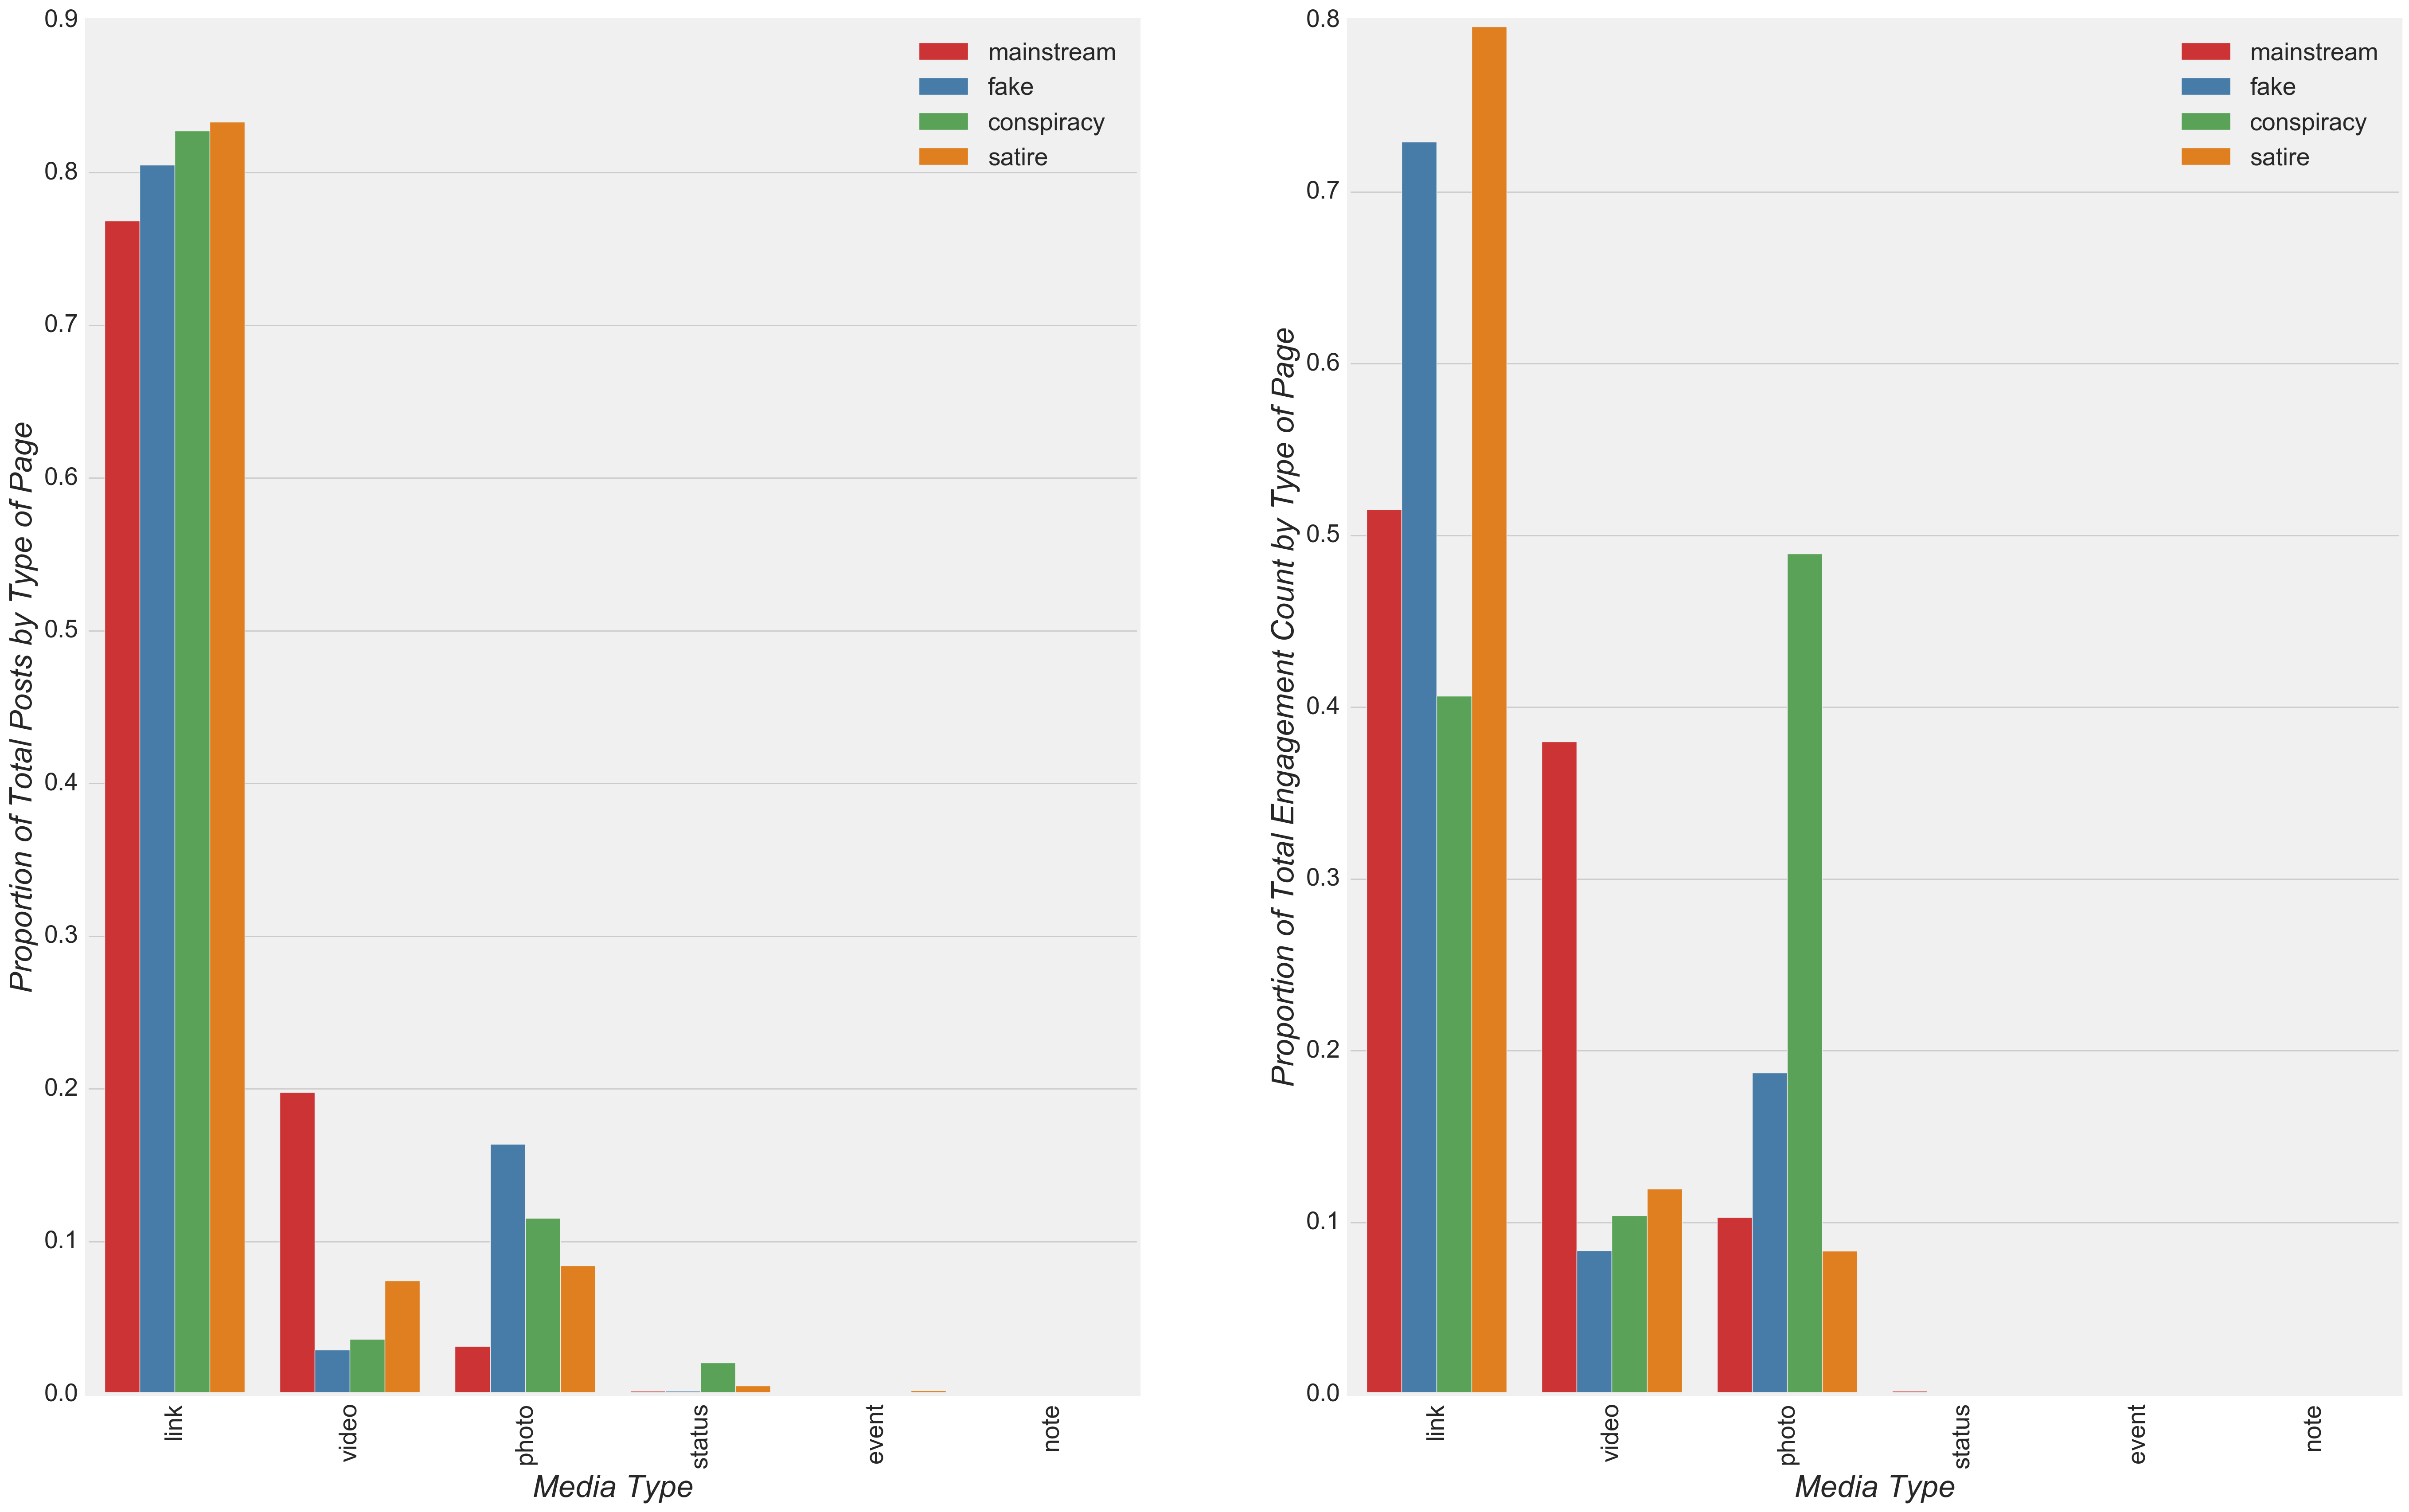

In [19]:
# Plot post counts by media type as a proportion of total post count
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='status_type', y='fraction',hue="type",data=temp,ax=ax0,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("Media Type",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)

# Plot post engagement count by media type as a proportion of total engagement
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))

sns.barplot(x='status_type', y='fraction',hue="type",data=temp,ax=ax1,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Total Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("Media Type",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)

plt.show()

<a name="figure_4"></a>
#### Figure 4
[See EDA Summary for discussion.](#eda_summary)

Next, I investigated the frequency of posts and level of engagement with respect to the U.S. Presidential Election. I observed that the most drastic change in the post volume occurred in the form of a reduction in fake news after the election, in large part due to a reduction in the post volume among the top three most prolific pages ([Figure 5](#figure_5) and [Figure 6](#figure_6)). Due to the noticeable reduction in the percentage of posts from fake news after the election, I expected that the final model would have a relatively high pre-Presidential Election fake news model coefficient compared to the post-Presidential Election fake news model coefficient. Nevertheless, engagement activities associated with fake news increased drastically, second only to the spike in engagement among mainstream news-in part due to an increase in mainstream post volume ([Figure 5](#figure_5)). The spike in engagement to mainstream news occurred largely due to relatively high engagement with posts from CNN, ABC News, and USA Today ([Figure 7](#figure_7)).

(0.4, 0.6)

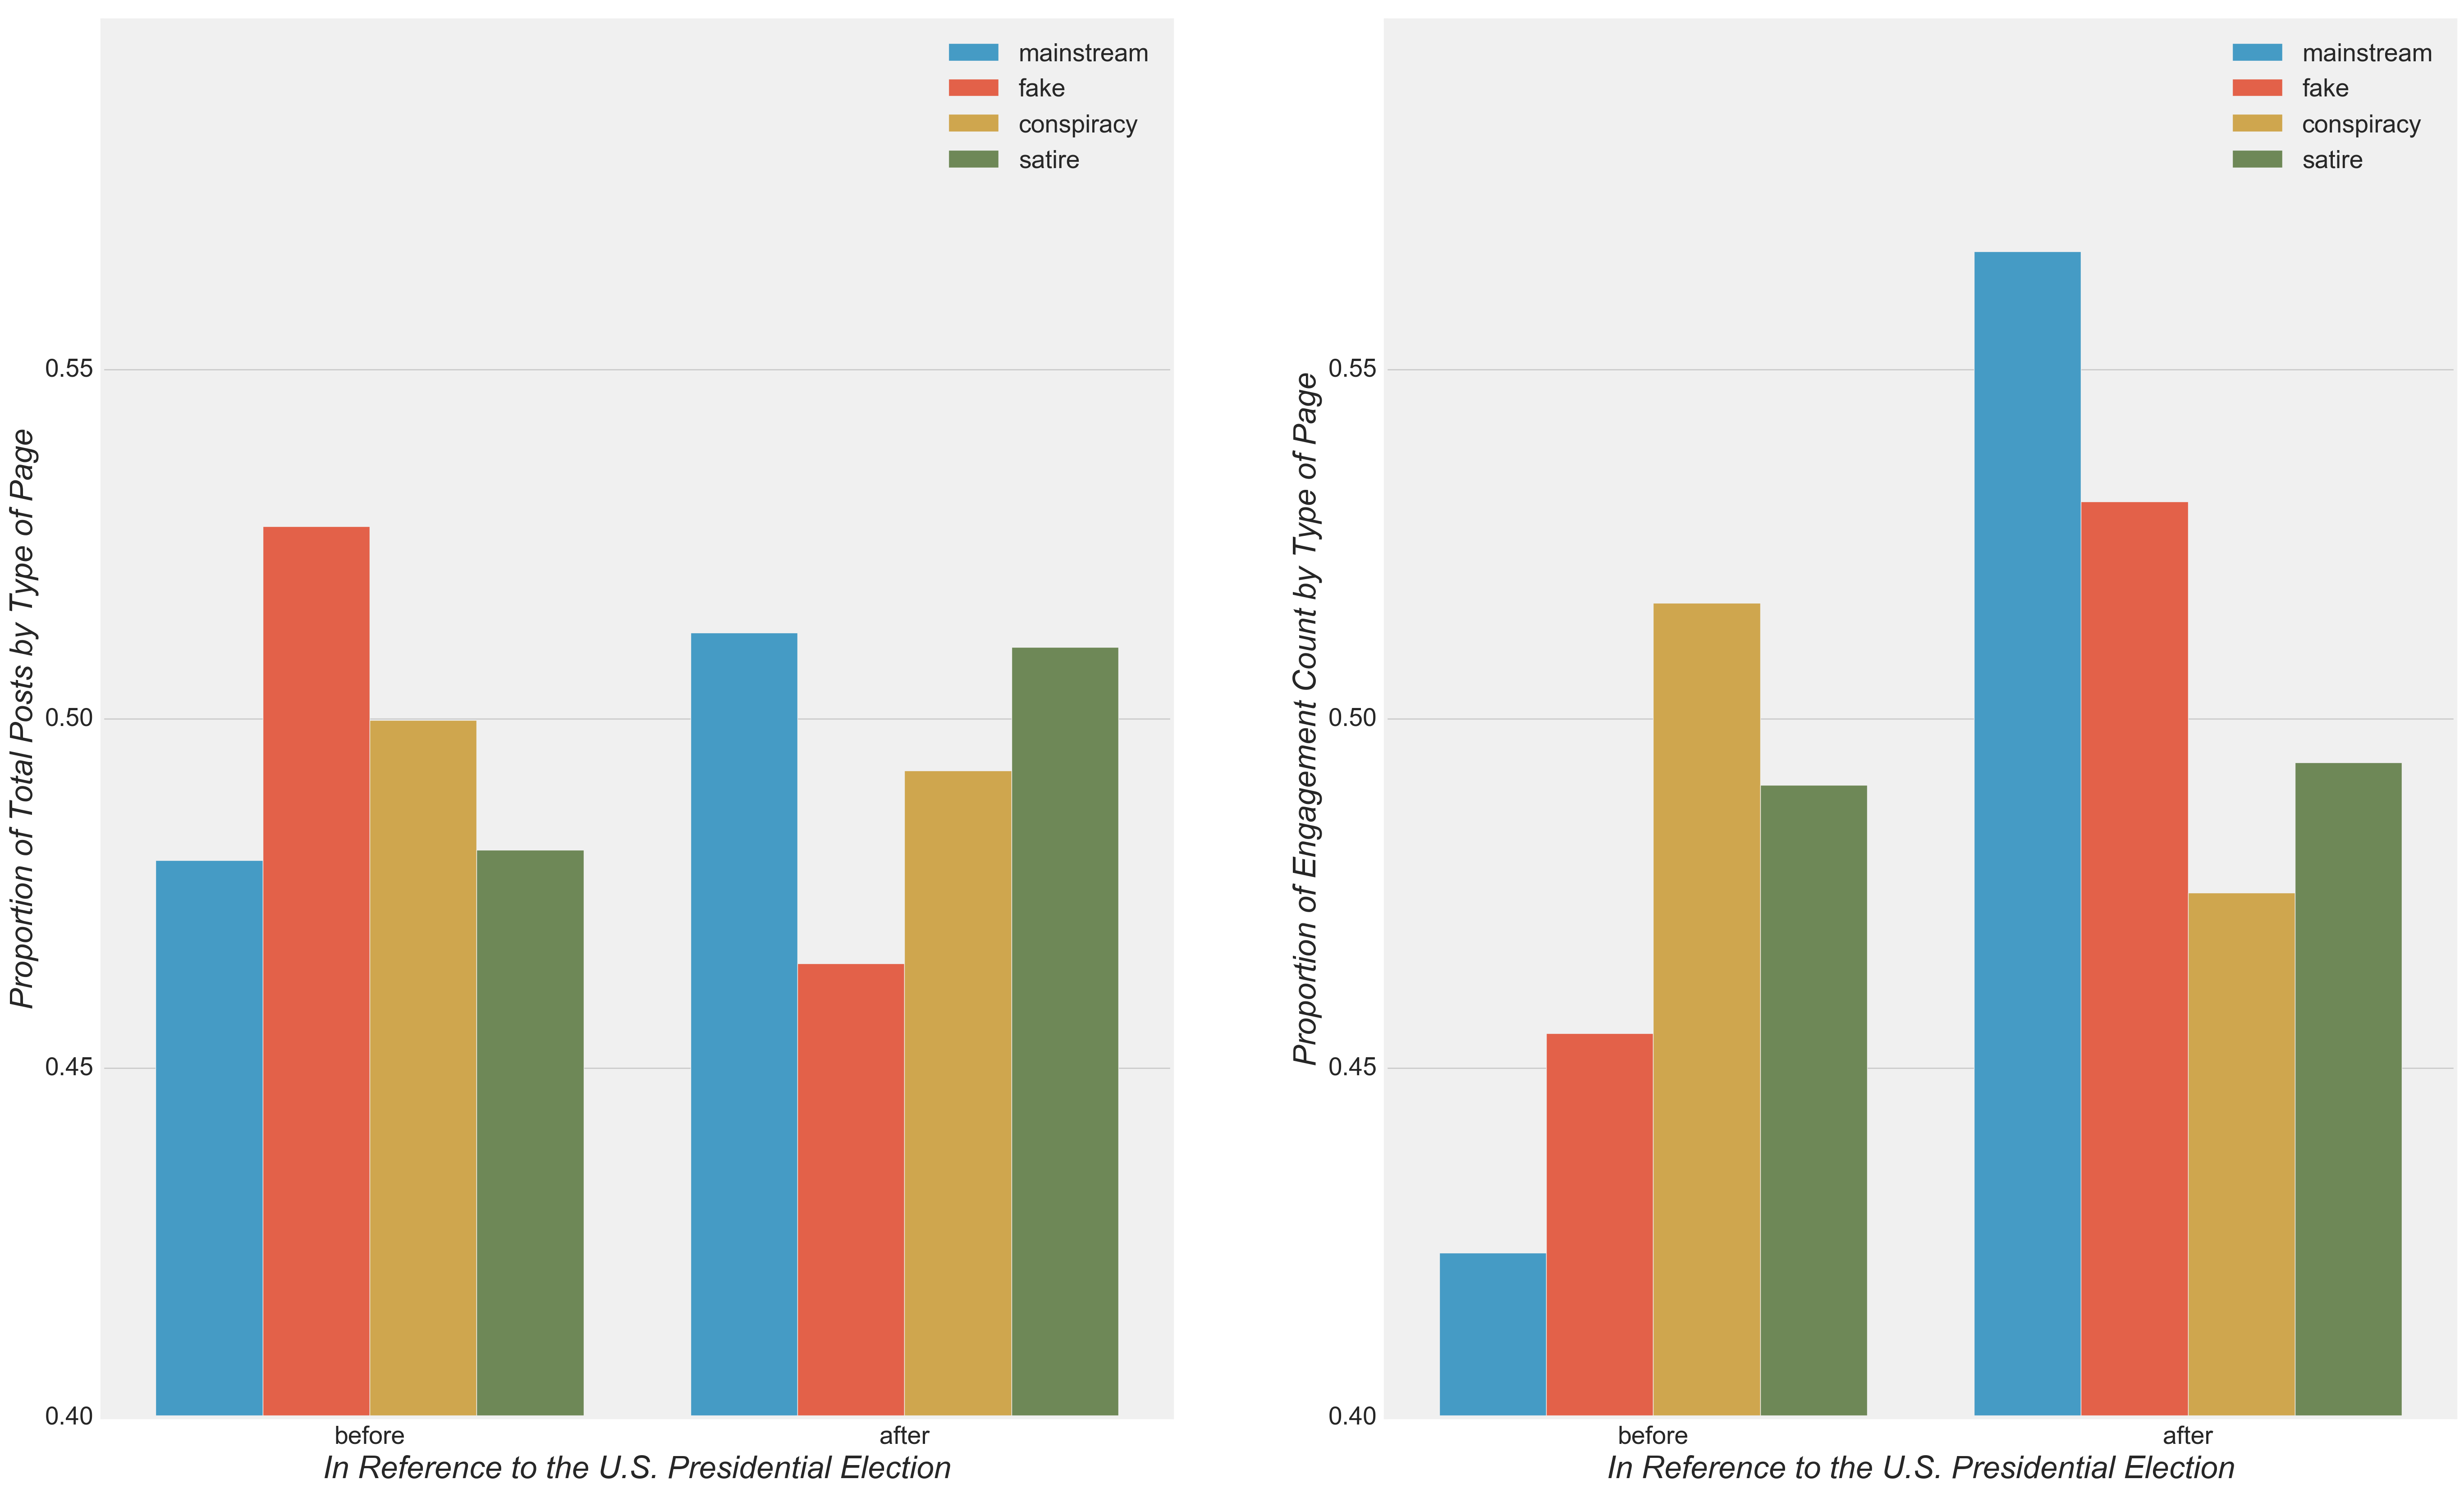

In [10]:
# Plot count of posts before and after the U.S. Presidential election as a proportion of all posts
temp=fb_news_total
temp['prop_total']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'prop_total']=(1./(temp[temp['type']==item].shape[0]))

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='election_day', y='prop_total',hue="type",ax=ax0,data=temp[temp['election_day']!='same'],order=['before','after'],estimator=np.sum,ci=False)
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("In Reference to the U.S. Presidential Election",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.legend(loc="best",fontsize=20)
ax0.set_ylim([0.4, 0.6])

# Plot engagement sum before and after the U.S. Presidential election as a proportion of the total engagement
temp['prop_total']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'prop_total']=((1.*temp['prop_total'])/(sum(temp.ix[temp['type']==item,'prop_total'])))
    
sns.barplot(x='election_day', y='prop_total', hue='type',order=['before','after'],ax=ax1,data=fb_news_total[fb_news_total['election_day']!='same'],estimator=np.sum,ci=False)
ax1.set_ylabel("Proportion of Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("In Reference to the U.S. Presidential Election",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(loc="best",fontsize=20)
ax1.set_ylim([0.4, 0.6])

<a name="figure_5"></a>
#### Figure 5
[See EDA Summary for discussion.](#eda_summary)

Total sources active before election:  40
Total sources active after election:  38
Sum of news sources with counts of posts before the election is greater than the counts after: 21


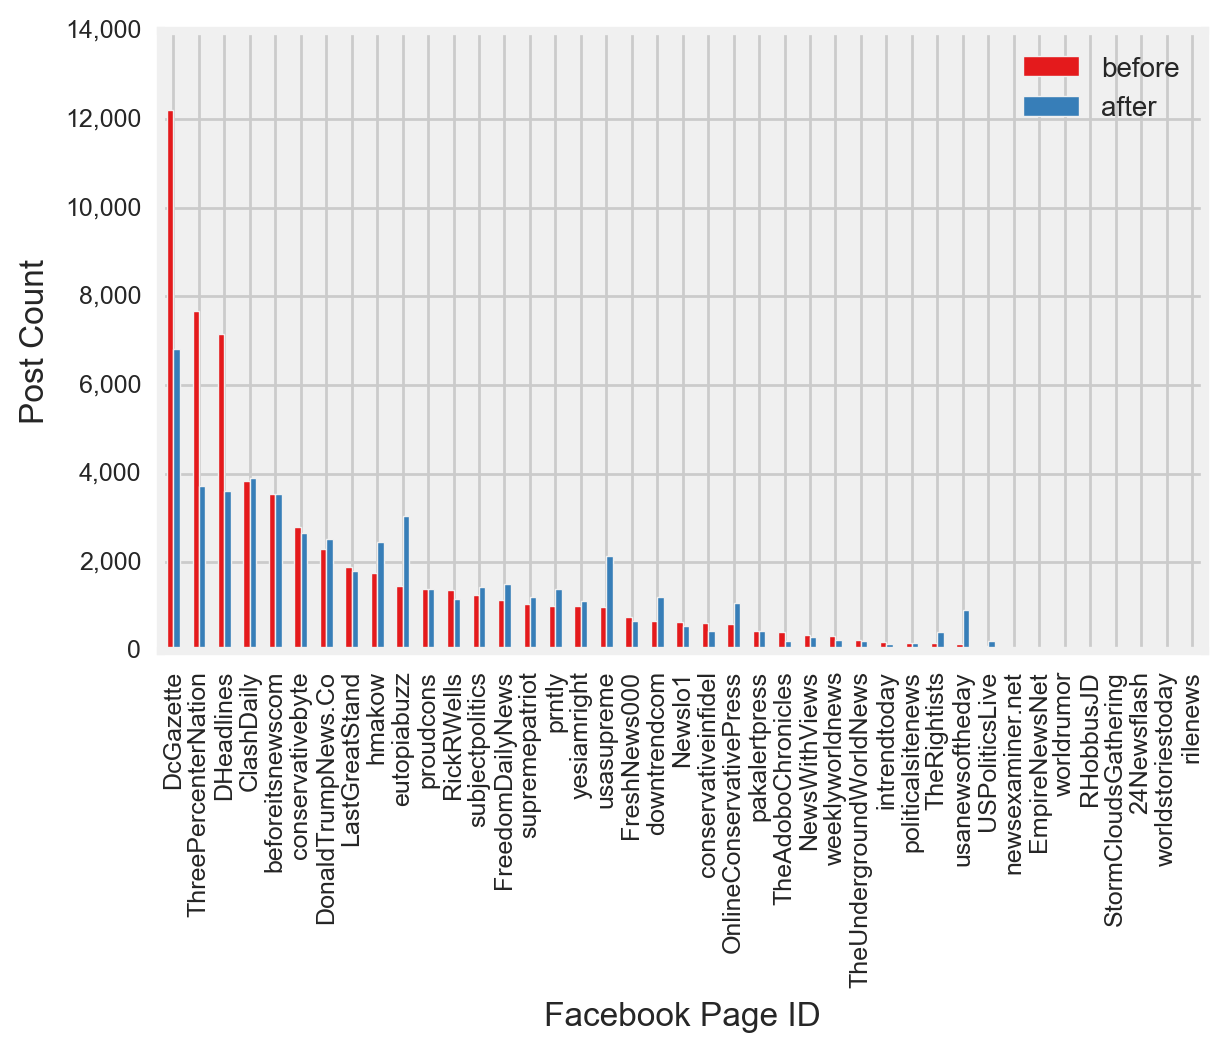

In [184]:
# Plot post counts for each fake news page to identify the reason why more fake news was posted before the election
temp=fb_news_total[fb_news_total['election_day']!='same']
temp=temp[temp['type']=='fake'].groupby(['fb_id','election_day'])['p_key'].agg('count').unstack()
temp[temp.isnull()]=0
temp=temp[['before','after']]
print "Total sources active before election: ",len(temp.ix[temp['before']>0,'before'])
print "Total sources active after election: ",len(temp.ix[temp['after']>0,'after'])
print "Sum of news sources with counts of posts before the election is greater than the counts after:",sum(temp['before']>temp['after'])
del temp.columns.name

plot=temp.sort_values(['before','after'],ascending=False).plot(kind='bar',stacked=False,color=['#e41a1c','#377eb8'])
plot.tick_params(axis='both', which='major', labelsize=9)
plot.set(xlabel='Facebook Page ID', ylabel='Post Count')
plot.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
plt.show()

<a name="figure_6"></a>
#### Figure 6
[See EDA Summary for discussion.](#eda_summary)

Total sources active before election:  13
Total sources active after election:  13


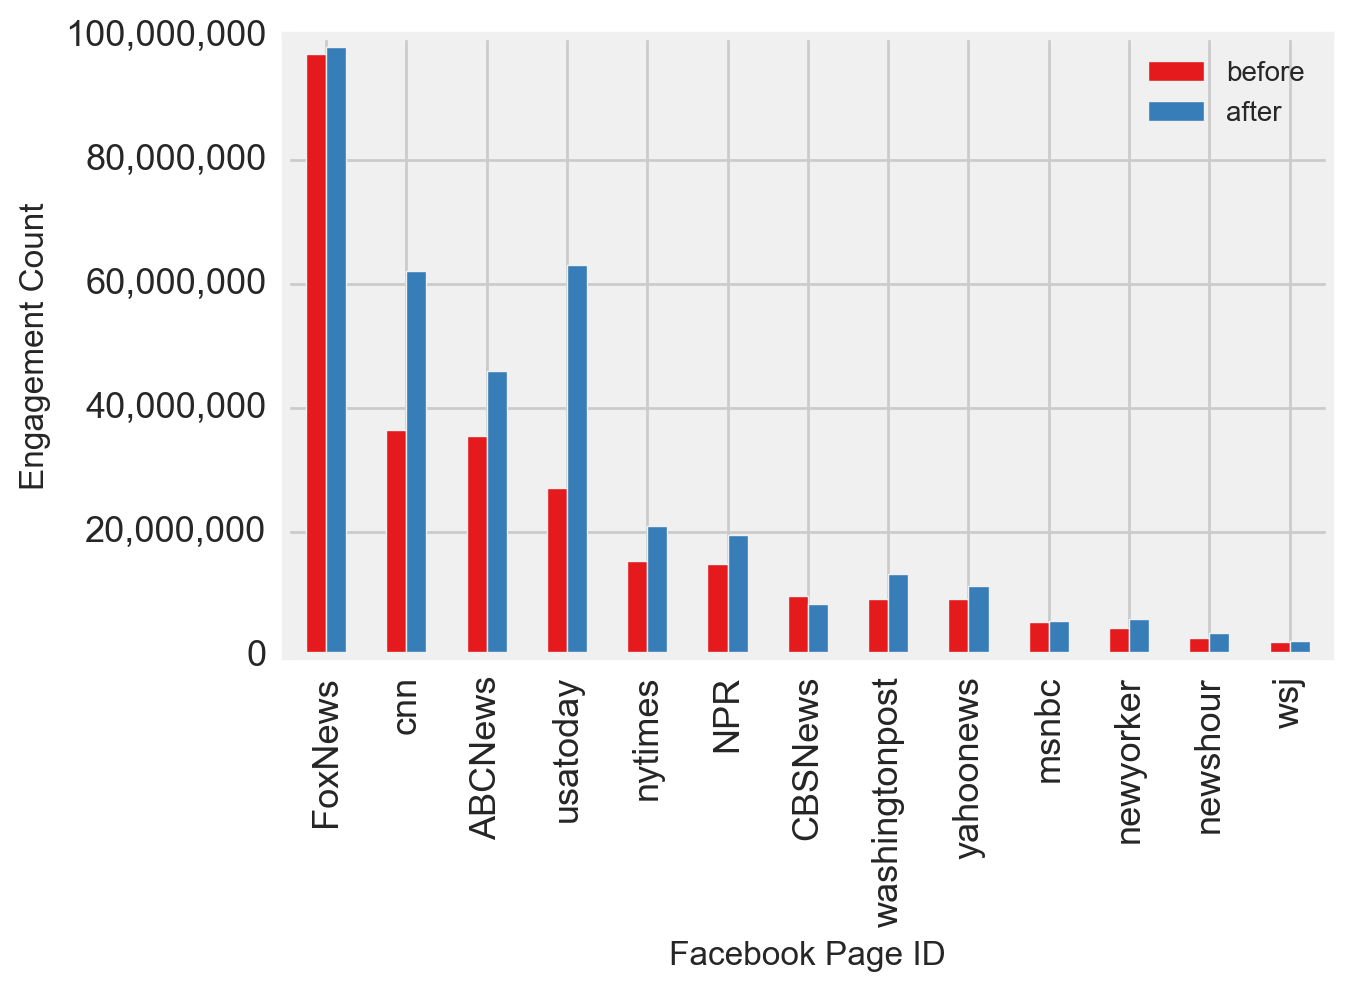

In [26]:
# Plot engagement for each mainstream news page to explain why substantially more engagement was observed after the
# election
temp=fb_news_total[fb_news_total['election_day']!='same']
temp=temp[temp['type']=='mainstream'].groupby(['fb_id','election_day'])['all_interactions'].agg(np.sum).unstack()
temp[temp.isnull()]=0
temp=temp[['before','after']]
print "Total sources active before election: ",len(temp.ix[temp['before']>0,'before'])
print "Total sources active after election: ",len(temp.ix[temp['after']>0,'after'])
del temp.columns.name

plot=temp.sort_values(['before','after'],ascending=False).plot(kind='bar',stacked=False,color=['#e41a1c','#377eb8'])
plot.tick_params(axis='both', which='major', labelsize=13)
plot.set(xlabel='Facebook Page ID', ylabel='Engagement Count')
plot.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
plt.show()

<a name="figure_7"></a>
#### Figure 7
[See EDA Summary for discussion.](#eda_summary)

An inspection of the frequency of posts and level of engagement over the days of the week revealed a noticeable dip in the volume of posts and engagement activities on Saturday and Sunday relative to other days of the week regardless of the type of news ([Figure 8](#figure_8)). Due to the low variation of post frequency among different types of news throughout the week, I expected the model to show relatively low coefficients with respect to this predictor.

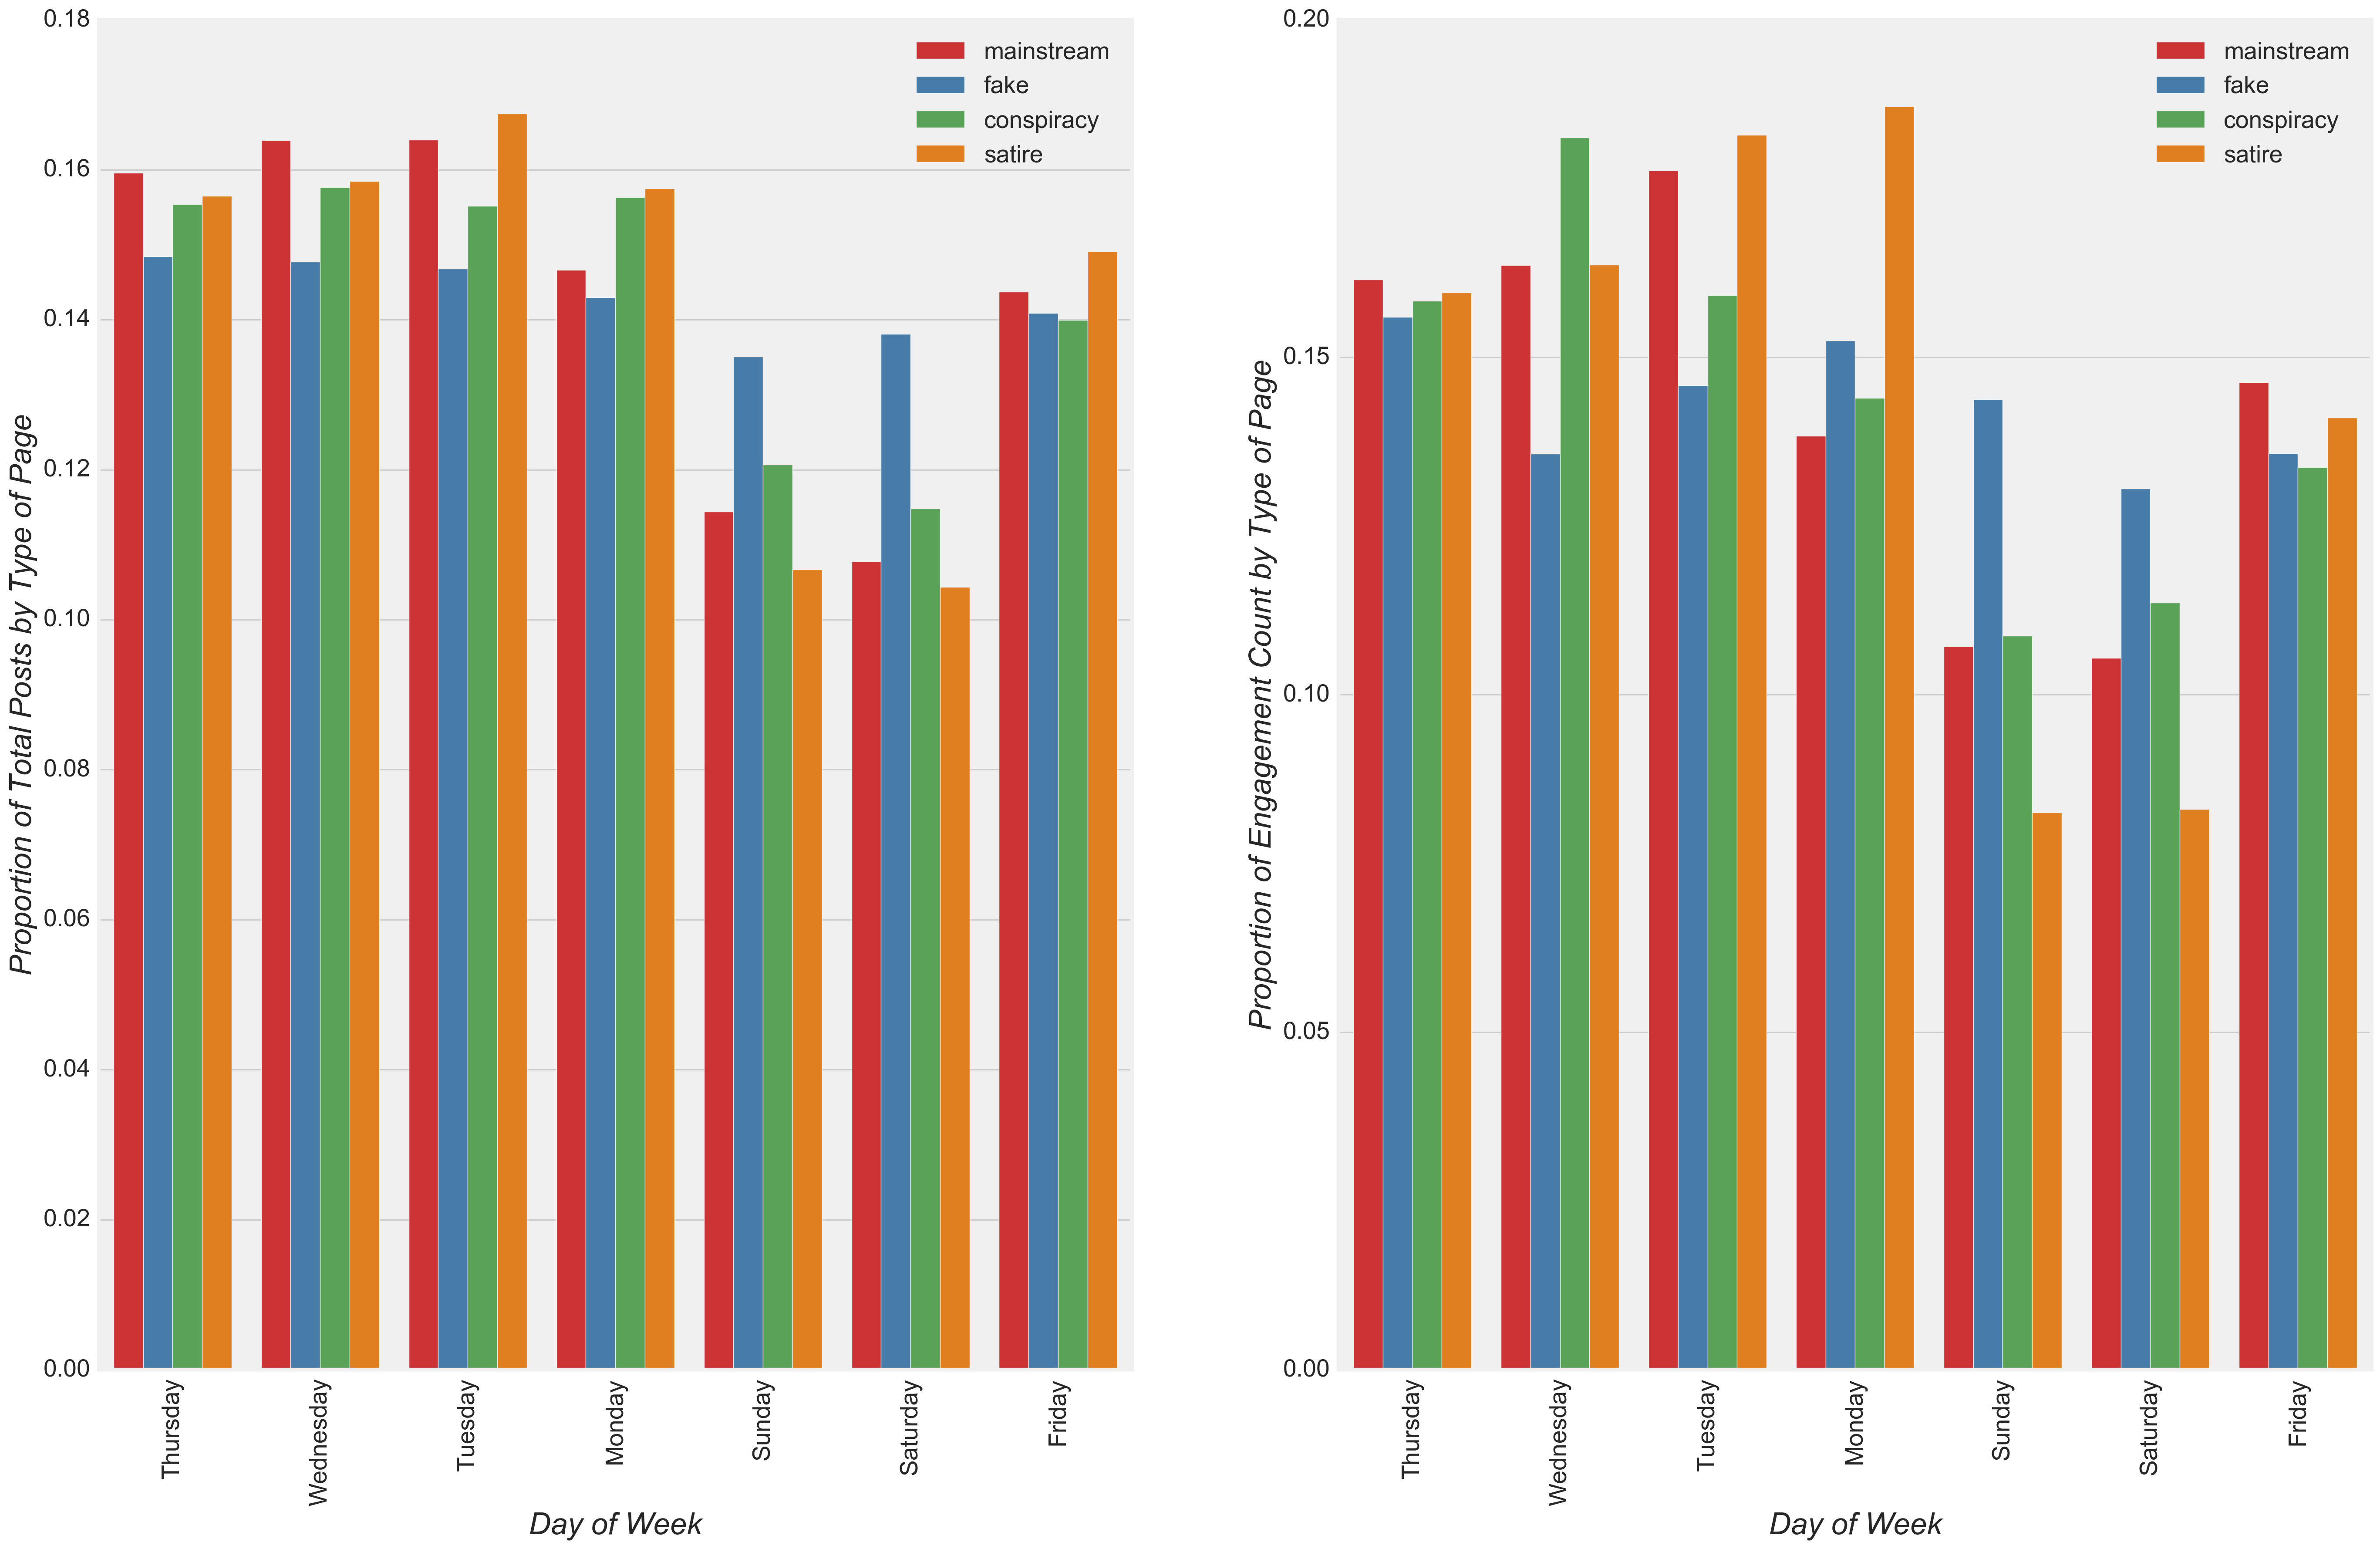

In [27]:
# Plot post count by day of the week as a proportion of total post count
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='day_of_week', y='fraction',hue="type",data=temp,ax=ax0,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("Day of Week",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)

# Plot post engagement count by day of the week as a proportion of total engagement 
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))

sns.barplot(x='day_of_week', y='fraction',hue="type",data=temp,ax=ax1,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("Day of Week",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)

plt.show()

<a name="figure_8"></a>
#### Figure 8
[See EDA Summary for discussion.](#eda_summary)

With respect to the hours of the day, posts showed a peak during working hours when considering the four time zones spanning the lower 48 U.S. states, regardless of the type of news ([Figure 9](#figure_9)). Differences in the posting time were relatively small between the different types of news with the exception of satire news, which showed a considerable peak between 6 am and 12 pm (Pacific Standard Time). With little difference in the pattern of posts over the hours of the day between different types of news with the exception of satire news, model coefficients for hours of the day for mainstream, fake and conspiracy news were expected to be relatively low in comparison to the model coefficient for hours of the day for satire news. Interestingly, engagement levels appeared relatively uniform over the hours of a day in comparison to post hours, indicating widespread engagement among users around the world and/or late night U.S.-based users. Relative to other types of news, engagement levels among conspiracy sites appeared to be most uniform across all times, while engagement levels among satire pages spiked at a time when posts peaked the most, i.e. between 6 am and 7 am.

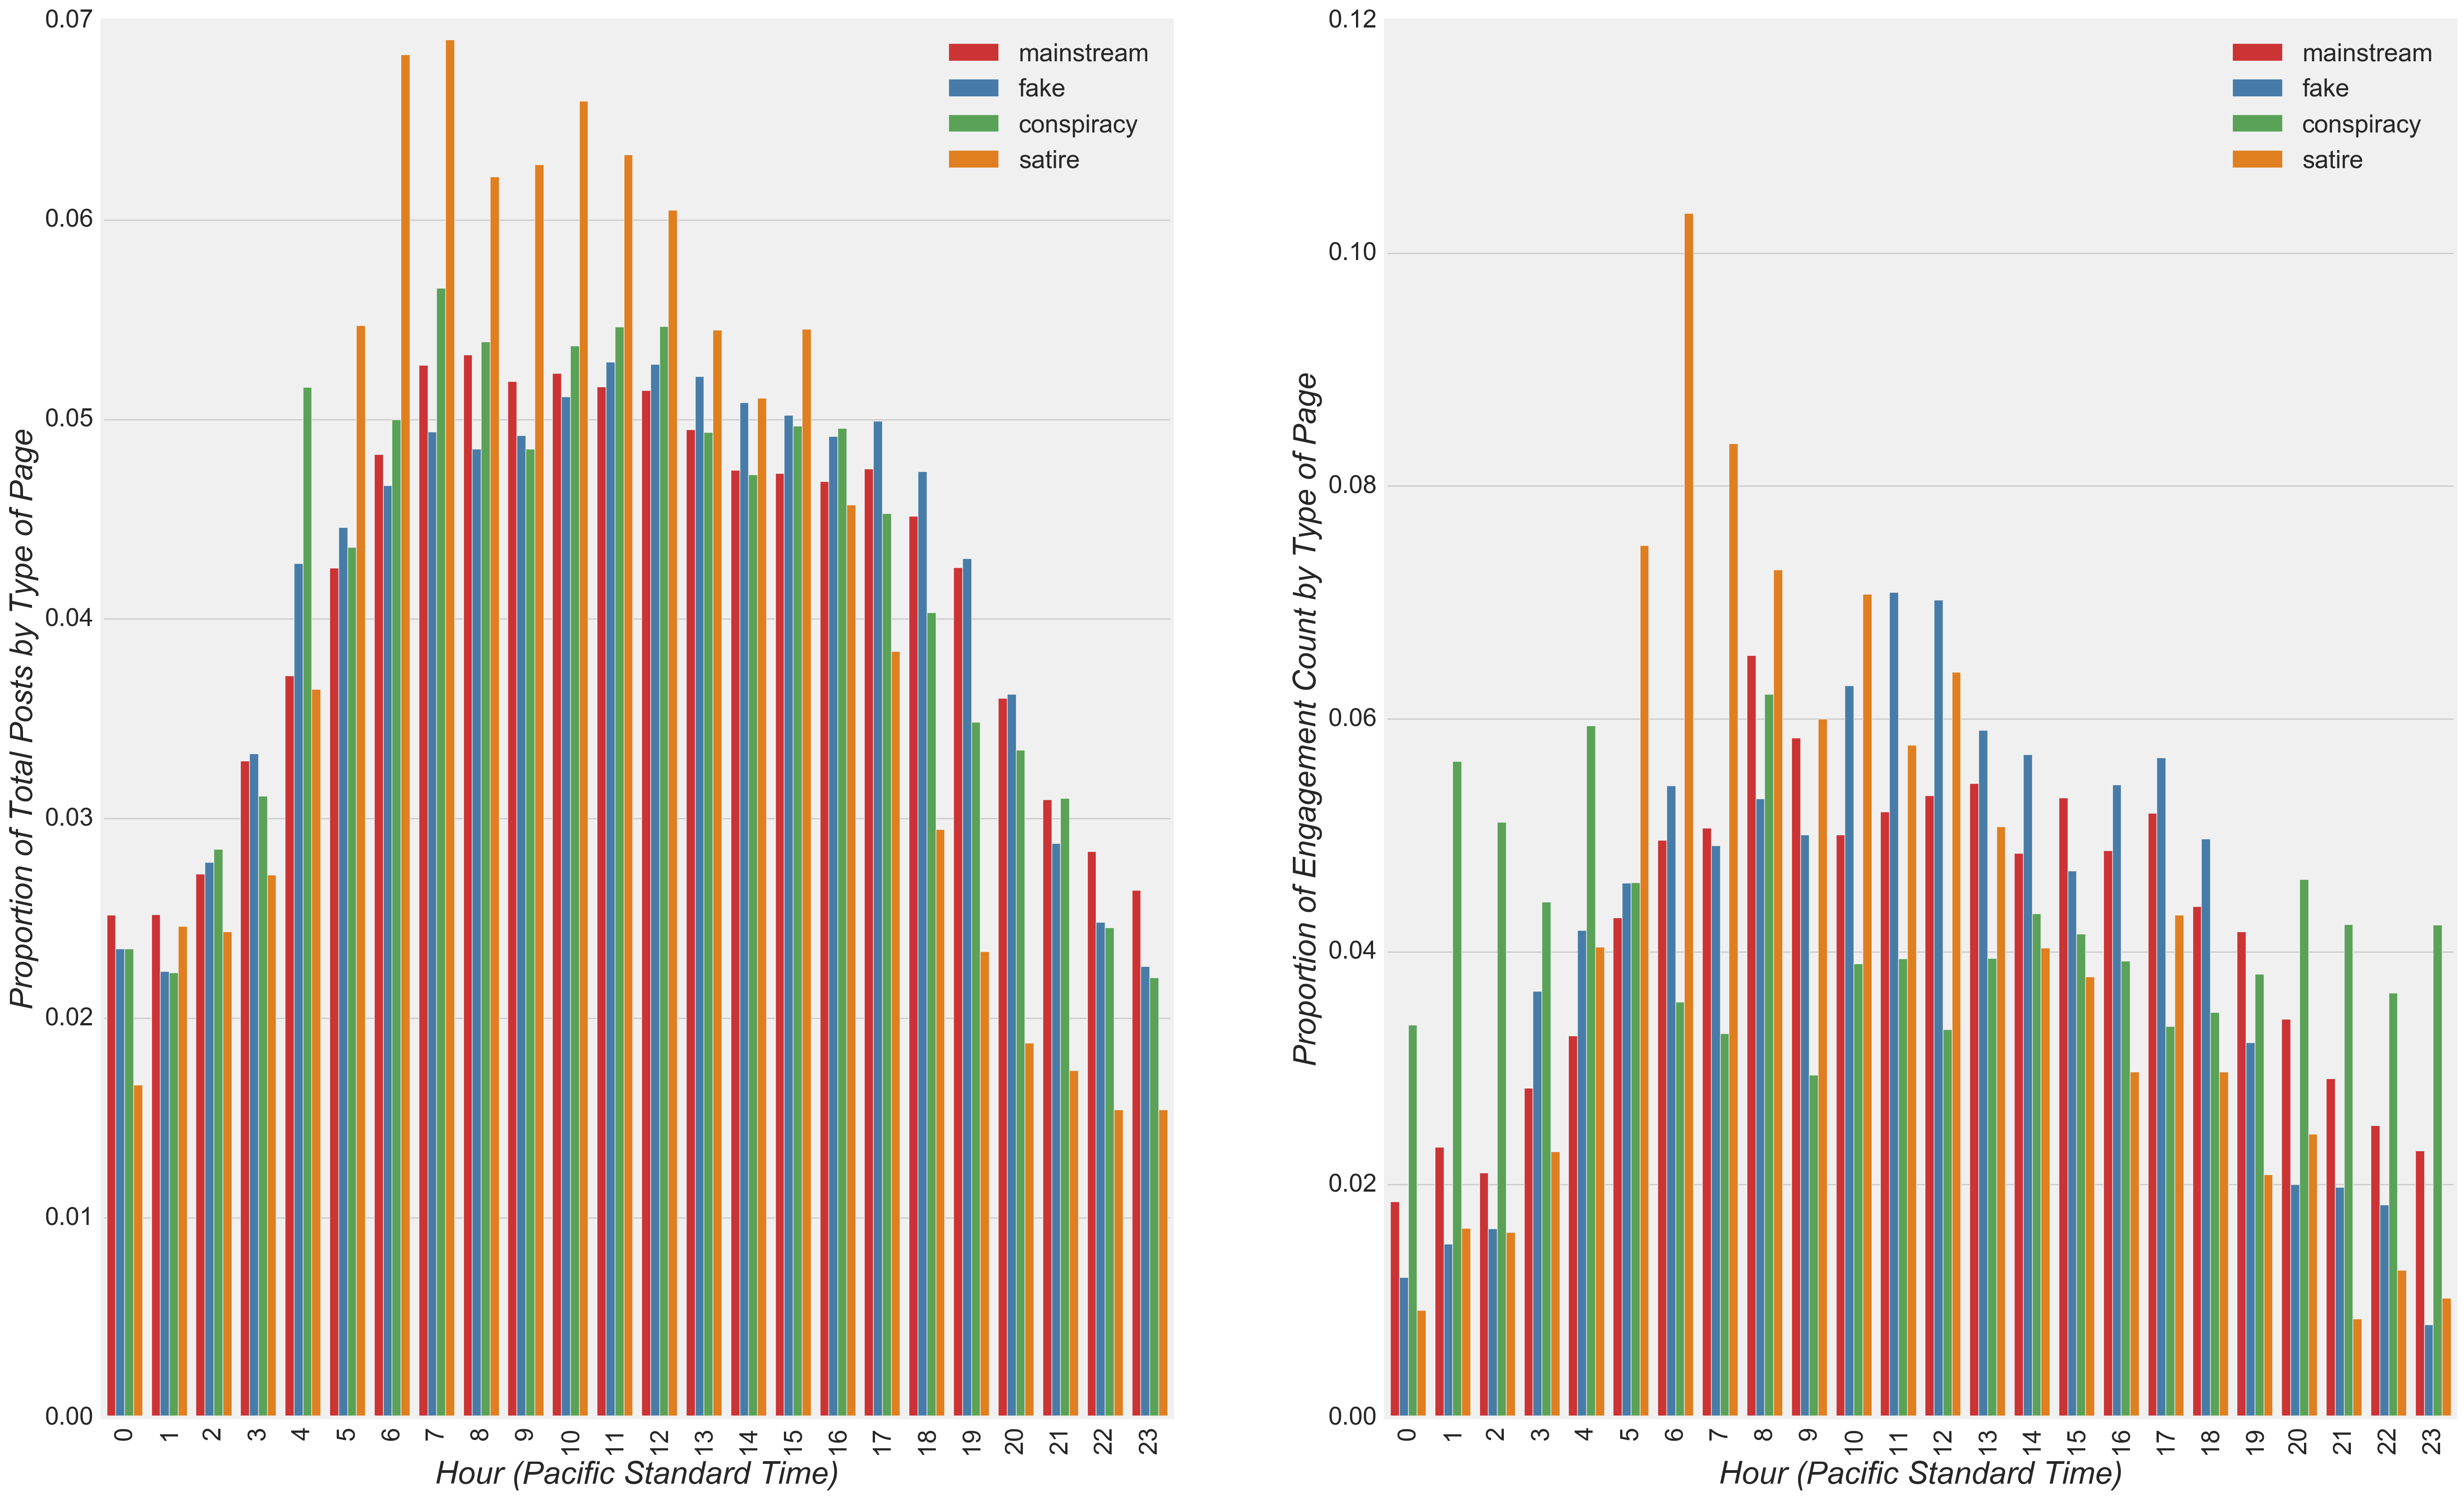

In [205]:
# Plot post counts by hour as a proportion of total post count
temp=fb_news_total
temp['fraction']=0
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=(1./(temp[temp['type']==item].shape[0]))
    
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(30,20))
sns.barplot(x='hour', y='fraction',hue="type",data=temp,ax=ax0,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax0.set_ylabel("Proportion of Total Posts by Type of Page",style='italic',fontsize=25)
ax0.set_xlabel("Hour (Pacific Standard Time)",style='italic',fontsize=25)
ax0.tick_params(axis='both', which='major', labelsize=20)
labels = ax0.get_xticklabels()
plt.setp(labels, rotation=90) 
ax0.legend(fontsize=20)

# Plot post engagement count by hour as a proportion of total engagement count
temp=fb_news_total
temp['fraction']=temp['all_interactions']
for i,item in enumerate(list(temp['type'].unique())):
    temp.ix[temp['type']==item,'fraction']=((1.*temp['fraction'])/(sum(temp.ix[temp['type']==item,'all_interactions'])))

sns.barplot(x='hour', y='fraction',hue="type",data=temp,ax=ax1,estimator=np.sum,ci=False,palette=['#e41a1c','#377eb8','#4daf4a','#ff7f00'])
ax1.set_ylabel("Proportion of Engagement Count by Type of Page",style='italic',fontsize=25)
ax1.set_xlabel("Hour (Pacific Standard Time)",style='italic',fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90) 
ax1.legend(fontsize=20)

plt.show()

<a name="figure_9"></a>
#### Figure 9
[See EDA Summary for discussion.](#eda_summary)

The model also included predictors for each type of engagement activity. To compare differences in the pattern of engagement activities among the different types of news, the value for such a model predictor was the proportion that a specific engagement activity occurred out of the total engagement activity in response to a post. An investigation of engagement activities by type of news and among the most highly engaged pages follows.

Like followed by share were the most common engagement actions in response to a post([Figure 10](#figure_10)), although high variability in engagement actions were observed for all types of news relative to the mean value. Interestingly, satire showed the second highest mean engagement activity but had the lowest total engagement among all types of news. Perhaps unsurprisingly, satire had a noticeably higher mean number of hahas per post compared with the mean number of hahas per post for other types of news. Furthermore, haha was the second or third most common engagement response among individual satire pages ([Figure 11](#figure_11)). Therefore, I expected the final model to show a haha model coefficient for satire that was relatively high compared to the haha coefficients for all other types of news. Nonetheless, more satire posts were needed to better understand and compare with other types of news, because the project dataset contained far fewer satire posts relative to all other types of news ([Figure 10](#figure_10)).

Upon further inspection, other patterns also emerged. Share and comment were the second or third most common engagement actions from satire news pages or highly engaged mainstream news pages, i.e. Fox News. and cnn, but relatively less common as a proportion of other engagement actions among remaining mainstream sources ([Figure 11](#figure_11)). Among fake and conspiracy news, shares again were the second most common engagement type (sometimes the most common), and the proportion of shares in response to fake and conspiracy posts appeared to be greater relative to the proportion of shares among mainstream and satire news. Based on these observations, I expected the final model to have higher share coefficients for fake and conspiracy pages relative to the share coefficients for mainstream and satire pages.

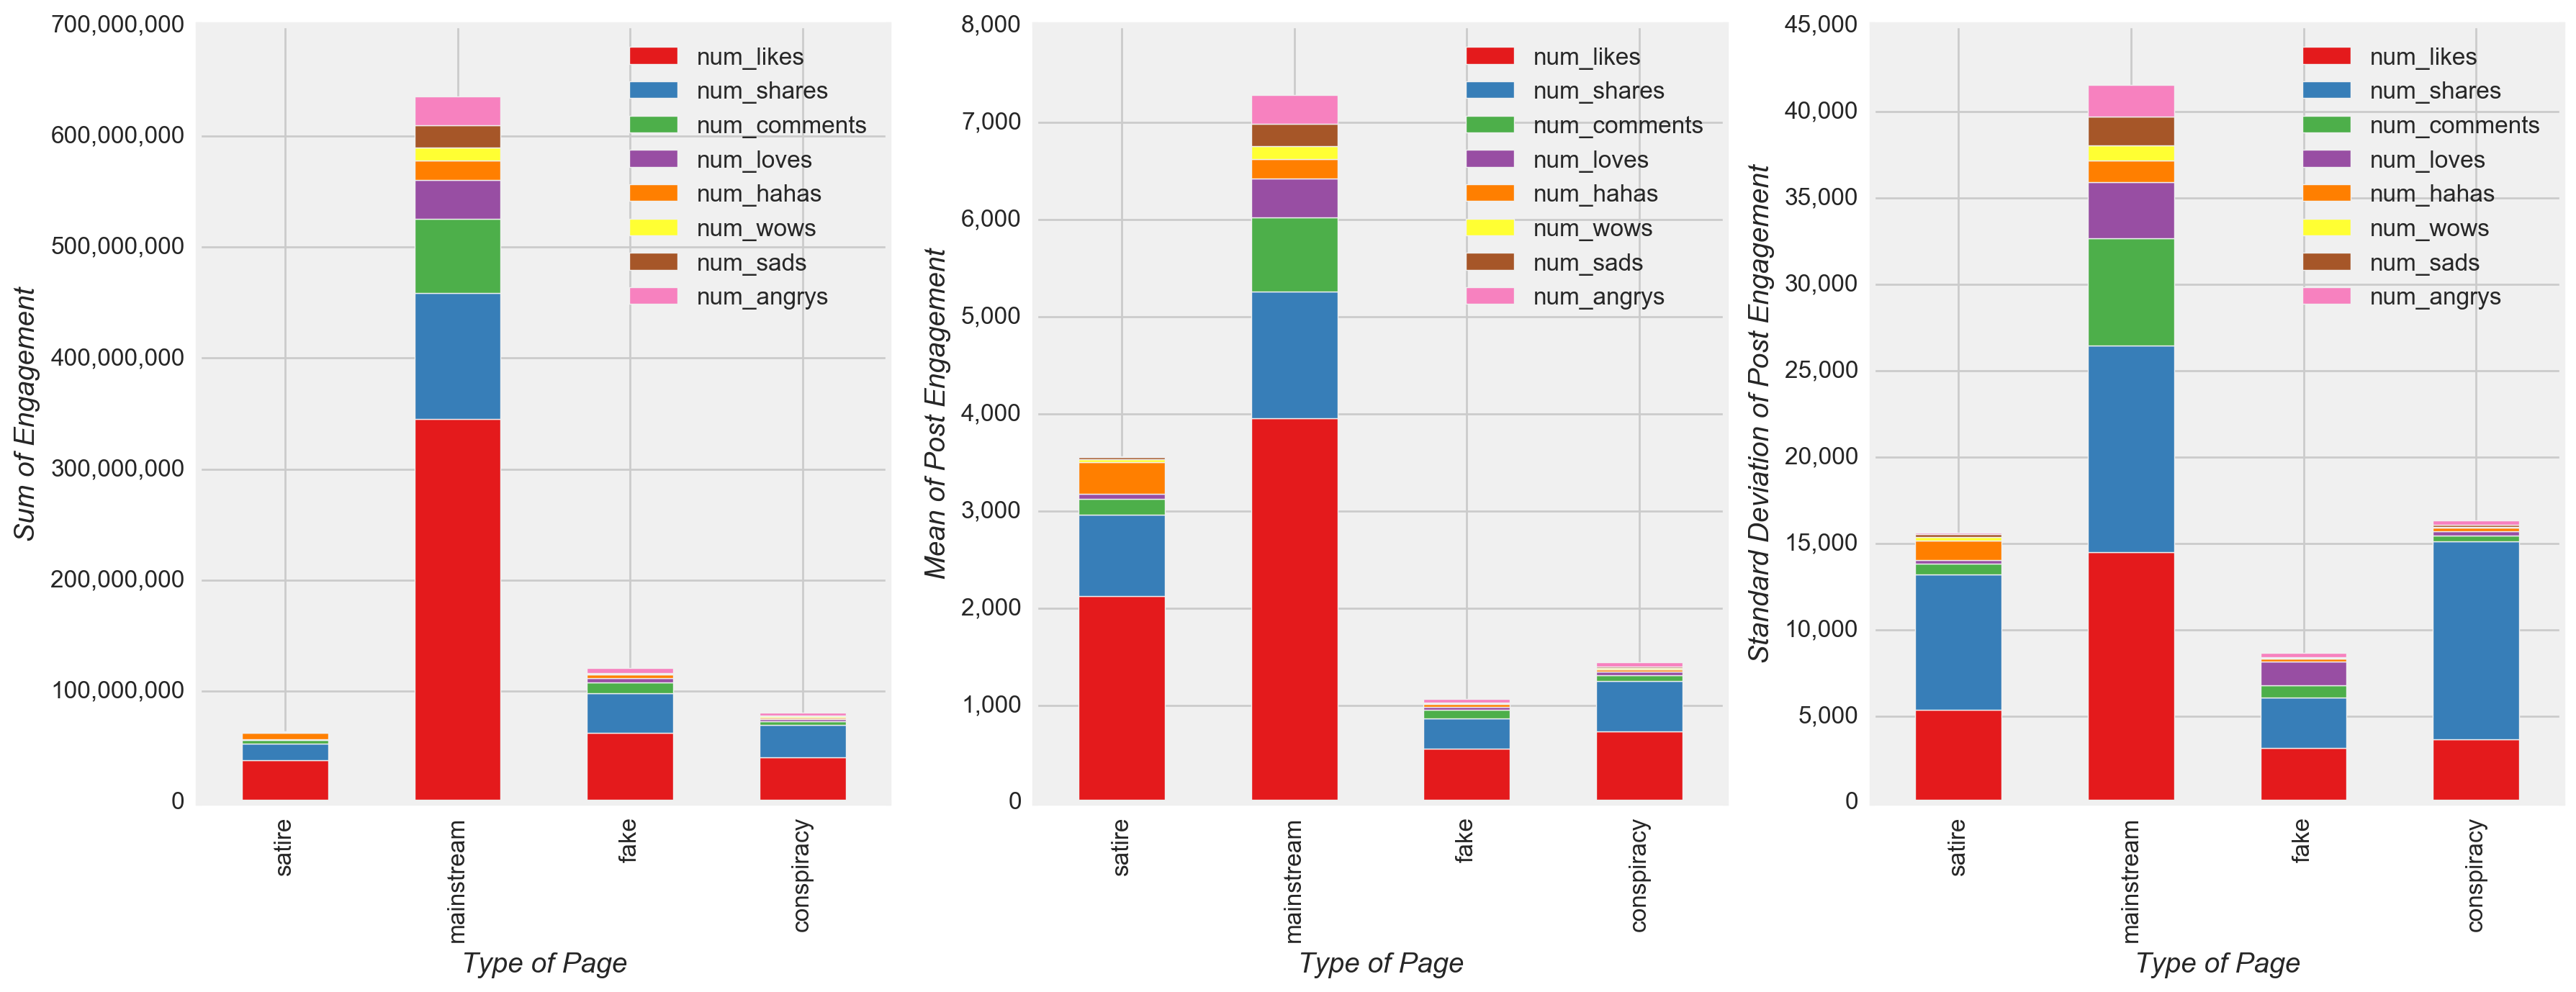

In [30]:
#Plot sum, mean, and standard deviation of engagement by type of page
temp=fb_news_total[['num_likes','num_shares','num_comments','num_loves','num_hahas','num_wows','num_sads','num_angrys']]
temp.set_index(fb_news_total['type'],inplace=True)
temp = temp.groupby(level='type')
means = temp.mean()
means.sort_index(inplace=True,ascending=False)
errors = temp.std()
errors.sort_index(inplace=True,ascending=False)
sums=temp.sum()
sums.sort_index(inplace=True,ascending=False)

fig, ax = plt.subplots(1,3, figsize=(18,7))
sums.plot(kind='bar',ax=ax[0],stacked=True,color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
means.plot(kind='bar',ax=ax[1],stacked=True,color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
errors.plot(kind='bar',ax=ax[2],stacked=True,color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])

ax[0].set_ylabel("Sum of Engagement",style='italic',fontsize=14)
ax[0].set_xlabel("Type of Page",style='italic',fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
ax[0].legend(fontsize=12)

ax[1].set_ylabel("Mean of Post Engagement",style='italic',fontsize=14)
ax[1].set_xlabel("Type of Page",style='italic',fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
ax[1].legend(fontsize=12)

ax[2].set_ylabel("Standard Deviation of Post Engagement",style='italic',fontsize=14)
ax[2].set_xlabel("Type of Page",style='italic',fontsize=14)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
ax[2].legend(fontsize=12)

plt.tight_layout()
plt.show()

<a name="figure_10"></a>
#### Figure 10
[See EDA Summary for discussion.](#eda_summary)

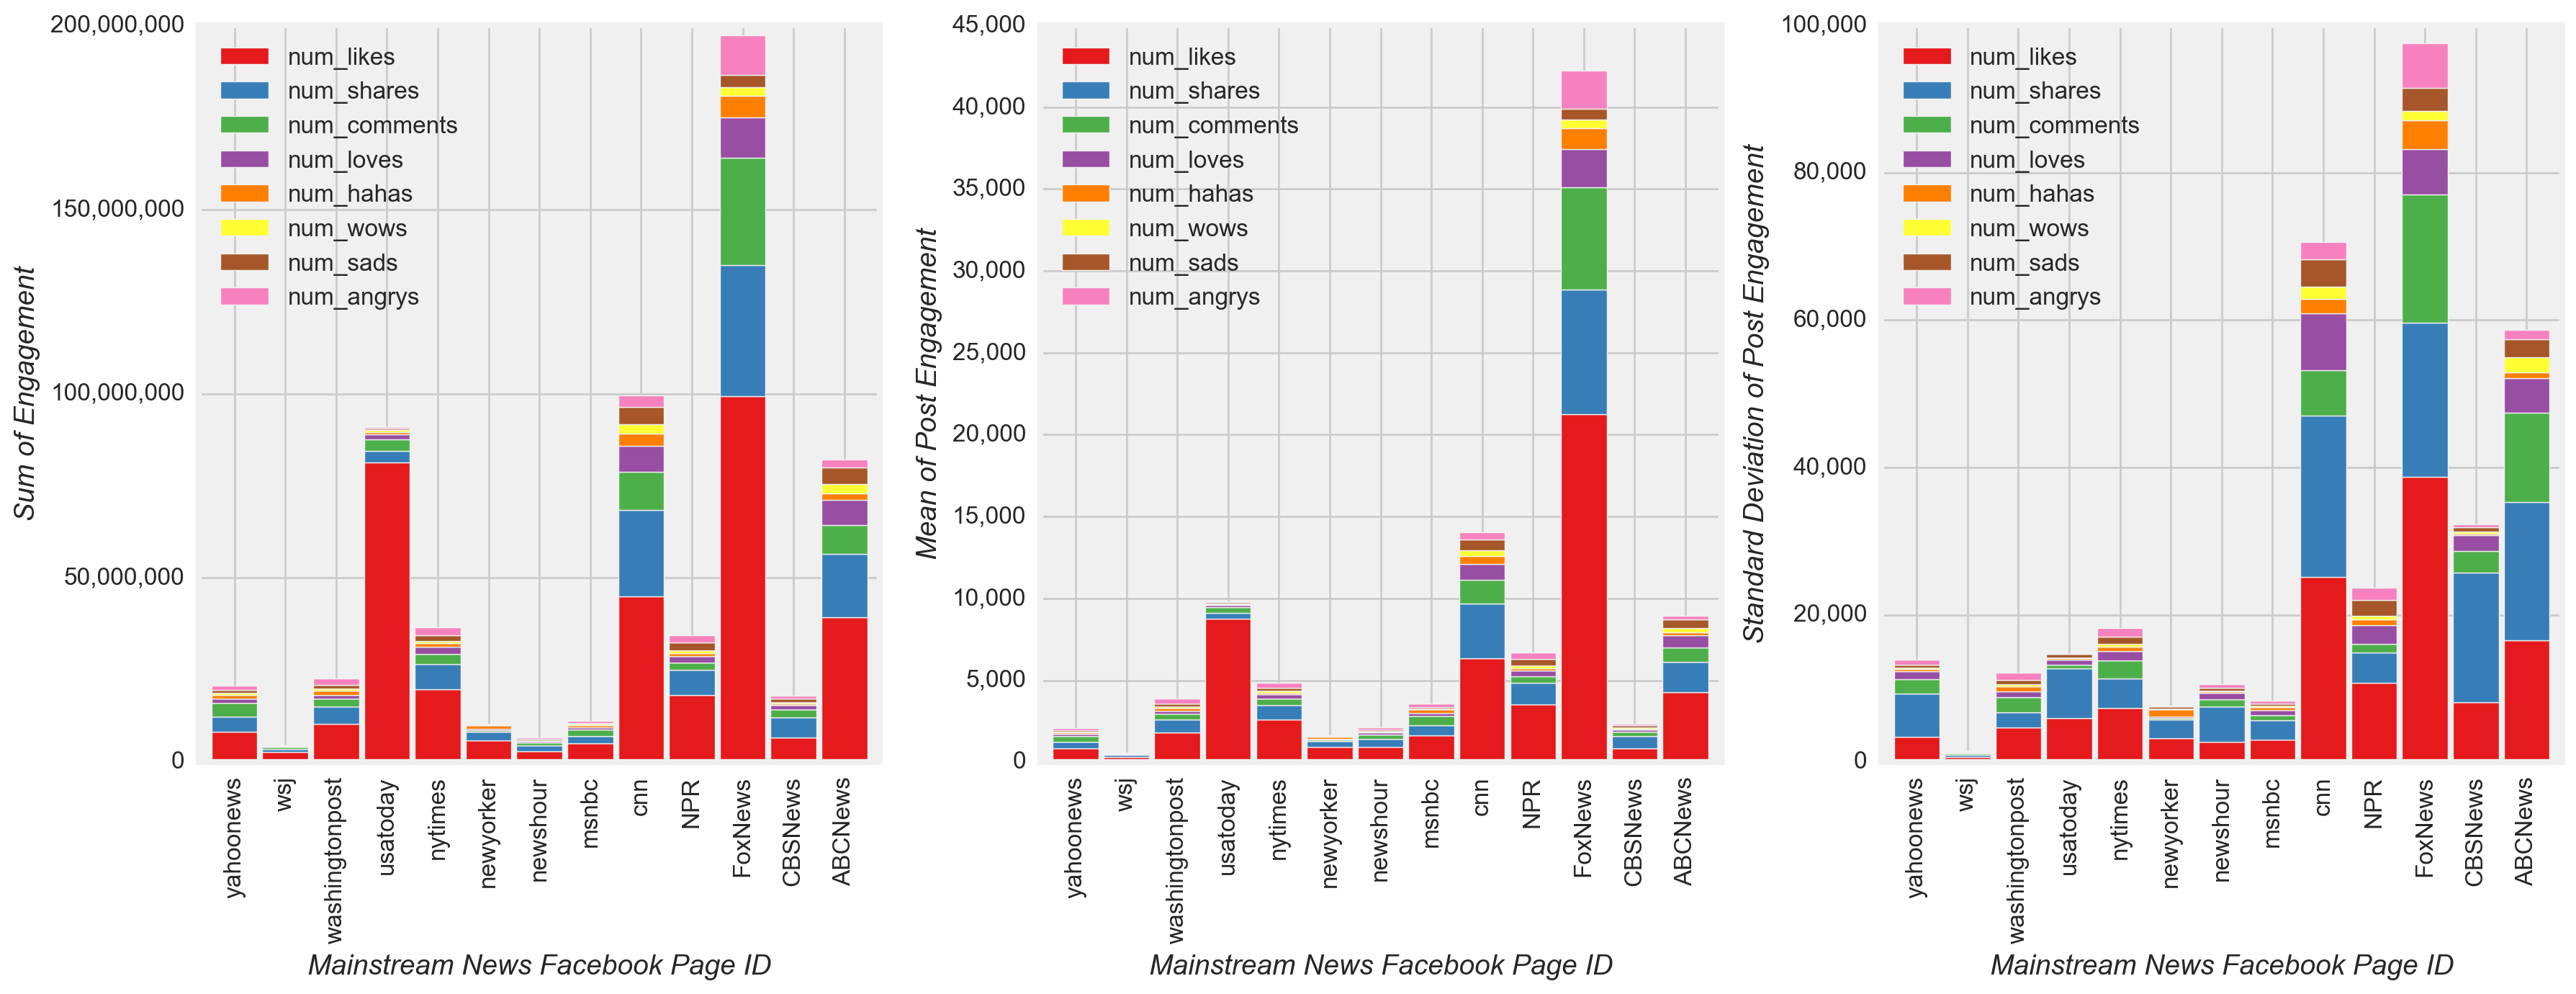

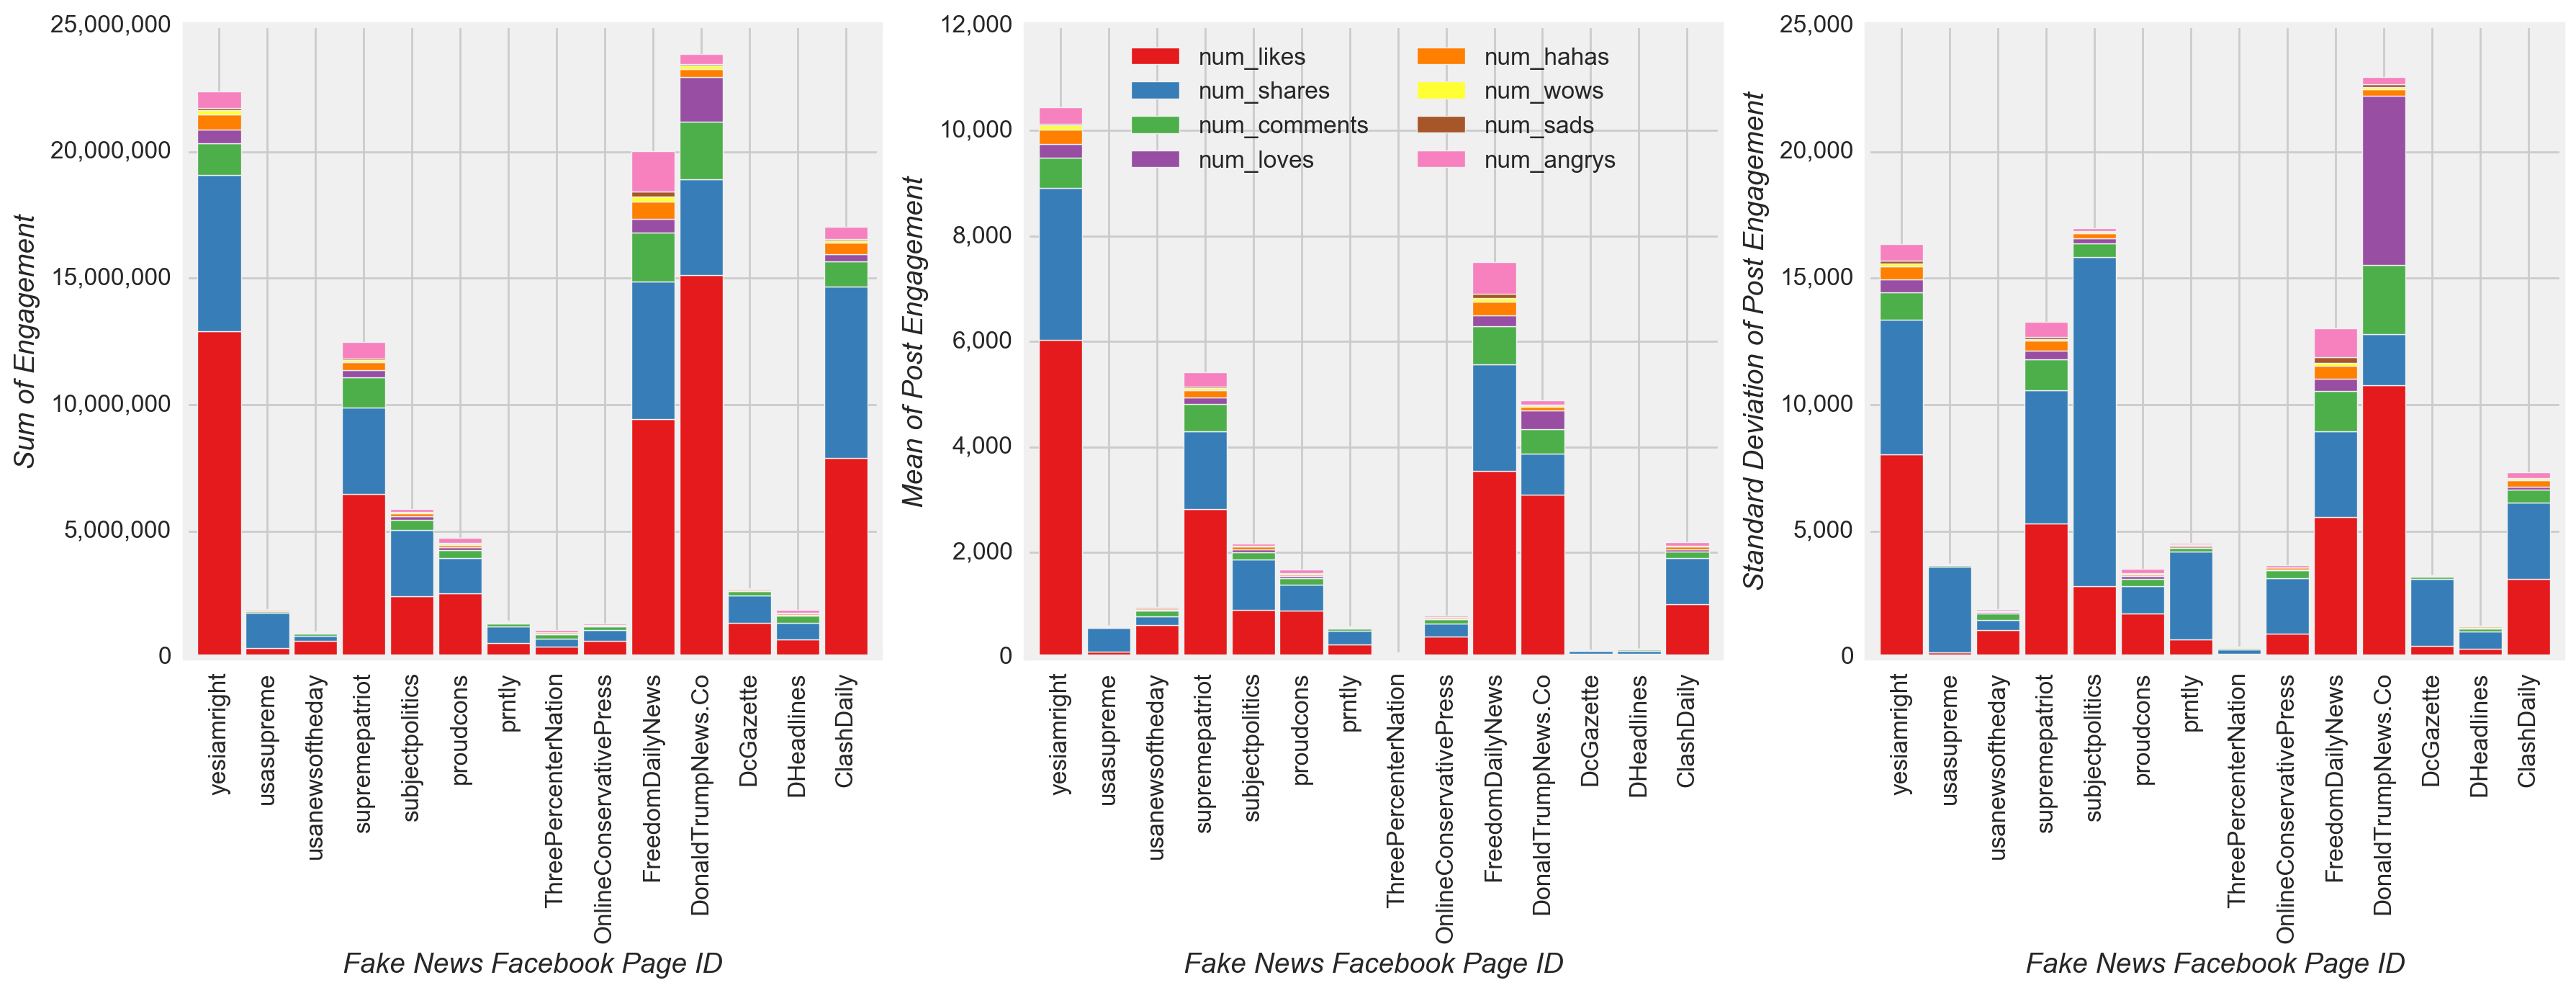

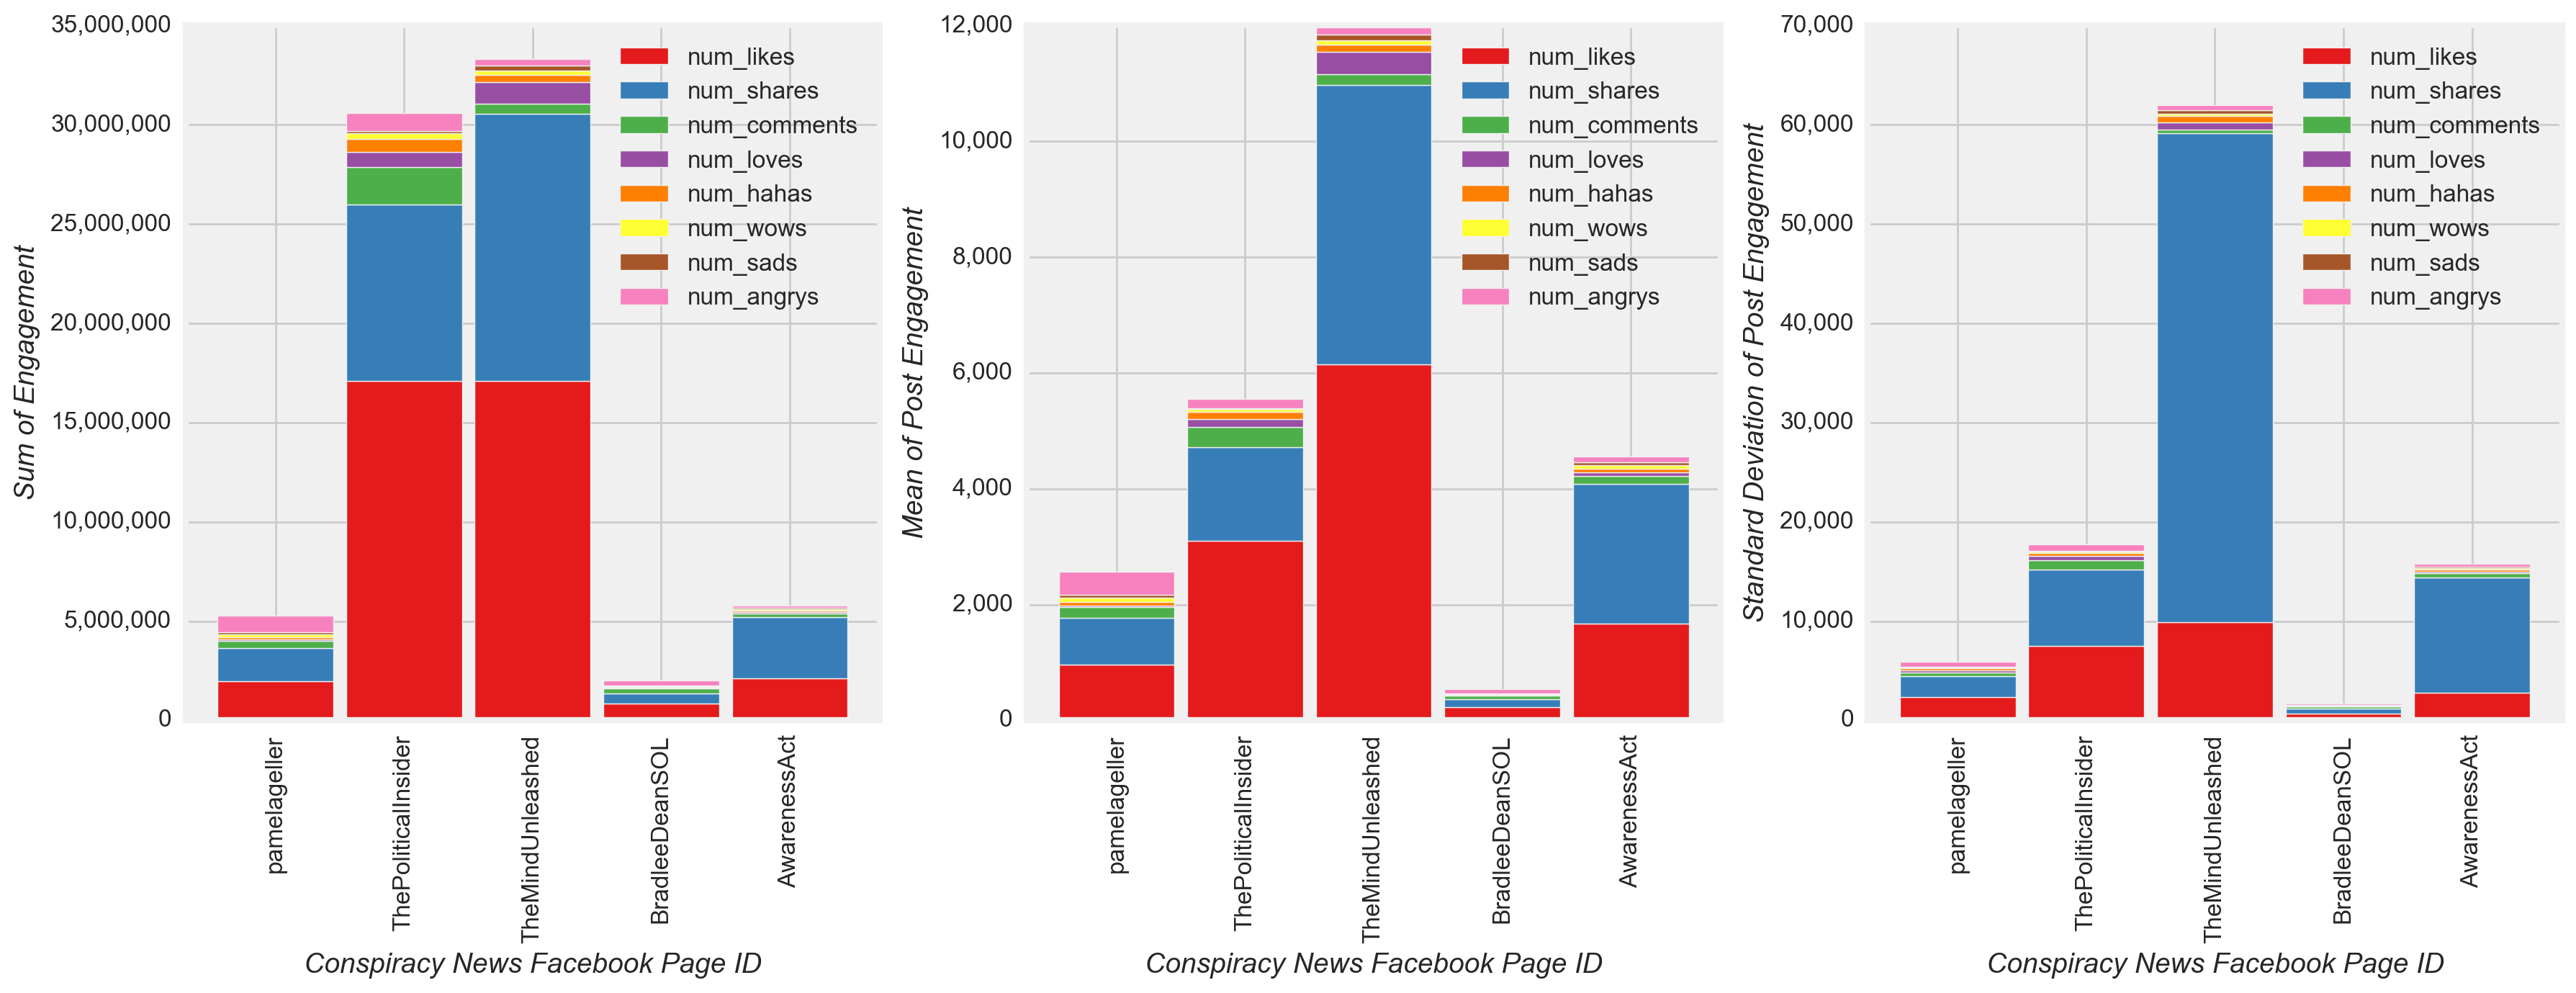

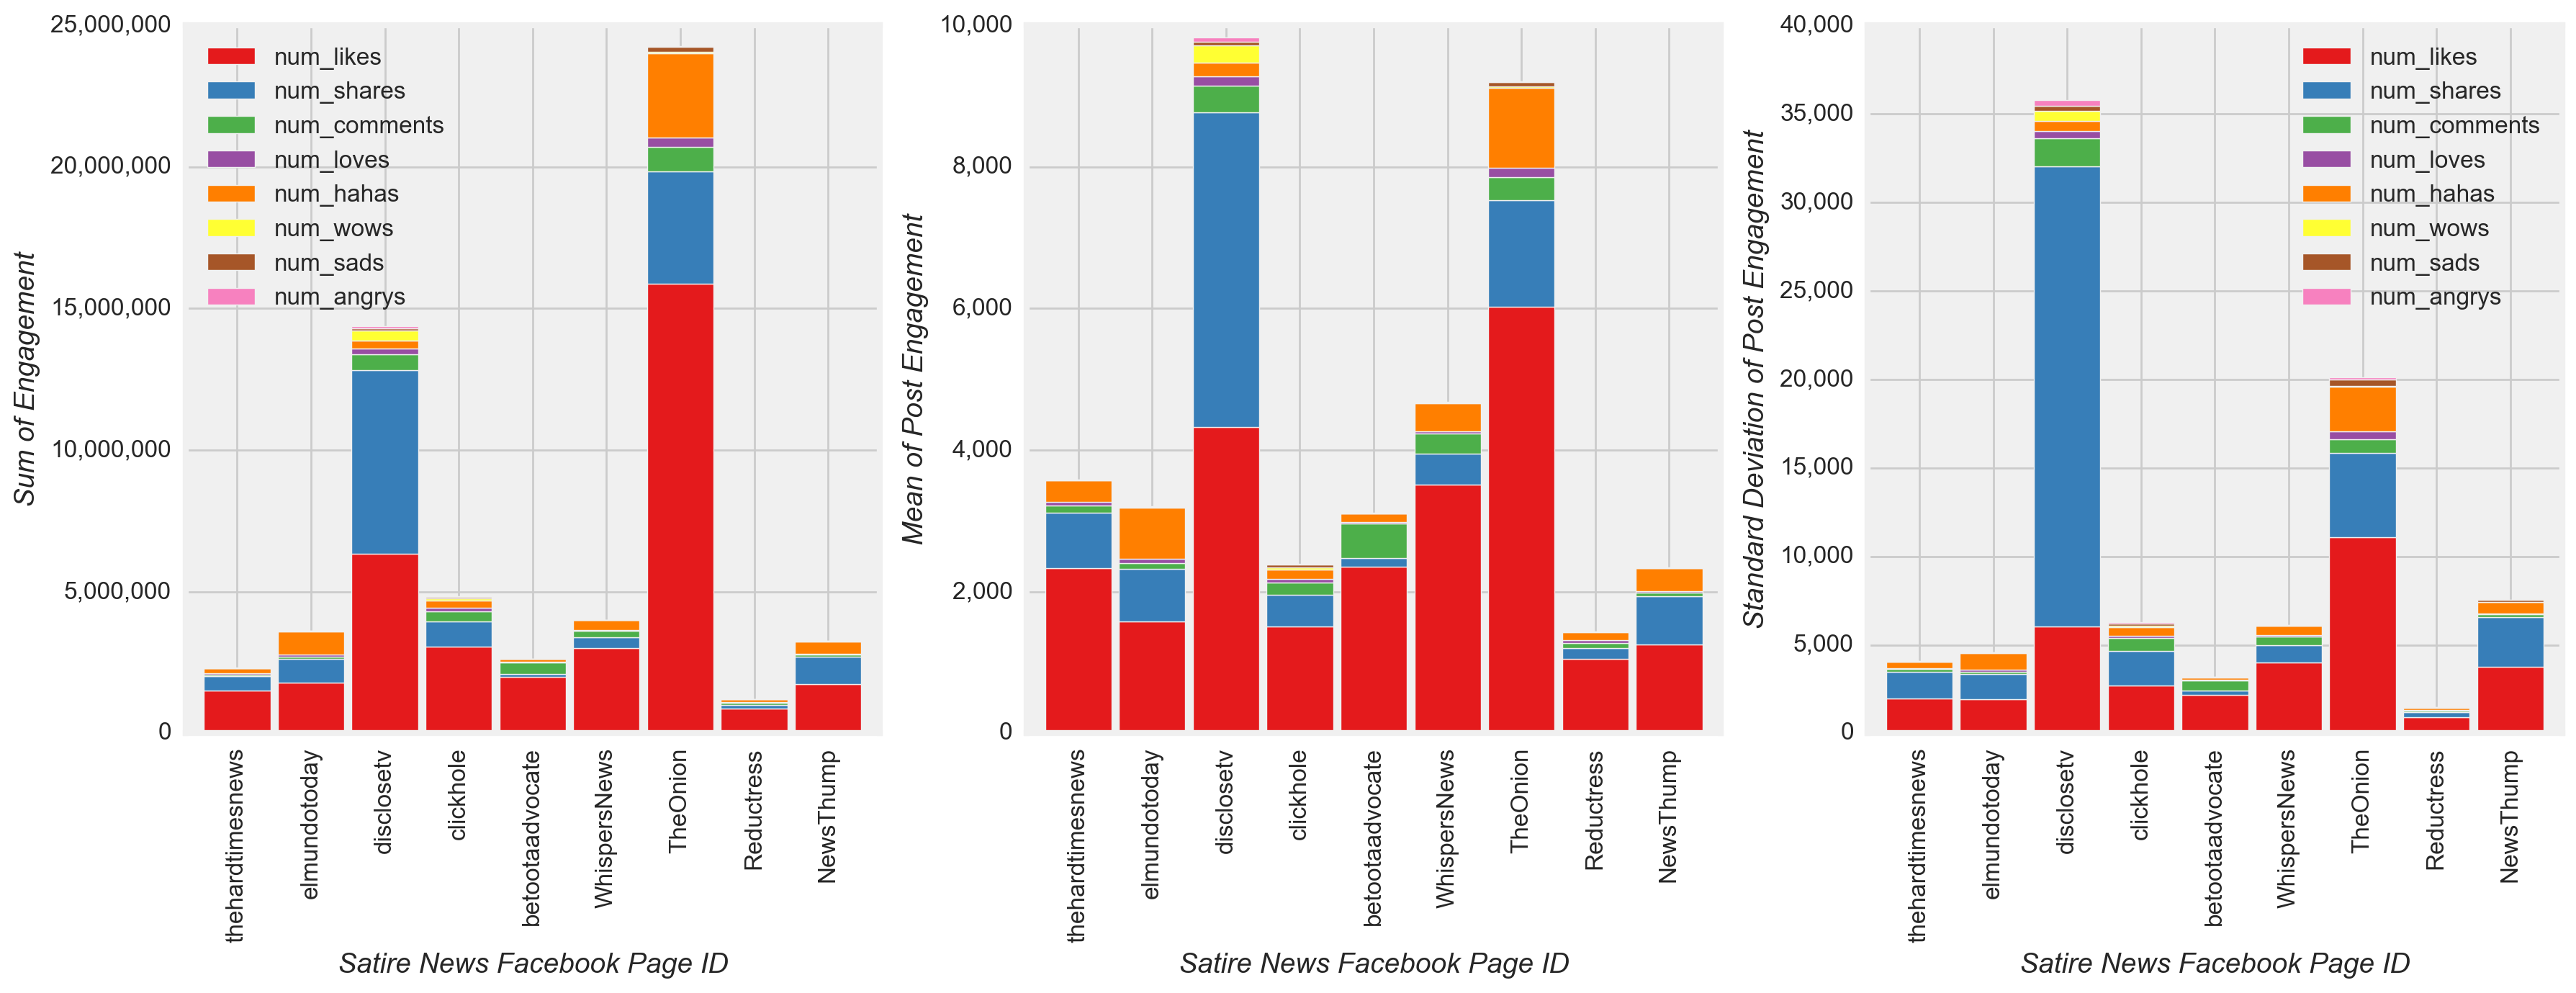

In [31]:
# Plot sum, mean, and standard deviation of engagement by Facebook page
# Only select sources with engagement sum greater than 900,000, i.e. pages with the most engagement 
for i,item in enumerate(fb_news_total['type'].unique()):
    reduced_source_list=fb_news_total[fb_news_total['type']==item].groupby('fb_id')['all_interactions'].sum()[fb_news_total[fb_news_total['type']==item].groupby('fb_id')['all_interactions'].sum()>900000]
    temp=fb_news_total.ix[fb_news_total['type']==item]
    temp=temp[temp['fb_id'].isin(list(reduced_source_list.index))]
    temp2=temp[['num_likes','num_shares','num_comments','num_loves','num_hahas','num_wows','num_sads','num_angrys']]
    temp2.set_index(temp['fb_id'],inplace=True)
    temp2 = temp2.groupby(level='fb_id')
    sums=temp2.sum()
    sums.sort_index(inplace=True,ascending=False)
    means = temp2.mean()
    means.sort_index(inplace=True,ascending=False)
    errors = temp2.std()
    errors.sort_index(inplace=True,ascending=False)
    
    fig, ax = plt.subplots(1,3,figsize=(18,7))
    sums.plot(kind='bar',stacked=True,width = 0.9,ax=ax[0],color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
    means.plot(kind='bar',stacked=True,width = 0.9,ax=ax[1],color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
    errors.plot(kind='bar',stacked=True,width = 0.9,ax=ax[2],color=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'])
    
    ax[0].set_ylabel("Sum of Engagement",style='italic',fontsize=14)
    ax[0].set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
    
    ax[1].set_ylabel("Mean of Post Engagement",style='italic',fontsize=14)
    ax[1].set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
        
    ax[2].set_ylabel("Standard Deviation of Post Engagement",style='italic',fontsize=14)
    ax[2].set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=12)
    ax[2].yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))
      
    if i==1:
        ax[0].legend_.remove()
        ax[1].legend(loc='upper center',fontsize=12,ncol=2)
        ax[2].legend_.remove()
    elif i==2:
        ax[0].legend(loc='upper right',fontsize=12) 
        ax[1].legend(loc='upper right',fontsize=12)
        ax[2].legend(loc='upper right',fontsize=12) 
    elif i==3:
        ax[0].legend(loc='upper left',fontsize=12) 
        ax[1].legend_.remove()
        ax[2].legend(loc='upper right',fontsize=12)        
    else:
        ax[0].legend(loc='upper left',fontsize=12) 
        ax[1].legend(loc='upper left',fontsize=12)
        ax[2].legend(loc='upper left',fontsize=12)
        
    plt.tight_layout()
    plt.show()

<a name="figure_11"></a>
#### Figure 11
[See EDA Summary for discussion.](#eda_summary)

In [192]:
# Extract only the most useful predictors for the model. 
# Convert engagement types to proportion of total engagements for a post
# Convert type of news and days of week to numeric values. Also convert Facebook id to numberic value, but
# only for plotting purposes, not for inclusion in the model.
# Note: Numeric columns that are derived from predictors already extracted for modeling are removed, e.g. all_interactions and num_reactions.
x_subset=fb_news_total[['fb_id','type','day_of_week','status_type','hour','election_day','num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions']]

for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    x_subset.loc[:,i]=(1.0*x_subset.loc[:,i])/x_subset.loc[:,'all_interactions']
    x_subset.loc[x_subset['all_interactions']==0,i]=0

x_subset['type_num']=-999
site_types=list(fb_news_total['type'].unique())
for i,item in enumerate(site_types):
    x_subset.ix[x_subset['type']==item,'type_num']=i

fb_num=pd.Series([-999] * len(x_subset['fb_id']))
sites=list(fb_news_total['fb_id'].unique())
for i,item in enumerate(sites):
    fb_num[x_subset['fb_id']==item]=i   

weekday_types=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

x_subset.loc[:,'num_week_day']=-999

for i,item in enumerate(weekday_types):
    x_subset.loc[x_subset['day_of_week']==item,'num_week_day']=i

x_subset = x_subset.drop(['type','day_of_week','all_interactions','fb_id'], 1)
print sum(x_subset['num_week_day']==-999)
print sum(x_subset['num_comments'].isnull())
print sum(x_subset['type_num']==-999)
print sum(fb_num==-999)

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
0
0
0


Correlations of the main quantitative predictors were examined to determine the appropriate setting for regularization in the final model. When examining correlation heat maps, no strong correlations appeared between engagement activities and/or between time periods (i.e. hour or day of week) regardless of the type of news ([Figure 12](#figure_12)). Therefore, regularization with lasso appeared to be a suitable setting in the final model.

When evaluating correlations for each type of news, mainstream news had relatively high correlations between haha and comment (positive correlation [+]), angry and comment (+), wow and share (+), love and like (+), like and comment (negative correlation [-]), like and share (-), wow and like (-), haha and like (-), sad and like (-), and angry and like (-) ([Figure 13](#figure_13)). Fake news had relatively high correlations between angry and comment (+), and like and share (-). Also, satire news had relatively high correlations like and share (-).

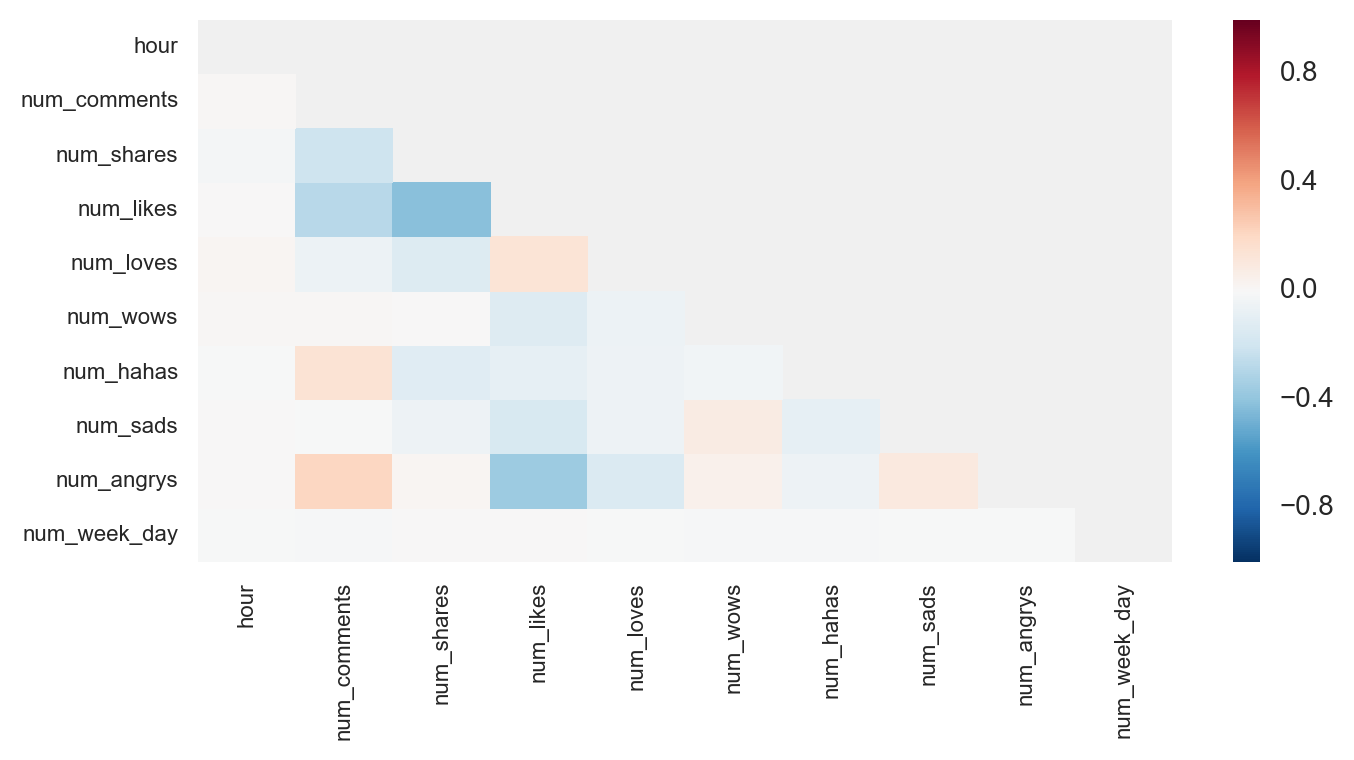

In [92]:
# Plot correlation matrix of the predictors excluding the TF-IDF of words used in the post message
# The code for the heat map below is modified from the General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
temp=x_subset.drop(['type_num'], 1)
corrs = temp.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(7,3.5))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=8, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=8, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a name="figure_12"></a>
#### Figure 12
[See EDA Summary for discussion.](#eda_summary)

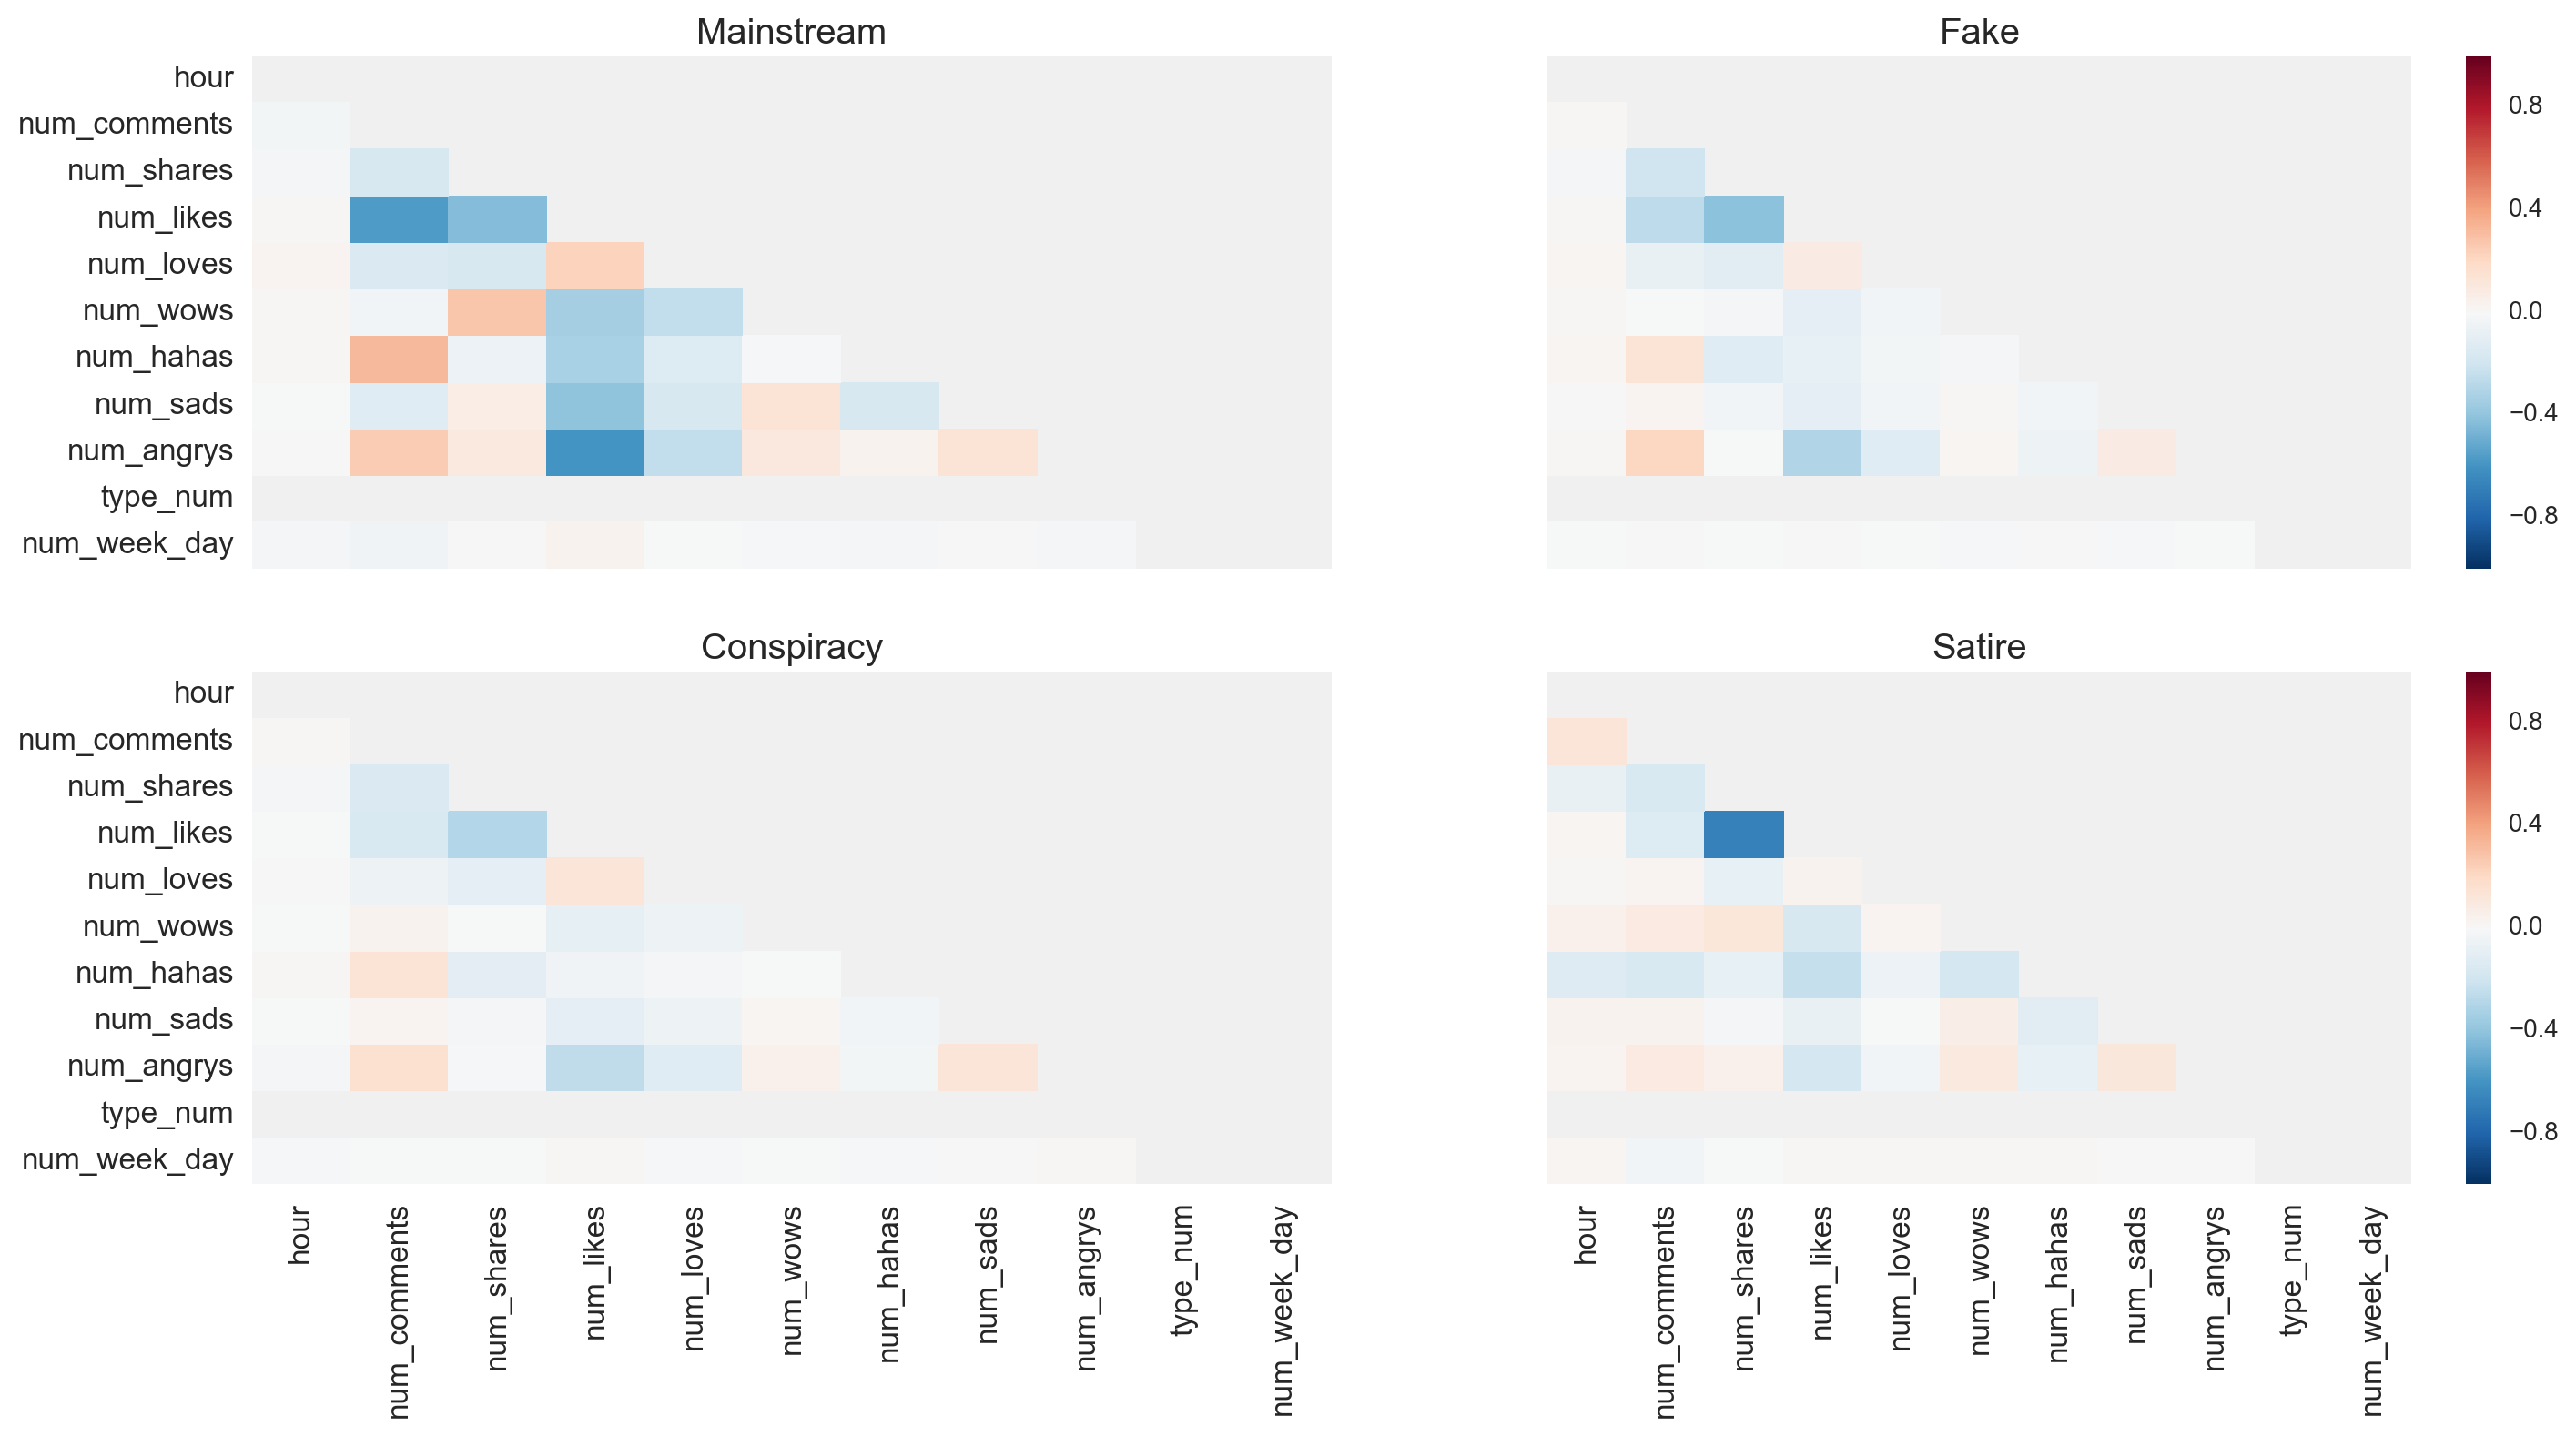

In [175]:
# Plot the correlation matrices of the predictors for each type of news excluding the TF-IDF of words used in the 
# post message
# The code for the heat map below is modified from the General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
grouped = x_subset.groupby('type_num')
rowlength = grouped.ngroups/2 # fix up if odd number of groups
fig, axs = plt.subplots(figsize=(15,8), nrows=2, ncols=rowlength)
targets = zip(grouped.groups.keys(), axs.flatten())
site_types=['Mainstream','Fake','Conspiracy','Satire']

for i, (key, ax) in enumerate(targets):
    mask= np.zeros_like(grouped.get_group(key).corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    if ((i==1) | (i==3)):
        plot=sns.heatmap(grouped.get_group(key).corr(), ax=ax,xticklabels=(i >= rowlength),yticklabels=(i%rowlength==0),
                         cbar=True,mask=mask) 
        plot.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
        plot.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)
    else:
        plot=sns.heatmap(grouped.get_group(key).corr(), ax=ax,
                         xticklabels=(i >= rowlength),yticklabels=(i%rowlength==0),
                         mask=mask,cbar=False) 
    ax.set_title(site_types[i])
    plot.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
    plot.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

<a name="figure_13"></a>
#### Figure 13
[See EDA Summary for discussion.](#eda_summary)

The remaining predictors included in the model were important monograms and bigrams selected from post messages for each type of news. These n-grams were selected such that the maximum number of distinct words used in post messages were extracted as well as the most commonly used words that were unique among each type of news. Nonetheless, only 2% (mainstream) to 29% (satire) of all posts actually contained message text depending on the type of news. Therefore, the inclusion of monograms and bigrams in the model risked adding a considerable amount of noise, given that the training set was considerably smaller than the number of posts in the training dataset. Hence, the coefficients associated with important monograms and bigrams in the final model were reviewed with a greater degree of skepticism than with the previously discussed model predictors and not discussed in the model evaluation.

In [37]:
# Show fraction of posts without messages
print 'Fraction of posts without message text: ',round((1.0*sum(fb_news_total['status_message']==""))/fb_news_total.shape[0],4)

Fraction of posts without message text:  0.0828


In [38]:
# Show fraction of posts with messages by page type
temp=fb_news_total
temp['message_state']=0
for i,item in enumerate(list(fb_news_total['type'].unique())):
    temp.ix[((temp['type']==item) & (temp['status_message']=="")),'message_state']=1./sum(temp['type']==item)


print "Count of posts with no messages as a fraction of total posts by type"
print temp.groupby('type')['message_state'].sum().sort_values(ascending=False)

Count of posts with no messages as a fraction of total posts by type
type
satire        0.285372
conspiracy    0.130598
fake          0.073066
mainstream    0.023369
Name: message_state, dtype: float64


<a name="eda_summary"></a>
### EDA Summary

- Only a handful of pages posted and received the majority of the engagement regardless of the type of news ([Figure 3](#figure_3)).
- With respect to the second most frequent type of attachment in posts, mainstream pages posted videos more frequently than all other types of news ([Figure 4](#figure_4)).
- The most drastic change in posting volume occurred in the form of a reduction in fake news after the election, in large part due to a reduction in post volume among the top three most prolific sources ([Figure 5](#figure_5) and [Figure 6](#figure_6)).
- Regardless of the type of news, a noticeable dip in the volume of posts and engagement activity levels occurred on Saturday and Sunday relative to other days of the week ([Figure 8](#figure_8)).
- Posts peaked during working hours when considering the four time zones spanning the lower 48 U.S. states irregardless of the type of news ([Figure 9](#figure_9)).
- Perhaps unsurprisingly, satire had a noticeably higher mean number of hahas per post compared with the mean number of hahas per post for other types of news ([Figure 10](#figure_10)).
- The proportion of shares in response to fake and conspiracy posts appeared to be greater relative to the proportion of shares among mainstream and satire news ([Figure 11](#figure_11)).

<a name="logistic_regression_model"></a> 
## Logistic Regression Model

<a name="message_post_nlp"></a> 
#### Mongram and Bigram Selection from Post Messages

The generation of important monograms and bigrams from Facebook message text is a key part of the model described in the objective. In detail, three steps were followed to generate the list of important monograms and bigrams from post messages. First, four lists of the most frequent 6,000 words for each type of news were generated using a count vectorizer. Next, values that represent the importance of words in a Facebook message considering the collection of messages from Facebook posts (a.k.a the frequency inverse document frequency (TF-IDF) of a word) were calculated and the 6,000 words with the highest TF-IDF scores were selected. The number of words was reduced again by selecting only frequently used words, but unique in usage to only one of the four types of news. The resulting list contained only 793 words. The list was further reduced to 505 words to remove meaningless words or ones that were closely associated with an individual page (e.g. the name of the page or the host of a particular news program).

In [12]:
# All urls are removed from post messages to avoid selecting when identifying important monograms and 
# bigrams from post messages. 
def clean_text(text):
    try:
        text=re.sub(r'[-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)?', '', text)
        return text
    except:
        return text
    
fb_news_total['status_message']=fb_news_total['status_message'].map(clean_text)

In [13]:
# Initiate the TF-IDF model class. min_df and max_features are set by trial and error, i.e. determining the signal 
# in the words selected versus the noise
tfv=TfidfVectorizer(ngram_range=(1,2),strip_accents='unicode',lowercase=True,stop_words=en.STOPWORDS,min_df=0.00001,max_features=6000)

In [16]:
# Assemple the matrix listing the TF-IDF value in descending order by word on a post by post level. Each column 
# in the matrix is a word and the number and order of rows corresponds to the posts analyzed for the project
X_all = tfv.fit_transform(fb_news_total['status_message'])
x_df=pd.DataFrame(X_all.toarray(), columns=tfv.get_feature_names())
tf_df  =  pd.DataFrame(x_df.mean(), columns=["tfidf_value"])
all_posts_tfidf=tf_df.sort_values("tfidf_value",ascending=False)

In [17]:
# Repeat the following code for each type. This example code is only valid for mainstream. 
# Use the CountVectorizer to find ngrams
vect = CountVectorizer(ngram_range=(1,2),strip_accents='unicode',lowercase=True,stop_words=en.STOPWORDS,)

# Pull all of text's into one giant string and then list the most frequently used words by news type
# The code for doing this task is modified from General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)
summaries = "".join(fb_news_total.ix[fb_news_total['type']=='mainstream','status_message'])
ngrams_summaries = vect.build_analyzer()(summaries)

mainstream_freq=Counter(ngrams_summaries).most_common(6000)
mainstream_most_freq_list=[]
for i in range(0,6000):
    mainstream_most_freq_list.append(str(mainstream_freq[i][0]))

In [ ]:
# Assemble list of most frequently used words by news type, but also unique to that type for selecting words
# in the complete TF-IDF list generated for each post
all_posts_tfidf=[str(i) for i in list(all_posts_tfidf.reset_index()['index'])]

temp1=[x for x in all_posts_tfidf if (x in mainstream_most_freq_list) and (x not in fake_most_freq_list) 
       and (x not in conspiracy_most_freq_list) and (x not in satire_most_freq_list)]
temp2=[x for x in all_posts_tfidf if (x in fake_most_freq_list) and (x not in mainstream_most_freq_list) 
       and (x not in conspiracy_most_freq_list) and (x not in satire_most_freq_list)]  
temp3=[x for x in all_posts_tfidf if (x in conspiracy_most_freq_list) and (x not in mainstream_most_freq_list) 
       and (x not in fake_most_freq_list) and (x not in satire_most_freq_list)]
temp4=[x for x in all_posts_tfidf if (x in satire_most_freq_list) and (x not in mainstream_most_freq_list) 
       and (x not in conspiracy_most_freq_list) and (x not in fake_most_freq_list)]
all_posts_tfidf=temp1+temp2+temp3+temp4    

In [193]:
# Load the refined version of the all_posts_tfidf object
with open('/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/nlp_text.pkl', 'r') as f:
    nlp_text = pickle.load(f)

In [194]:
# Drop additional words for the reasons stated in the bullets above
nlp_text.drop(labels=['activist post', 'visit reality', 'shares support', 'newsletter read',
                      'insists','behold','david books','chuck','debbie','checked',
                      'swipe','wheel','friends weekend',
                      'packing','schwartz','sunday night','elect mike','stretch','lamont',
                      'bundle','rosie','bat','consciously','chronicles manila','unto'],axis=1,inplace=True)

In [51]:
# Print final shape of word TFIDF matrix
nlp_text.shape

(274618, 505)

<a name="model_building"></a>  
#### Model Building

A logistic regression model was selected in this project in order to categorize the news by type using categorical and numeric predictors. Compared to other models such as Naive Bayes, regression models generate coefficients with magnitudes indicating relative importance of predictors. All default settings for the logistic regression model in Scikit-Learn were maintained except for the specification of lasso regularization as justified above and an increase in the maximum number of iterations for model convergence.

In [195]:
# Assemble the predictor matrix and target vector for the model
f = 'type_num ~ '+' + '.join([c for c in x_subset.columns if not c == 'type_num'])+' -1'
y, X = patsy.dmatrices(f, data=x_subset, return_type='dataframe')
X=X.join(nlp_text)
coefs_columns=X.columns
X=X.values
y = y.values.ravel()

In [196]:
# Standardize the predictor matrix because regularization is used in the model
ss = StandardScaler()
Xn = ss.fit_transform(X)
Xn=np.concatenate((np.array([list(fb_num)]).T,Xn),axis=1)
print "Shape: ",Xn.shape

Shape:  (274618, 524)


In [197]:
# Train-test split with 30% of the original posts used for testing
# split dataset into test, train
xtr, xte, ytr, yte = train_test_split(Xn, y, test_size=0.3,random_state=42)
fb_id_xte=list(xte[:,0])
fb_id_xtr=list(xtr[:,0])
xtr=xtr[:,1:]
xte=xte[:,1:]

print "Train shape: ",xtr.shape
print "Test shape: ",xte.shape

Train shape:  (192232, 523)
Test shape:  (82386, 523)


In [198]:
# Remove unnecssary fb_id column from Xn 
Xn=Xn[:,1:]

In [199]:
# Initiate multiclass logistic regression
logreg = LogisticRegression(multi_class='ovr', max_iter=300, random_state=42,tol=0.0001,C=1.0, penalty='l1')

In [200]:
# Run a 5-fold cross-validation on the test-train split
# The code for doing this task is modified from General Assembly Data Science Immersive Cohort 4 
# Class (Nov 2016-Feb 2017)

cv_indices = StratifiedKFold(ytr, n_folds=5)

lr_scores = []

for train_inds, test_inds in cv_indices:
    
    xtr_subset, ytr_subset = xtr[train_inds, :], ytr[train_inds]
    xte_subset, yte_subset = xtr[test_inds, :], ytr[test_inds]
    
    logreg.fit(xtr_subset, ytr_subset)
    lr_scores.append(logreg.score(xte_subset, yte_subset))

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)

Logistic Regression:
[0.57070772752100296, 0.56844487216167716, 0.57346476968294013, 0.56786141601206885, 0.57237612173234487]
0.570570981422


<a name="model_evaluation"></a>
### Model Results and Evaluation

The final model performed with a promising degrees of success. A 57% mean accuracy was achieved on the test dataset with a test-train split of 30%-70%, which translated to an increase of 16% above baseline. The areas under the receiver operating characteristic (ROC) curves, which shows areas representing individual accuracy scores of each type of news, also looked very good. These areas ranged from 74% (fake and conspiracy) to 86% (satire), indicating success of a model when greater than 50% ([Figure 14](#figure_14)). Therefore, a quantifiable degree of success was achieved when relying on the source list compiled by Dr. Melissa Zimdars to predict the type of news of a Facebook post from specific post features.

In [201]:
# Test on the entire training set
logreg.fit(xtr,ytr)

# Calculate the score based on the fit
holdout= logreg.score(xte, yte)
print holdout

# Predict news type based on the entire test set
pred=logreg.predict(xte)

0.570922244071


In [49]:
# Print classification report. Key: 0-mainstream, 1-fake, 2-conspiracy, 3-satire.
print(classification_report_imbalanced(yte, pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.61      0.71      0.79      0.65      0.72      0.51     26086
        1.0       0.54      0.77      0.54      0.64      0.65      0.41     34110
        2.0       0.70      0.08      0.99      0.14      0.75      0.56     16913
        3.0       0.54      0.17      0.99      0.26      0.71      0.49      5277

avg / total       0.60      0.57      0.74      0.52      0.70      0.48     82386



In [53]:
# Print baseline for each news type
print "mainstream baseline: Count - ",(1.*sum(y==0)), "Fraction - ",(1.*sum(y==0))/len(y)
print "fake baseline: Count - ",(1.*sum(y==1)), "Fraction - ",(1.*sum(y==1))/len(y)
print "conspiracy baseline: Count - ",(1.*sum(y==2)), "Fraction - ",(1.*sum(y==2))/len(y)
print "satire baseline: Count - ",(1.*sum(y==3)), "Fraction - ",(1.*sum(y==3))/len(y)

 mainstream baseline: Count -  87295.0 Fraction -  0.317877924972
fake baseline: Count -  113528.0 Fraction -  0.413403345738
conspiracy baseline: Count -  55843.0 Fraction -  0.203347923297
satire baseline: Count -  17952.0 Fraction -  0.0653708059923


In [54]:
# Print baseline of only test set
mainstream_baseline=(1.*sum(yte==0))/len(yte)
fake_baseline=(1.*sum(yte==1))/len(yte)
conspiracy_baseline=(1.*sum(yte==2))/len(yte)
satire_baseline=(1.*sum(yte==3))/len(yte)

print "mainstream baseline: ", mainstream_baseline
print "fake baseline: ", fake_baseline
print "conspiracy baseline: ", conspiracy_baseline
print "satire baseline: ", satire_baseline

mainstream baseline:  0.316631466511
fake baseline:  0.414026655014
conspiracy baseline:  0.205289733693
satire baseline:  0.0640521447819


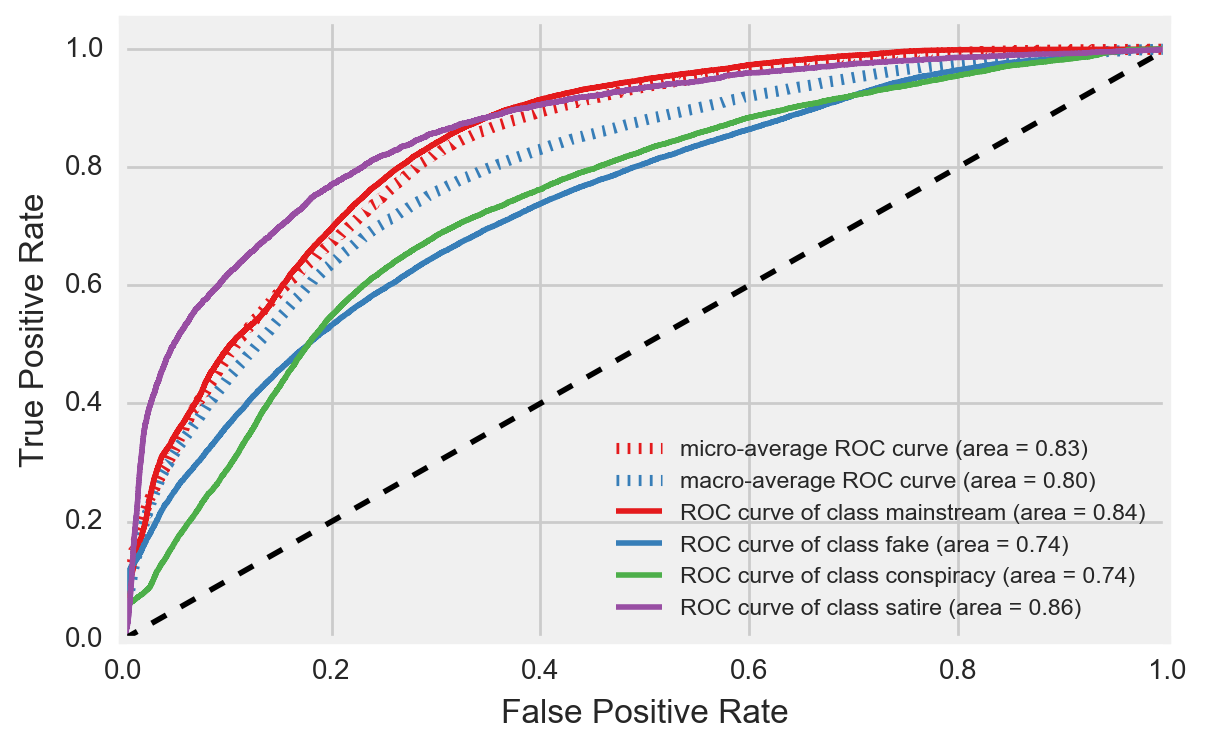

In [202]:
# Plot the ROC Curve
# The code to complete this task is a modified version of code from Scikit-Learn's website
bin_yte= label_binarize(yte, classes=[0, 1, 2, 3])
n_classes = bin_yte.shape[1]

# Retrieve the predicted probabilities and scores for the X observation matrix
y_score = logreg.fit(xtr, ytr).decision_function(xte)

# The ROC curve returns the false positive rate and true positive rates as the threshold changes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_yte[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bin_yte.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='#e41a1c', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='#377eb8', linestyle=':', linewidth=4)

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
class_names=['mainstream','fake','conspiracy','satire']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Multi-Class Receiver Operating Characteristic Curves')
plt.legend(loc="lower right",fontsize='small')
plt.show()

<a name="figure_14"></a>
#### Figure 14

Nonetheless the model showed apparent weaknesses. Precision (i.e. the percentage of correct predictions for a type of news out of the total predictions for that type of news) and recall (i.e. the percentage of correct predictions for a type of news out of the total type of news that really exist) ranged between 54% (fake and satire) and 70% (conspiracy) and between 8% (conspiracy) and 77% (fake), respectively. As shown in ([Figure 15](#figure_15)), low recall values resulted from the model predicting the majority of the conspiracy and satire posts as mainstream and fake.

Normalized confusion matrix
[[ 0.71  0.29  0.    0.  ]
 [ 0.2   0.77  0.01  0.01]
 [ 0.17  0.73  0.08  0.01]
 [ 0.37  0.45  0.01  0.17]]


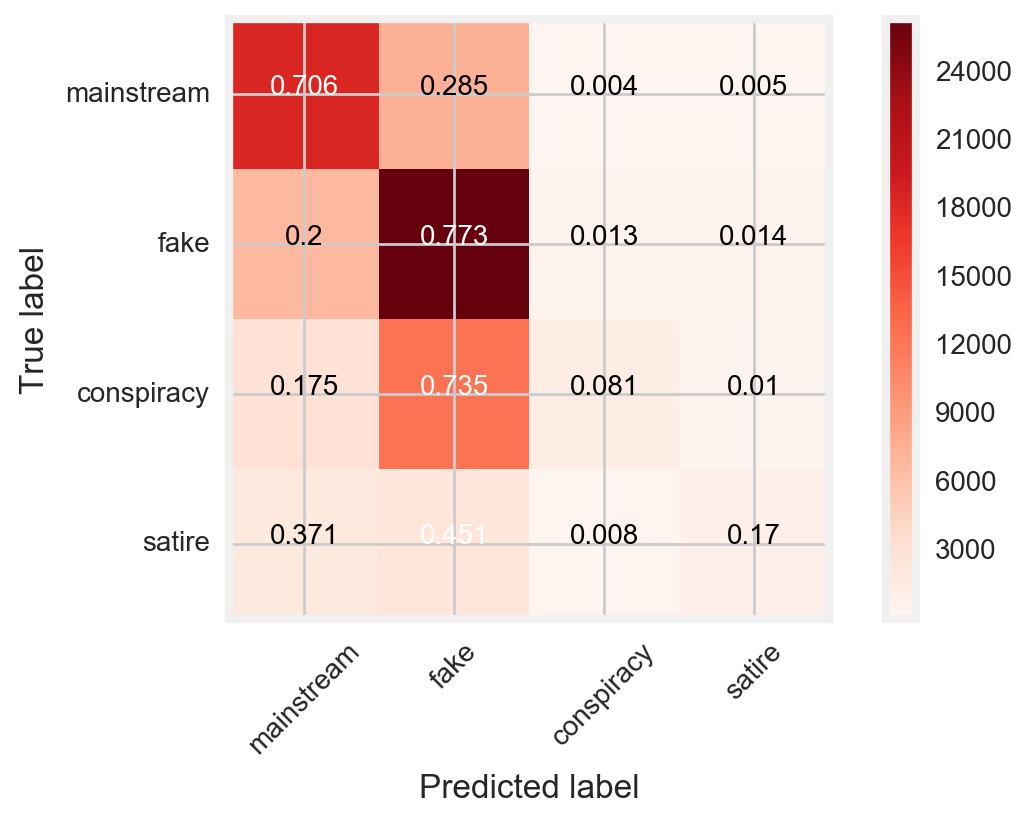

In [203]:
# Plot confusion matrix 
# The code to complete this task is a modified version of code from Scikit-Learn's website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=['mainstream','fake','conspiracy','satire']
cnf_matrix = confusion_matrix(yte, pred)
np.set_printoptions(precision=2)
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True)
plt.show()

<a name="figure_15"></a>
#### Figure 15
[See Model Summary for discussion.](#model_summary)

From a page-level view, these low recall results were evident when observing nearly all high and low volume conspiracy and satire pages incorrectly predicting several times the count of correct predictions ([Figure 16](#figure_16)). Fprnradio (conspiracy) and NewsThump (satire) were an exception to this case, with incorrect and correct counts relatively close. Elmundotoday (satire) and theunrealpage (satire) were also exceptions with the correct prediction count at least double the incorrect count.

Although all types of news have only a few sources that posted a large portion of the total volume and received much of the engagement ([Figure 3](#figure_3)), the model did not overfit to the characteristics of the most prolific or engaged pages. Using the test dataset, a review of the classified and misclassified posts by page confirmed this observation. Both high and low volume fake and mainstream news pages were classified as their true class more often than misclassified, i.e. for 70% and 80% of posts, respectively ([Figure 15](#figure_15)). Also, nearly all the posts for high and low volume conspiracy and satire pages were misclassified several times more than than the correctly classified posts ([Figure 16](#figure_16)).

In [58]:
# Generate a matrix identifying which sources are incorrectly predicted
page_names=pd.Series(['Empty'] * len(fb_id_xte))
print sum(page_names=='Empty')
fb_id_xte=pd.Series(fb_id_xte)
sites=list(fb_news_total['fb_id'].unique())
for i,item in enumerate(sites):
    try: 
        page_names[fb_id_xte.isin([i])]=item
    except:
        pass

type_names=pd.Series(['Empty'] * len(yte))
print sum(type_names=='Empty')
unique_type=list(fb_news_total['type'].unique())
for i,item in enumerate(unique_type): 
    type_names[pd.Series(yte).isin([i])]=item

print sum(page_names=='Empty')
print sum(type_names=='Empty')

page_confusion_dictionary={'actual_str':type_names,'actual':yte,'predicted':pred,'fb_id':page_names}
page_confusion_df=pd.DataFrame(data=page_confusion_dictionary)
page_confusion_df['prediction_type']='correct_type'
page_confusion_df.loc[page_confusion_df['actual']!=page_confusion_df['predicted'],'prediction_type']='incorrect_type'

82386
82386
0
0


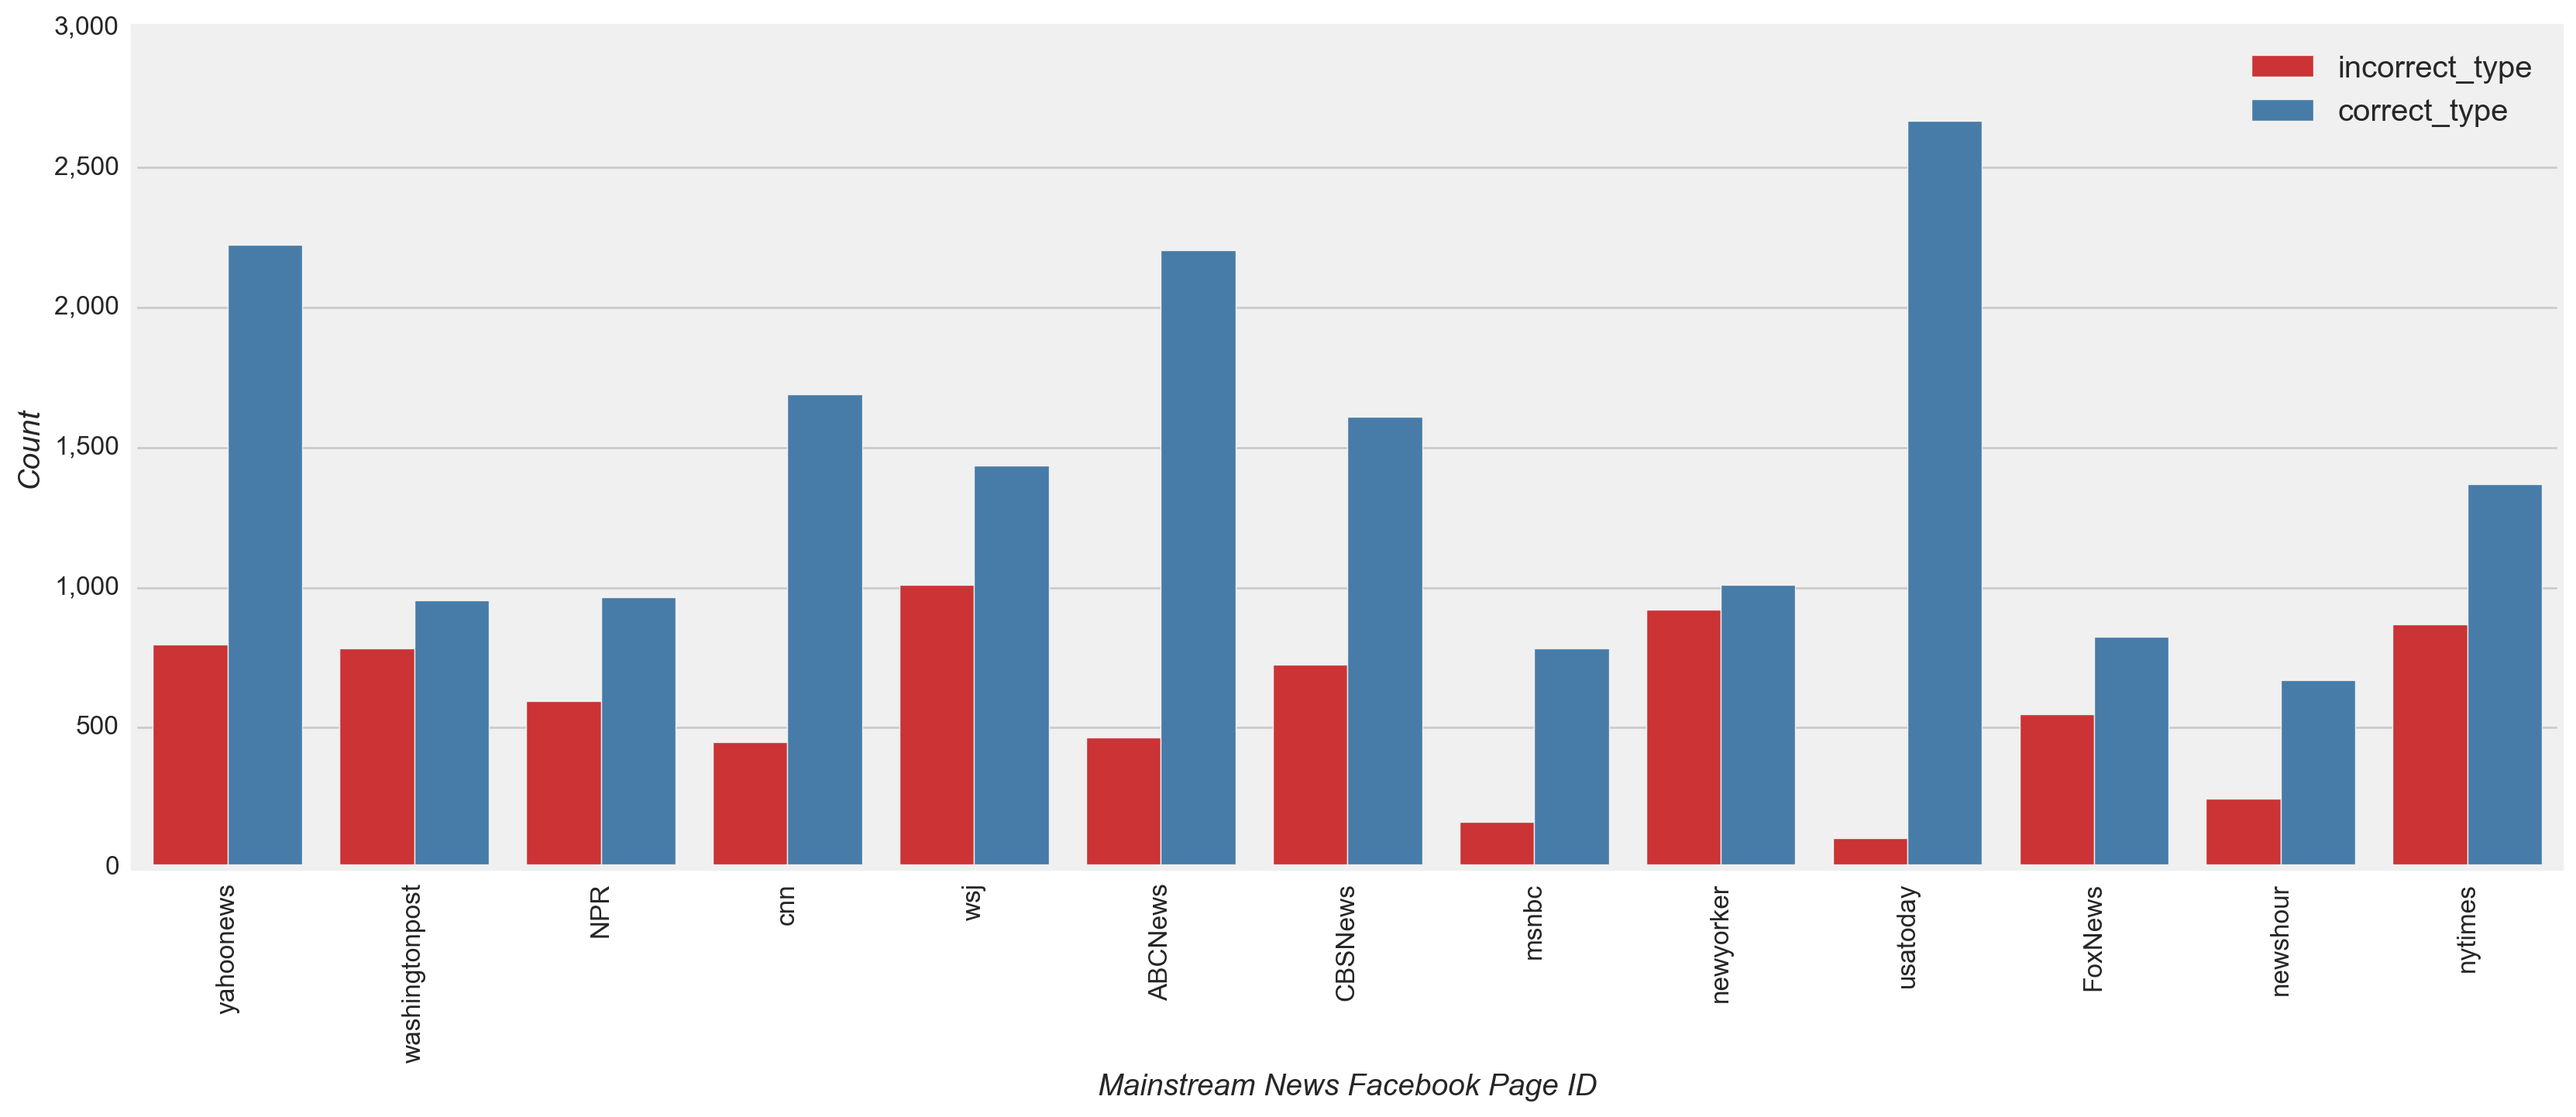

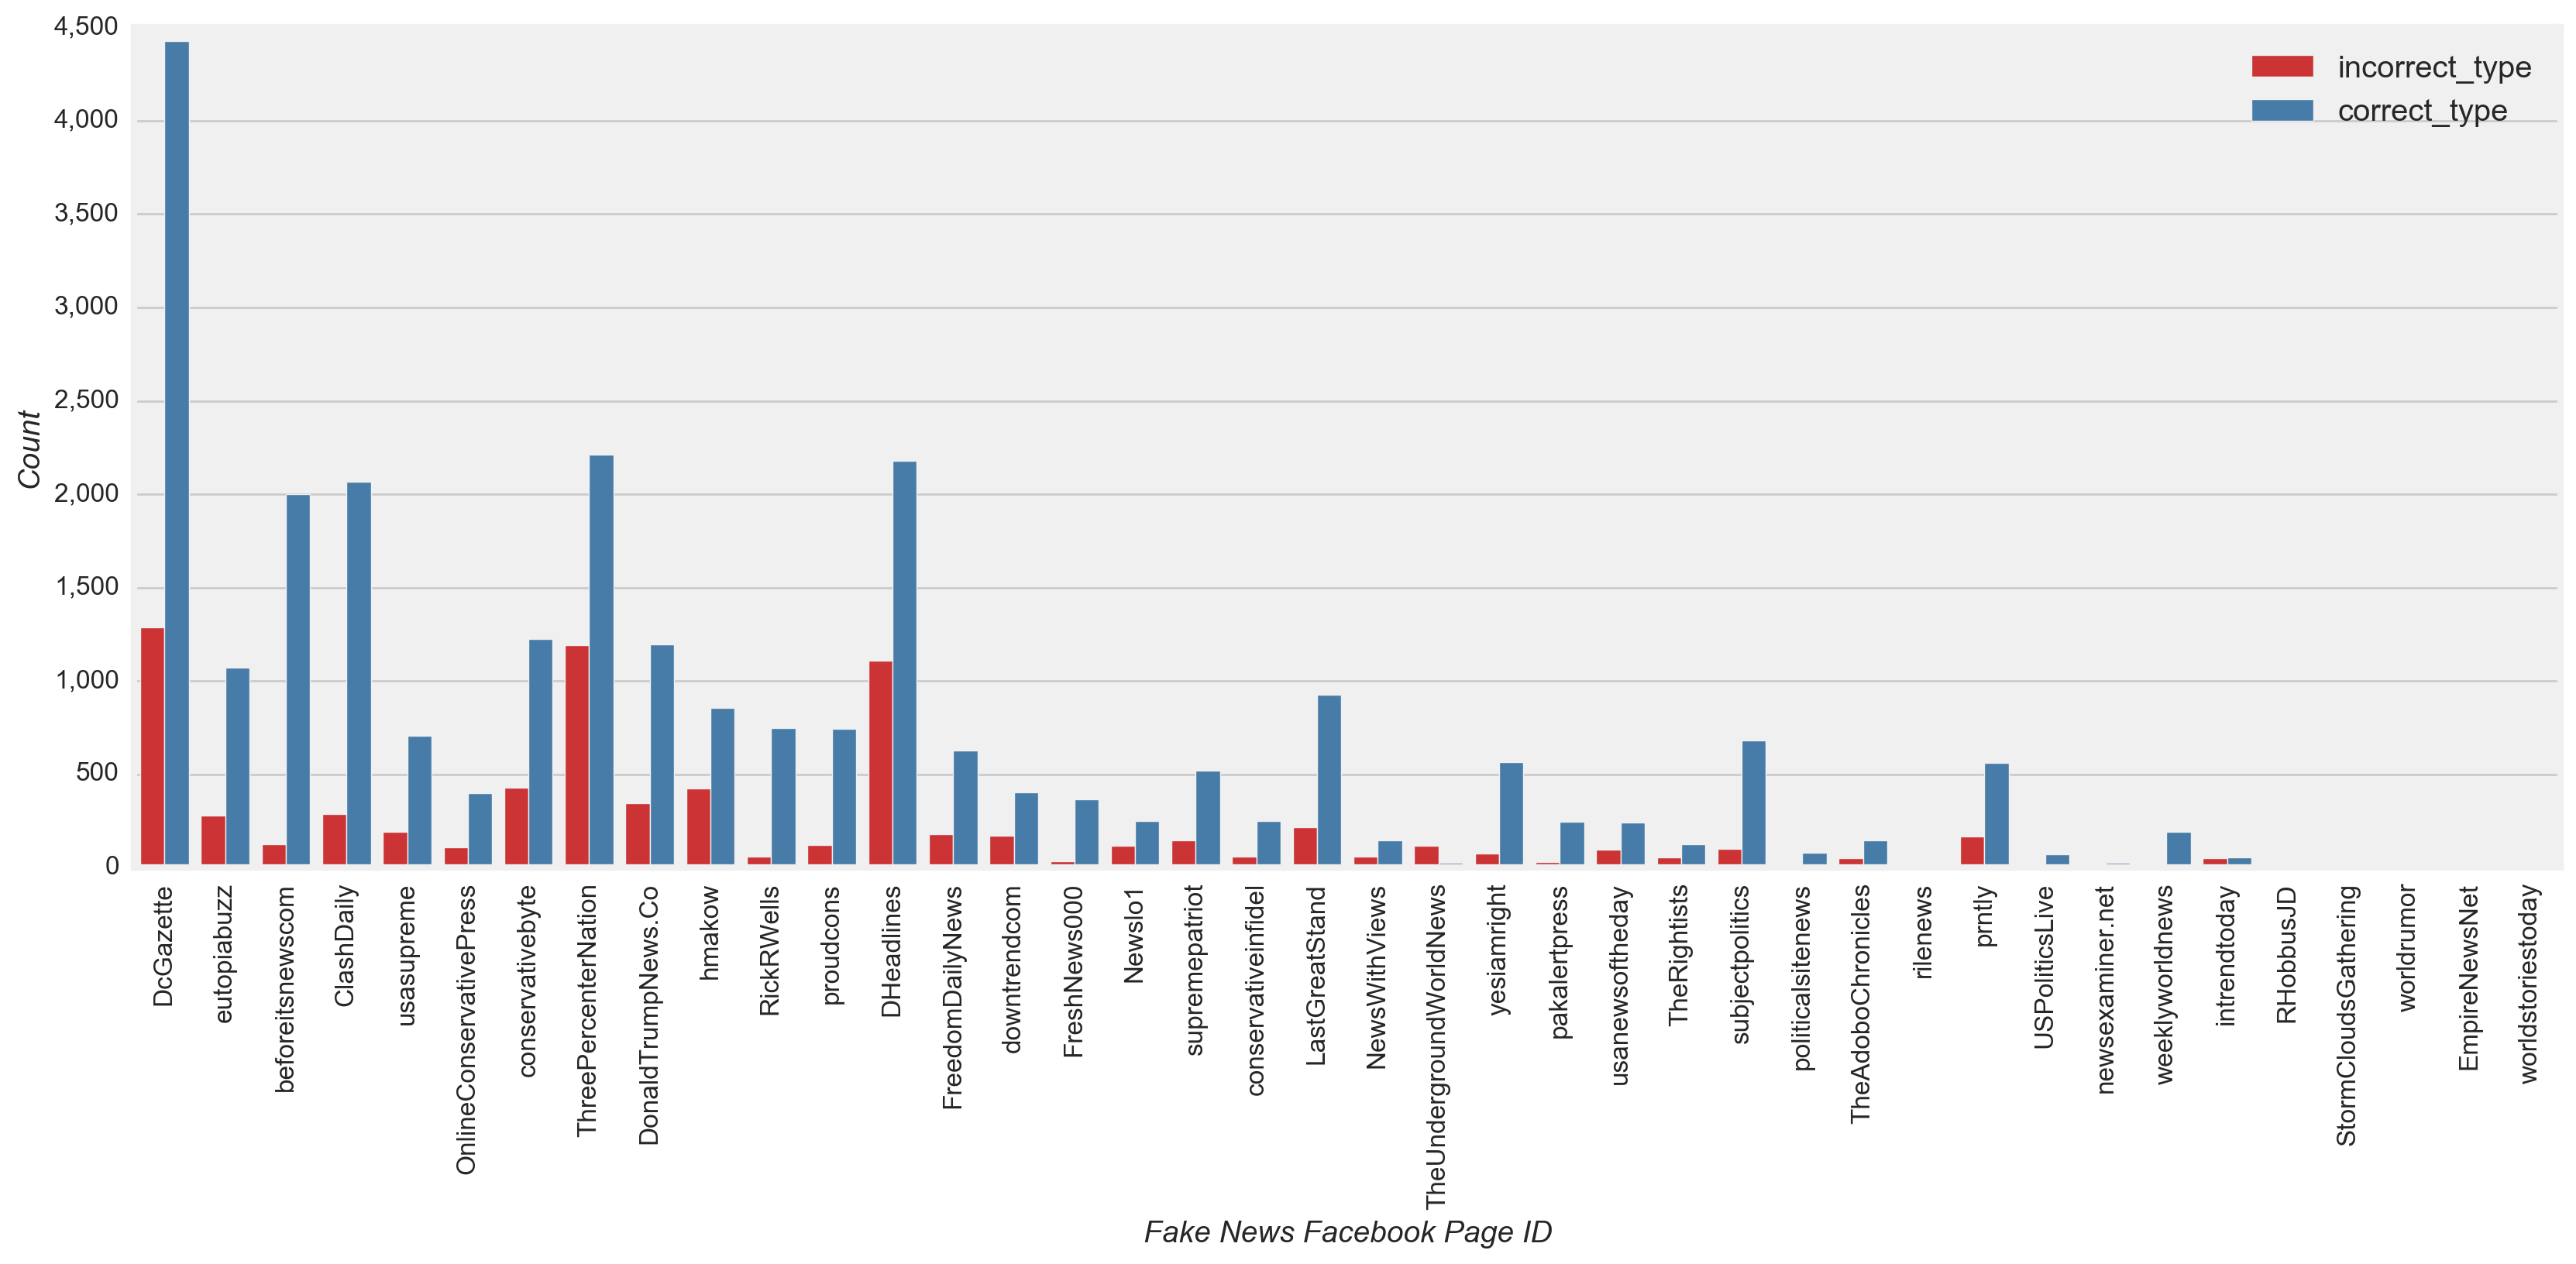

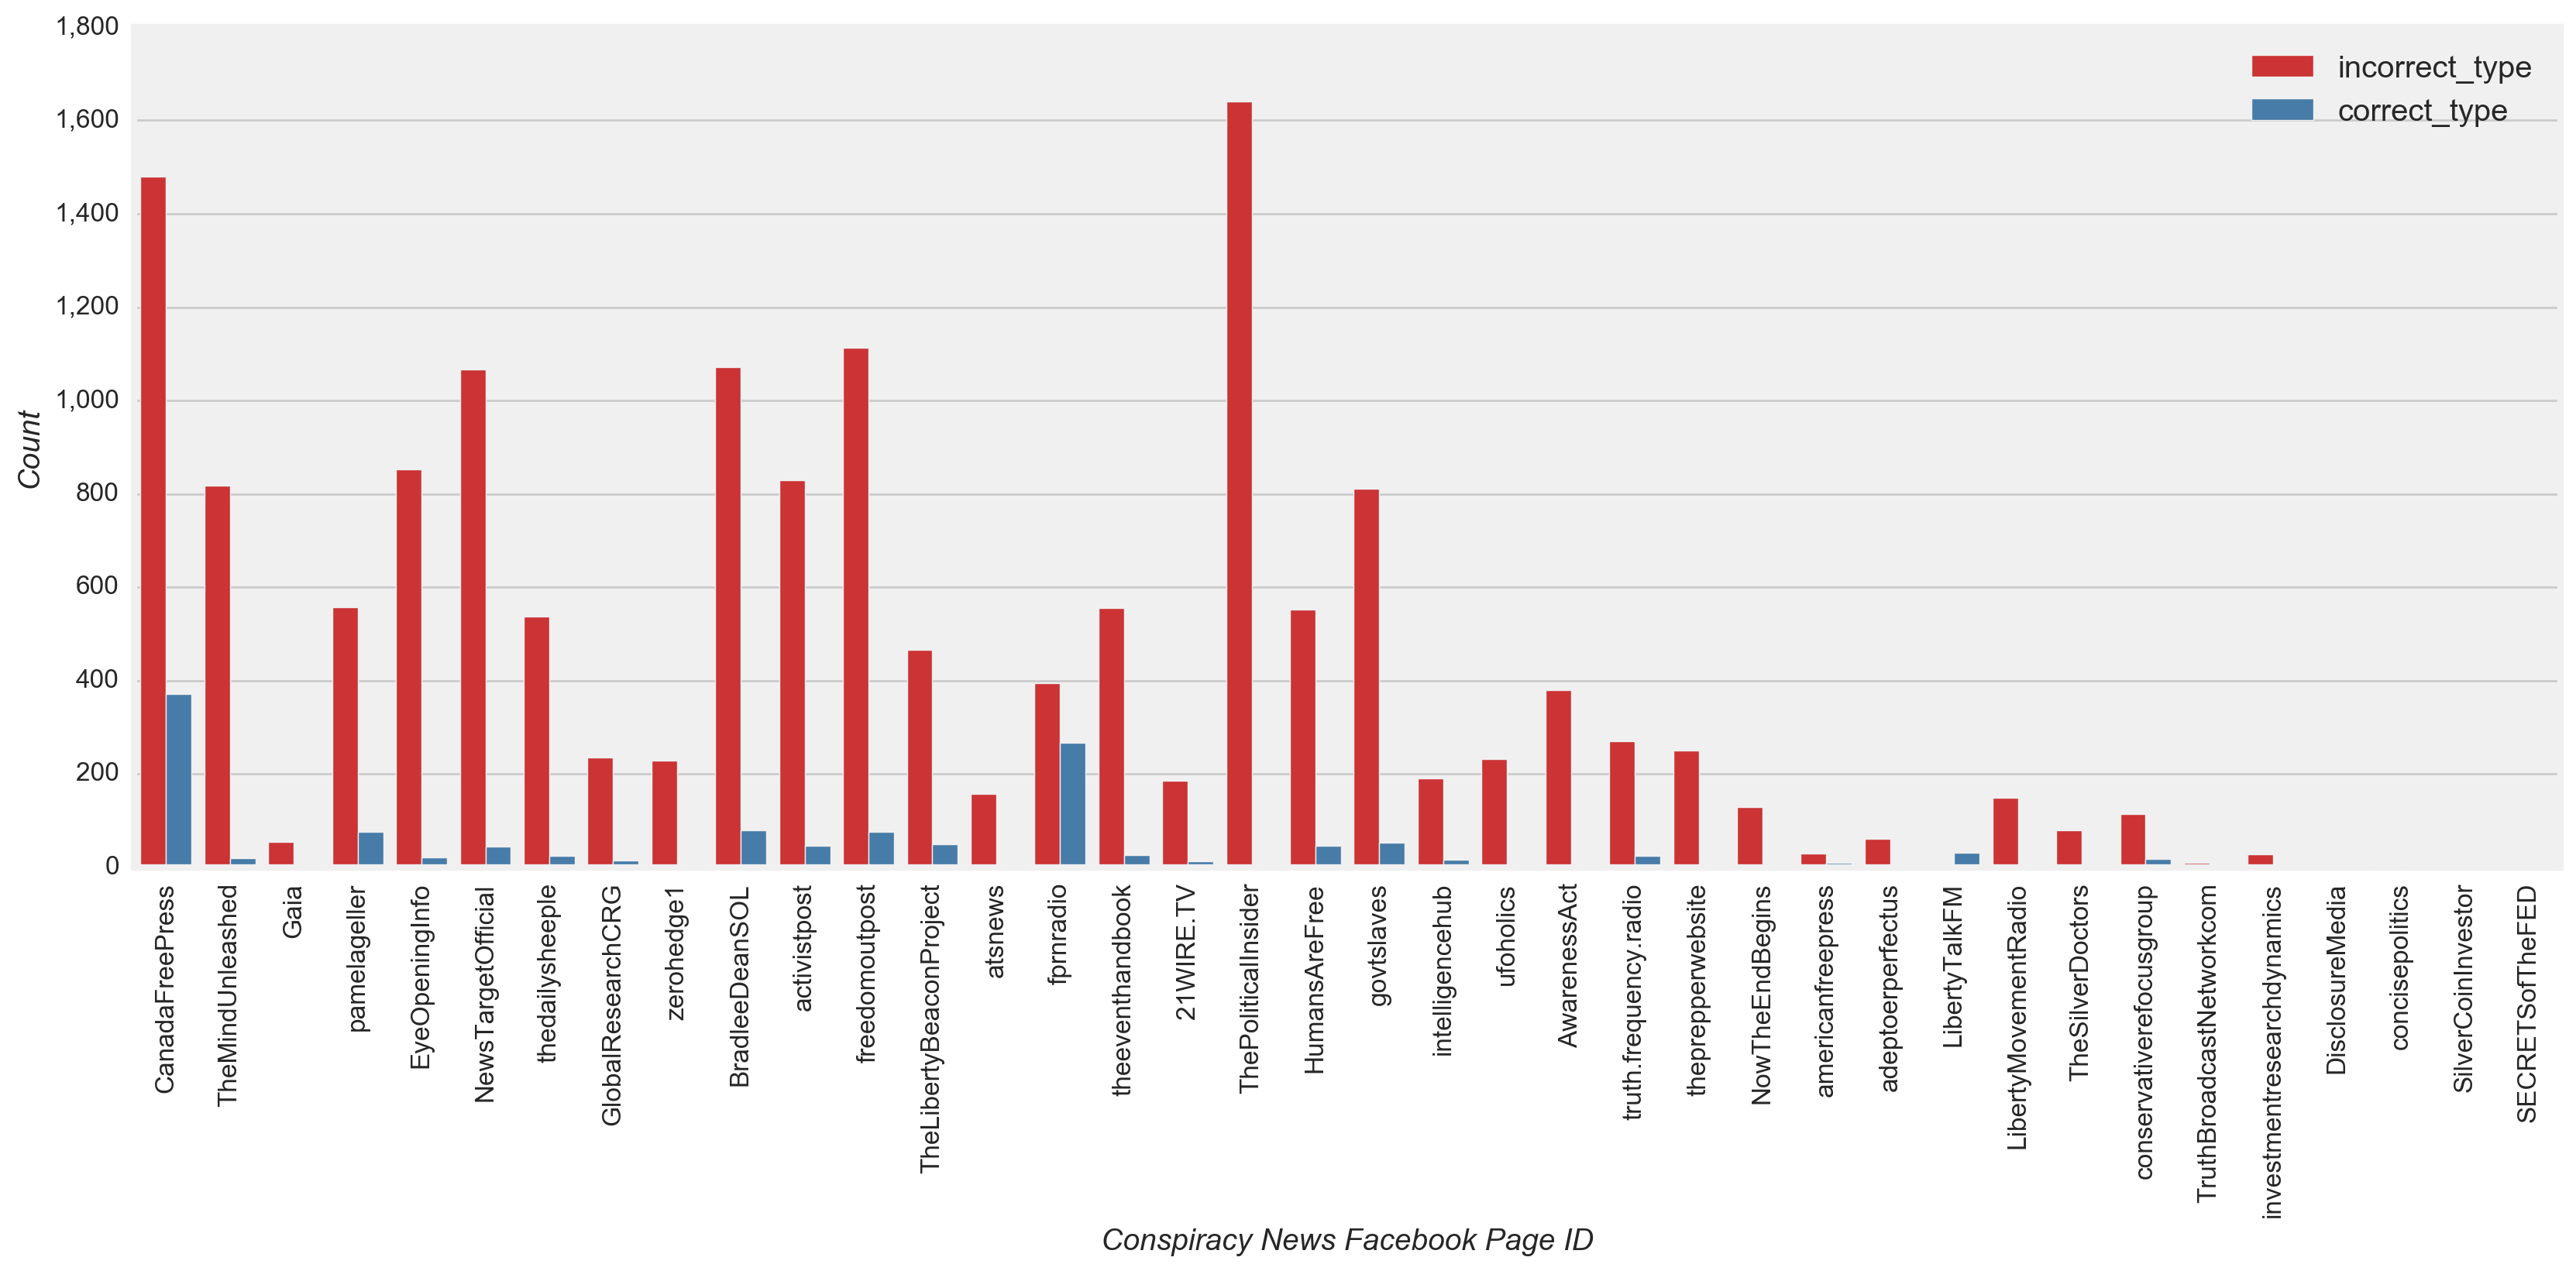

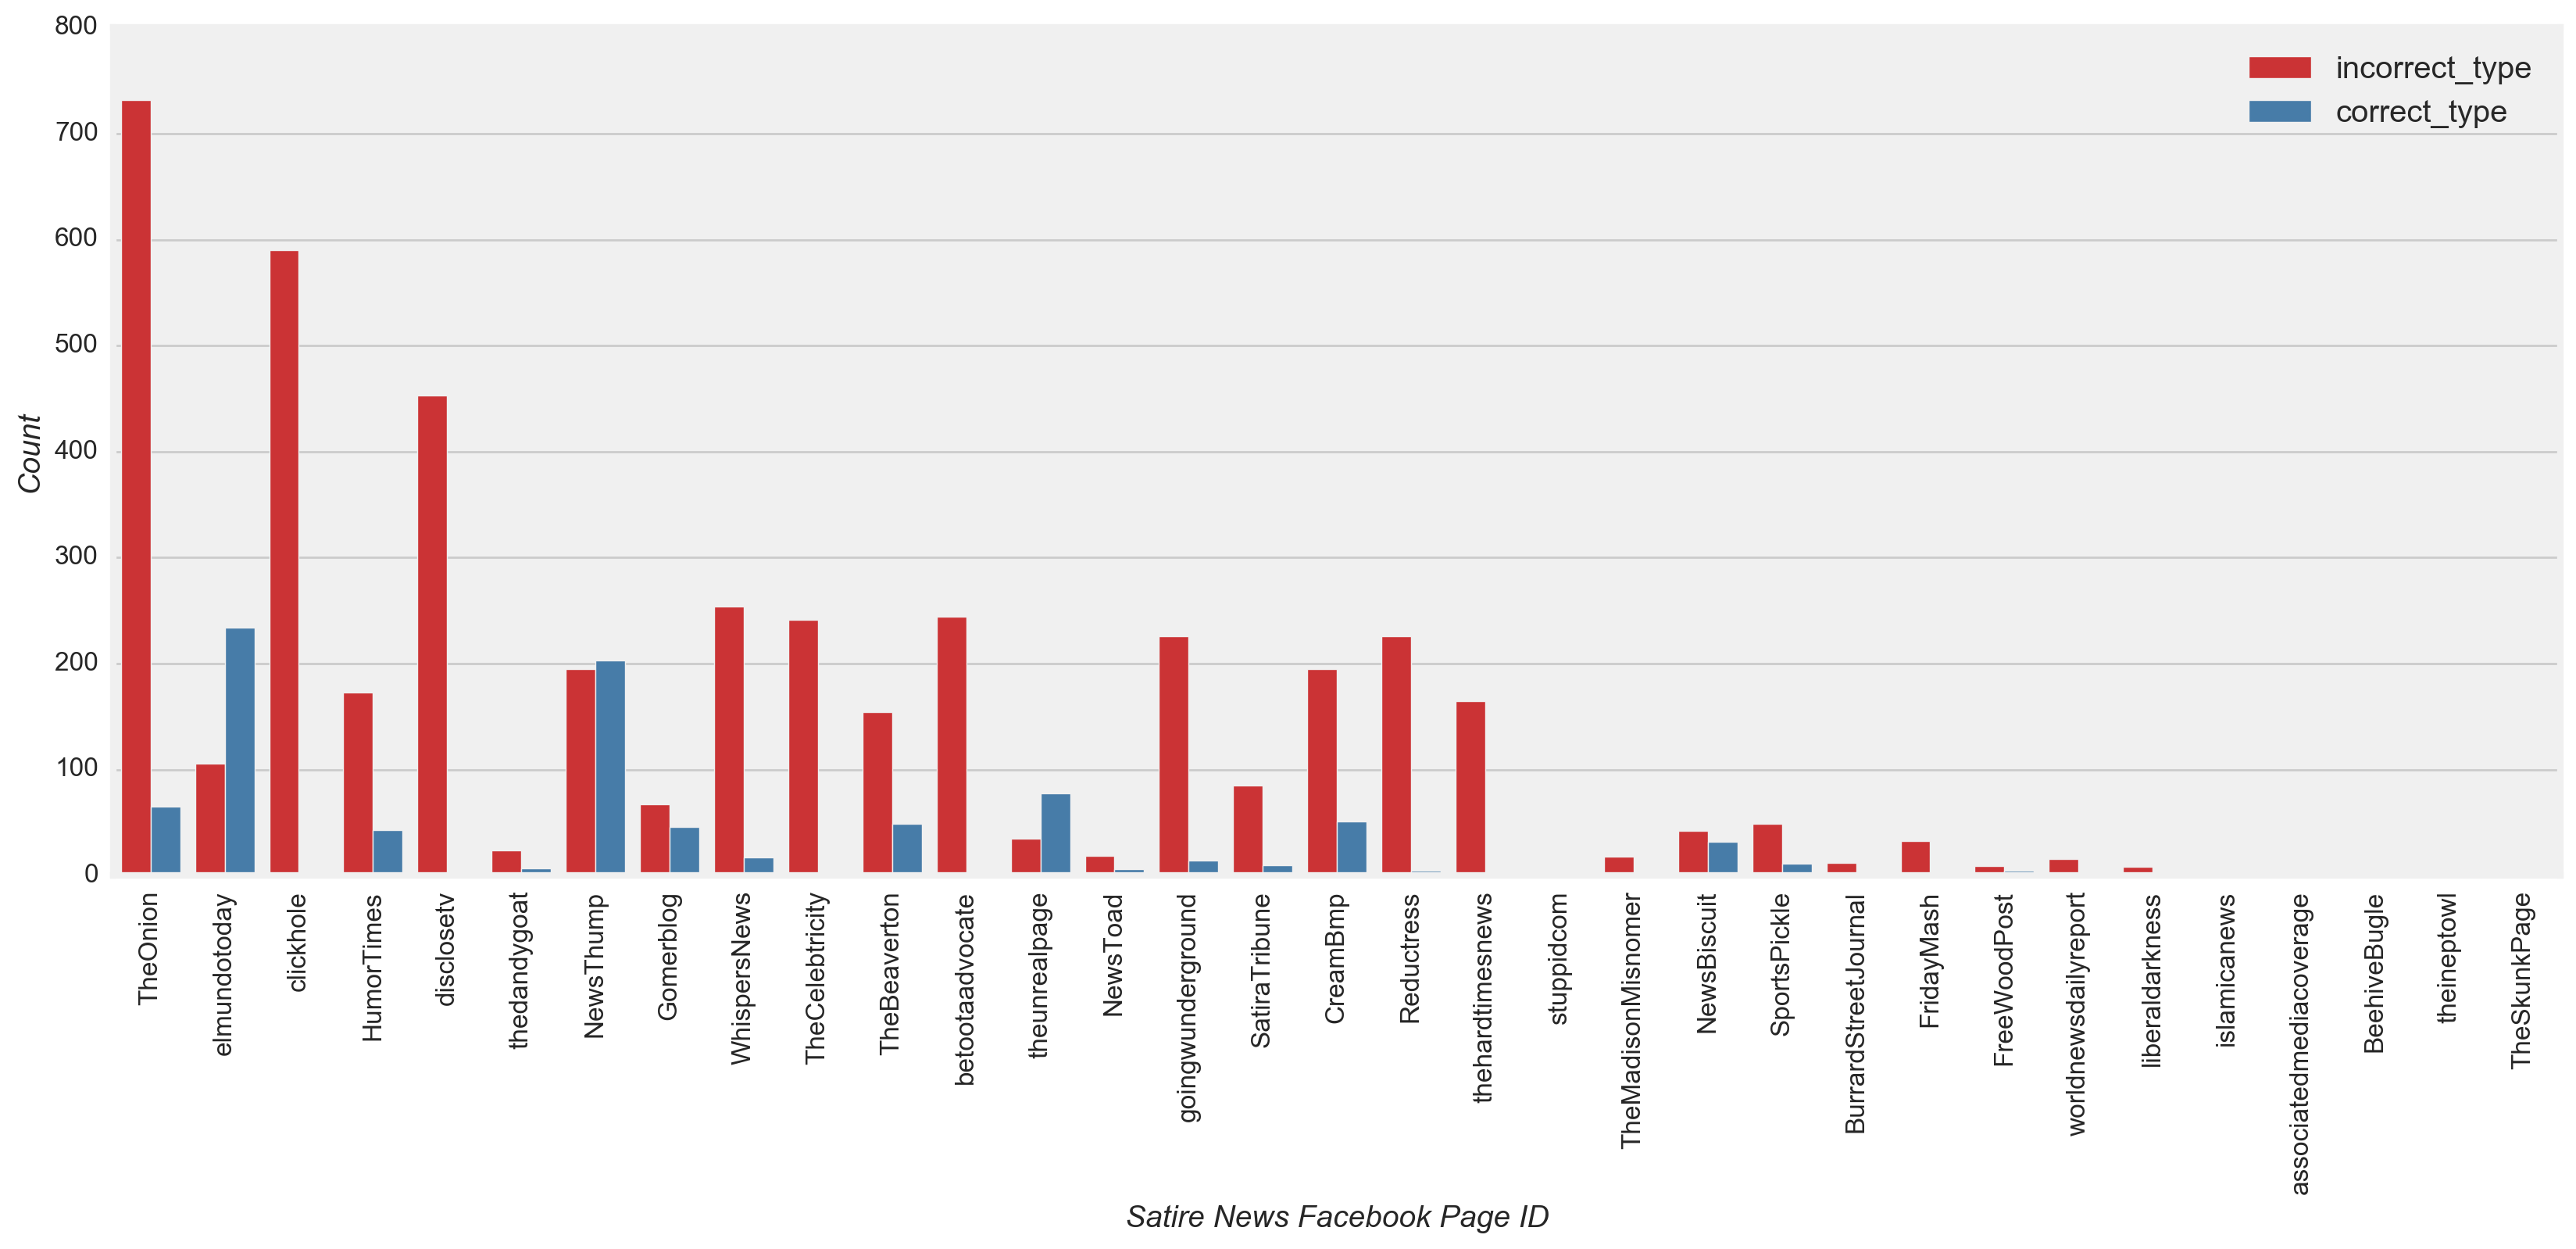

In [59]:
# Plot which sources are incorrectly predicted if the source has greater than 100 posts
for i,item in enumerate(['mainstream','fake','conspiracy','satire']):
#    reduced_source_list=page_confusion_df[page_confusion_df['actual_str']==item].groupby('fb_id')['prediction_type'].agg('count')[page_confusion_df[page_confusion_df['actual_str']==item].groupby('fb_id')['prediction_type'].agg('count')>100]
    temp=page_confusion_df.ix[page_confusion_df['actual_str']==item]
#    temp=temp[temp['fb_id'].isin(list(reduced_source_list.index))].reset_index()
    
    fig, ax = plt.subplots(figsize=(18,7))
    sns.countplot(x='fb_id', hue='prediction_type',data=temp,palette=['#e41a1c','#377eb8'],ax=ax,hue_order=['incorrect_type','correct_type'])

    plt.legend(loc="upper right",fontsize='x-large')
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90) 
    ax.set_ylabel("Count",style='italic',fontsize=14)
    ax.set_xlabel((item.capitalize() + " News Facebook Page ID"),style='italic',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,p: format(int(y), ',')))  
    plt.show()

<a name="figure_16"></a>
#### Figure 16

Overall, the final model showed the highest model coefficients for engagement actions and n-grams ([Figure 17](#figure_17)). The highest model coefficients by type of news included the following:
-  Mainstream news: likes (positive value [+]), comments (+), sads (+), neverhillary (negative value [-]), angrys (+)
- Fake news: follow american (+), follow deplorable (+), stop cheering (+), share expose (+), and sads (-)
- Conspiracy news: comments (-), follow american (-), tour ticket (+), follow deplorable (-), hahas (-)
- Satire news: likes (+), loves (-), hahas (+), angrys (-), neverhillary (-)

In [60]:
# Check source names are correctly concatenated to test predicted and true values. Both numbers should match 
# the number in the confusion matrix for true and predicted fake. 
print "Sum of correct fake source posts method 1: "+str(sum(page_confusion_df.ix[page_confusion_df['actual_str']=='fake','prediction_type']=='incorrect_type'))
fake_source=page_confusion_df[page_confusion_df['actual_str']=='fake']
sums=0
for i,item in enumerate(fake_source['fb_id'].unique()):
    temp=sum(page_confusion_df.ix[page_confusion_df['fb_id']==item,'prediction_type']=='incorrect_type')
    sums += temp
print "Sum of correct fake source posts method 2: "+ str(sums)

Sum of correct fake source posts method 1: 7744
Sum of correct fake source posts method 2: 7744


In [61]:
# Calibrate on entire dataset
logreg.fit(Xn,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [81]:
# Assebmle a matrix of the coefficients in the model and genearte a histogram of only the coefficients
# with the highest absolute values, i.e. those above 0.15
coefs = pd.DataFrame(logreg.coef_, columns=coefs_columns)
coefs.index = list(fb_news_total['type'].unique())
log_reg_coefs=coefs.transpose().reset_index()
log_reg_coefs.rename(index=str, columns={"index":"predictors"},inplace=True)
log_reg_coefs=pd.melt(log_reg_coefs, id_vars=['predictors'], value_vars=['mainstream', 'fake','conspiracy','satire'])

# Plot histogram of the greatest absolute value of the coefficients
#log_reg_coefs.ix[log_reg_coefs['value'].abs()>0.2,'value'].hist(bins=50)

In [149]:
# Show top five coefficients with the greatest absolute values for each type of news
log_reg_coefs['sort']=log_reg_coefs['value'].abs()
log_reg_coefs[log_reg_coefs['variable']=='mainstream'].sort_values(by='sort',ascending=False).head(5) 

predictors    variable     value      sort
11      num_likes  mainstream  2.130139  2.130139
9    num_comments  mainstream  1.115233  1.115233
15       num_sads  mainstream  1.056843  1.056843
184  neverhillary  mainstream -0.769933  0.769933
16     num_angrys  mainstream  0.617602  0.617602

In [150]:
log_reg_coefs[log_reg_coefs['variable']=='fake'].sort_values(by='sort',ascending=False).head(5) 

predictors variable     value      sort
538           num_sads     fake -0.523721  0.523721
708    follow american     fake  0.442209  0.442209
810       share expose     fake  0.426403  0.426403
709  follow deplorable     fake  0.380440  0.380440
717      stop cheering     fake  0.370391  0.370391

In [151]:
log_reg_coefs[log_reg_coefs['variable']=='conspiracy'].sort_values(by='sort',ascending=False).head(5) 

predictors    variable     value      sort
1055       num_comments  conspiracy -0.404651  0.404651
1231    follow american  conspiracy -0.356129  0.356129
1566       tour tickets  conspiracy  0.329660  0.329660
1232  follow deplorable  conspiracy -0.326712  0.326712
1060          num_hahas  conspiracy -0.308287  0.308287

In [152]:
log_reg_coefs[log_reg_coefs['variable']=='satire'].sort_values(by='sort',ascending=False).head(5) 

predictors variable     value      sort
1585    num_angrys   satire -1.991712  1.991712
1583     num_hahas   satire  0.731020  0.731020
1581     num_loves   satire -0.700576  0.700576
1580     num_likes   satire  0.674513  0.674513
1753  neverhillary   satire -0.551447  0.551447

In [174]:
log_reg_coefs[log_reg_coefs['predictors'].str.contains("num_hahas")]
#log_reg_coefs[log_reg_coefs['variable']=='satire']
# df[df['A'].str.contains("hello")]

predictors    variable     value      sort
14    num_hahas  mainstream  0.391571  0.391571
537   num_hahas        fake -0.131415  0.131415
1060  num_hahas  conspiracy -0.308287  0.308287
1583  num_hahas      satire  0.731020  0.731020

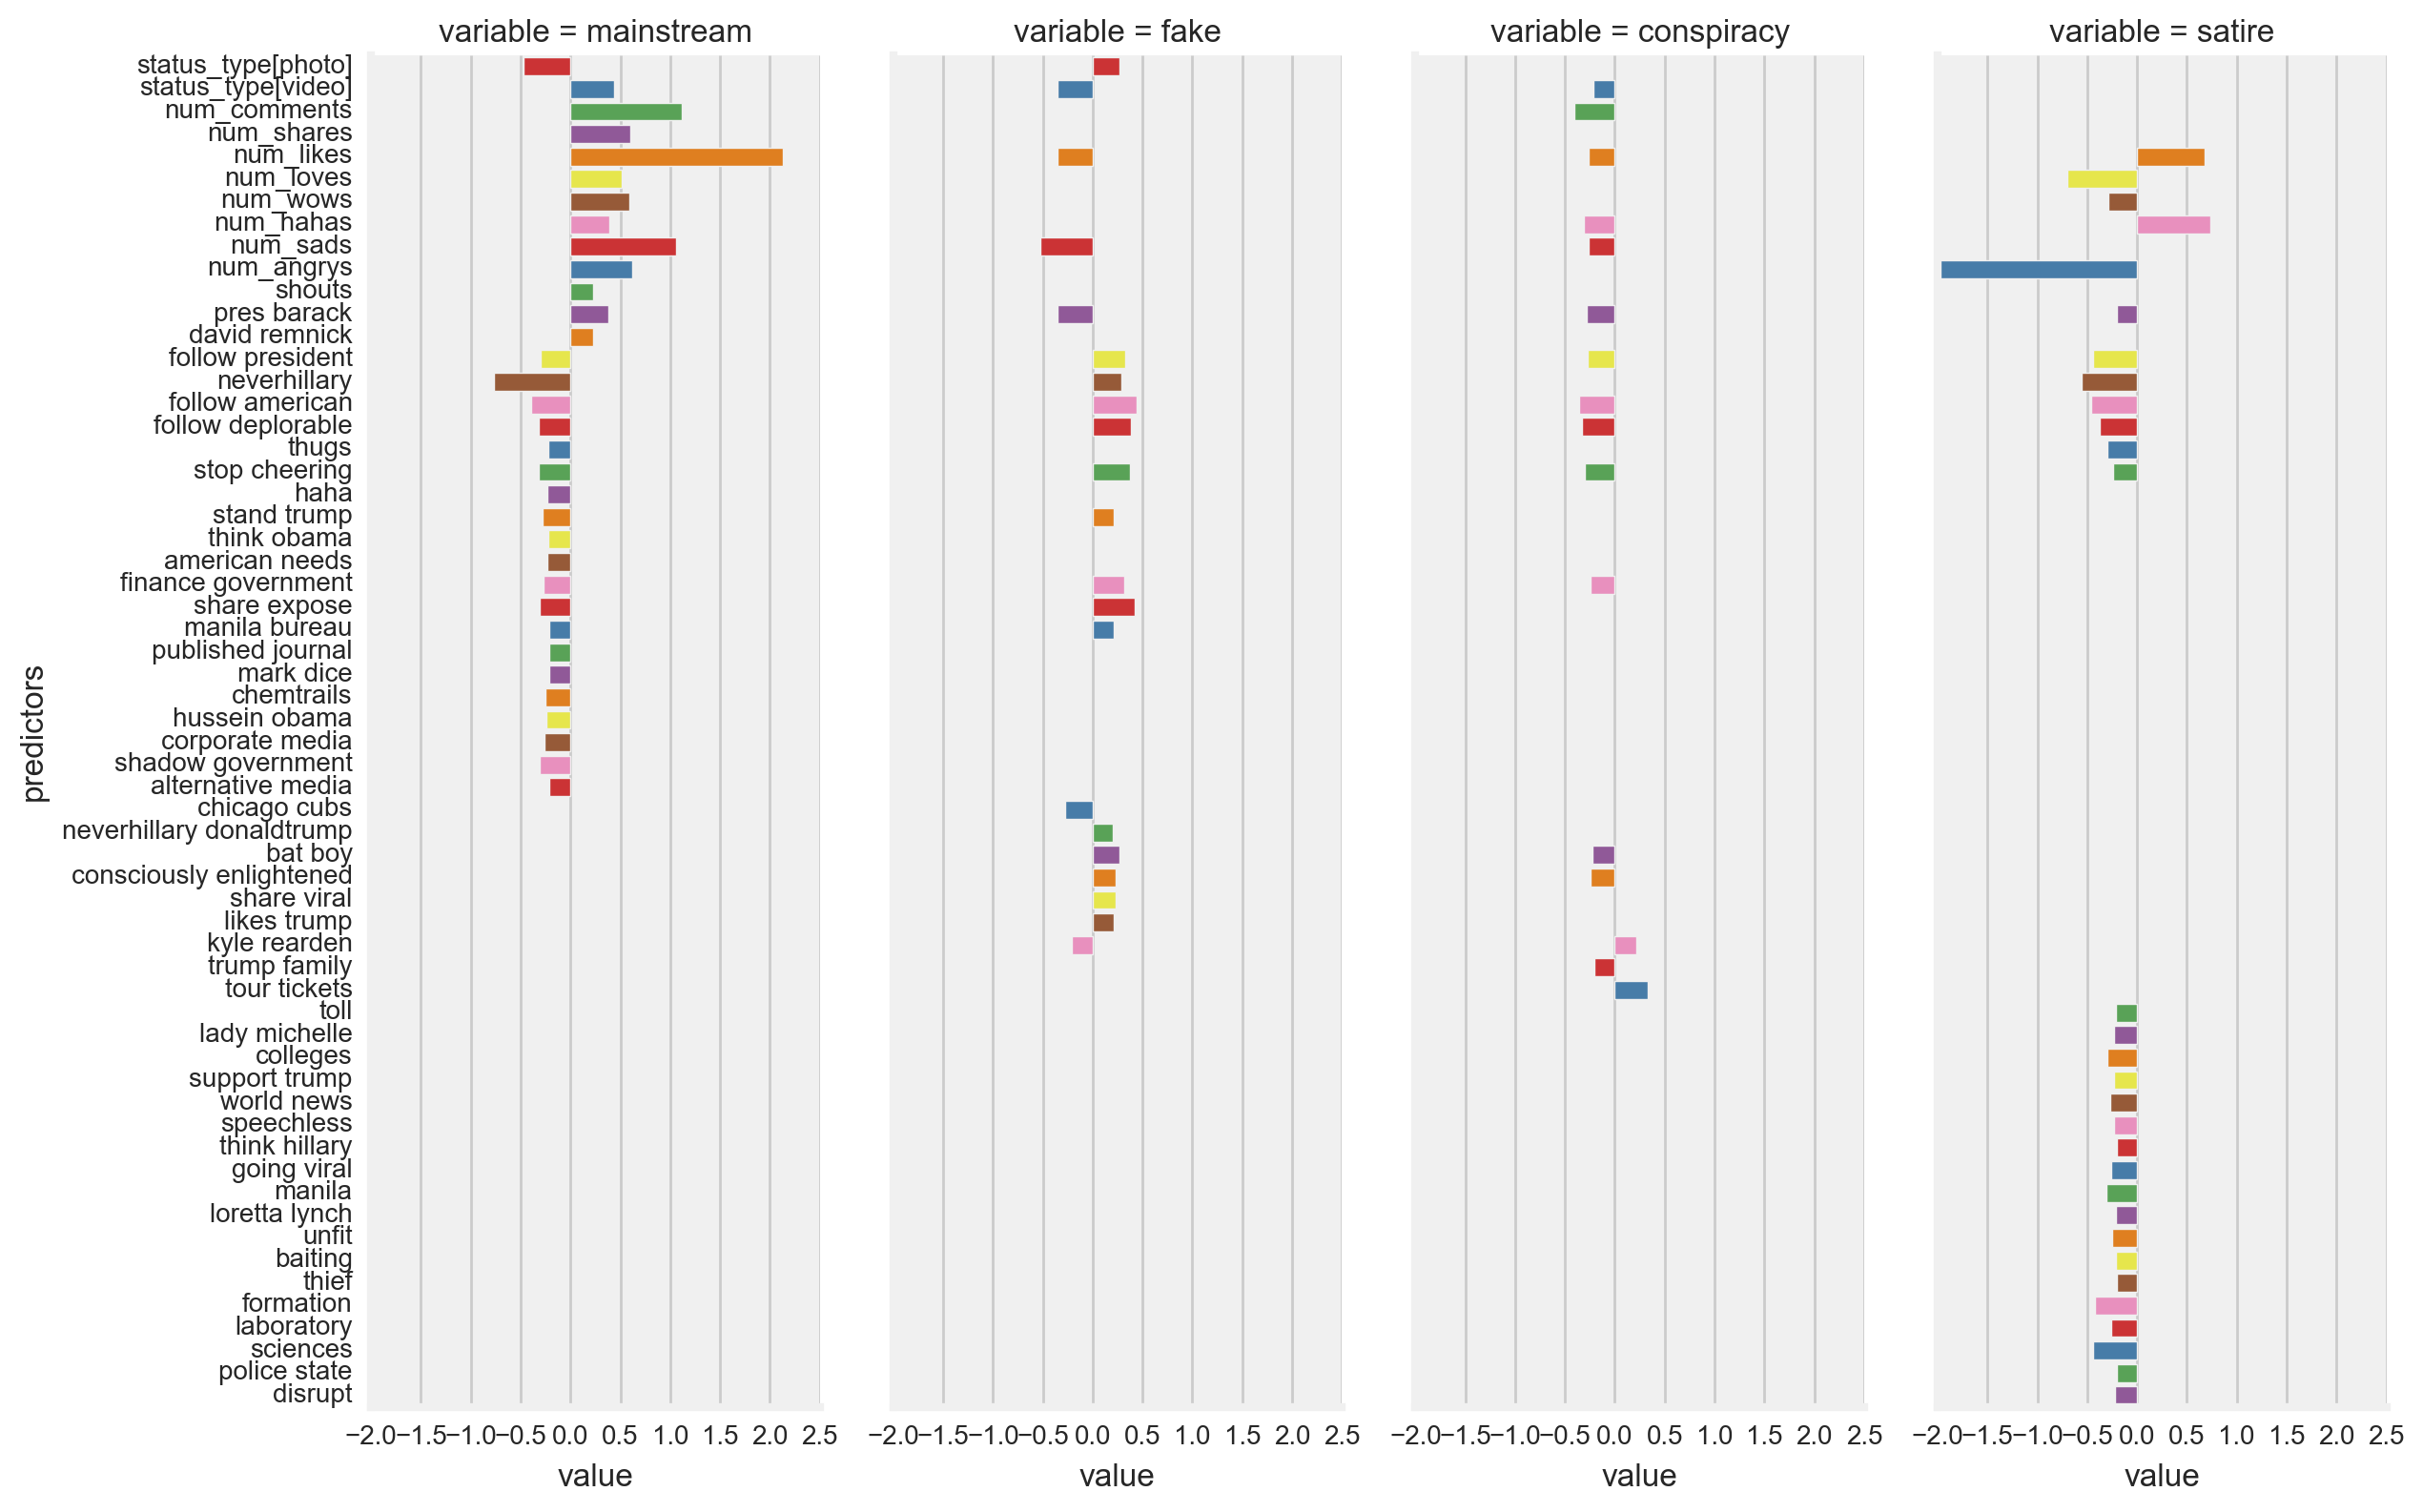

In [63]:
# Generate a plot with the greatest absolute values
sns.factorplot(x='value', y='predictors', data=log_reg_coefs[log_reg_coefs['value'].abs()>0.2], col="variable",kind='bar',size=8, aspect=0.4,palette=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf']);

<a name="figure_18"></a>
#### Figure 17

Values of model coefficients were evaluated against observations noted in the above EDA to further assess the performance of the model. These evaluations are summarized in the list below:
- As discussed above, mainstream pages posted videos more frequently than all other types of news ([Figure 4](#figure_4)). Upon inspection of the model coefficients, this observation was reflected in a relatively high model coefficient for mainstream videos compared with video coefficients for other types of news ([Figure 17](#figure_17)).

- A noticeable reduction in the percentage of posts from fake news was observed after the election ([Figure 5](#figure_5)). This observation was reflected in a relatively high pre-Presidential Election coefficient for fake news compared with the post-Presidential Election coefficient for fake news.

- Furthermore, as expected, due to the low variation of post frequency among different types of news throughout the week ([Figure 8](#figure_8)), model coefficients for days of the week varied very little among the different types of news (i.e. between -0.08 to 0.08).

- Also as expected, with little difference in the pattern of posts over the hours of the day between different types of news with the exception of satire news ([Figure 9](#figure_9)), model coefficients for hours of the day for mainstream, fake and conspiracy news were relatively low in comparison to the model coefficient for hours of the day for satire news.

- The model also confirms perhaps the least surprising observation. i.e. satire had a noticeably higher mean number of hahas per post compared with the mean number of hahas per post for other types of news ([Figure 10](#figure_10)). This observation was reflected in the high haha model coefficient for satire relative to the haha coefficients for all other types of news ([Figure 17](#figure_17)).

- For reasons to be determined in future work, share coefficients for fake and conspiracy news were actually lower than share coefficients for mainstream and satire news. This result contradicted expectations based on observing a greater proportion of shares in response to highly engaged fake and conspiracy posts relative to the proportion of shares in response to highly engaged mainstream and satire posts ([Figure 11](#figure_11)).

<a name="conclusion"></a>  
## Conclusion

- A quantifiable degree of success was achieved when relying on the source list compiled by Dr. Melissa Zimdars to predict the type of news of a Facebook post from specific post features. A 57% mean accuracy was achieved on the test dataset with a test-train split of 30%-70%-an increase of 16% above baseline-and the areas under the ROC curves indicated a well-performing model on the test dataset ([Figure 14](#figure_14)).

- Low recall values on the test dataset resulted from the model predicting the majority of the conspiracy and satire posts as mainstream and fake posts ([Figure 15](#figure_15) and [Figure 16](#figure_16)).

- Although all types of news only have a few sources that posted a large portion of the total volume and received much of the engagement ([Figure 3](#figure_3)), the model did not overfit to the characteristics of the most prolific or engaged pages as confirmed in a review of the classified and misclassified posts by page on the test dataset ([Figure 16](#figure_16)).

- Overall, the final model showed the highest model coefficients for engagement actions and n-grams ([Figure 17](#figure_17)).

- The values of model coefficients confirmed many of the observations described in the EDA, including the more frequent posting of videos by mainstream news ([Figure 4](#figure_4)), changes in the posting of pre- and post_presidential Election fake news ([Figure 5](#figure_5)), the low variation in posting among different types of news throughout the week ([Figure 8](#figure_8)), and the unique characteristics of satire news (i.e. the distinct posting pattern over the hours of the day and the high mean number of hahas per post compared to other types of news) ([Figure 9](#figure_9) and [Figure 10](#figure_10)).

<a name="future_work"></a> 
## Future Work

- Calibrate and verify the model using more posts, messages, and news pages with a dataset of posts more evenly sampled among types of news than the current project dataset. Confirm if proxies stand once complete. More satire posts over a longer period of time are needed to understand broad patterns among message text and engagement activities, because the existing project dataset contains fewer satire posts relative to all other types of news ([Figure 10](#figure_10)).
- Vary number and type of words from message text used in the model. Possibly include n-grams of link names.
- Examine the content of the pre-categorized posts in the dataset and, if necessary, correct the label.
- Evaluate other feature engineering options to compare against the  performance of Lasso regularization.
- Use GridSearch to vary the degree of regularization (i.e the C parameter).
- To resolve the discrepancy between the results from the EDA and the examination of model coefficients as discussed above, discover why share coefficients for fake and conspiracy news are lower than share coefficients for mainstream and satire news.